In [1]:
import multiprocessing as mp                                                                                                                                                                                       
import os                                                                                                                                                                                                          
import numpy as np                                                                                                                                                                                                 
import awkward as ak                                                                                                                                                                                               
import matplotlib.pyplot as plt                                                                                                                                                                                    
import matplotlib                                                                                                                                                                                                  
import matplotlib.colors as colors                                                                                                                                                                                 
from tools.roottree import read_tree                                                                                                                                                                               
from tools.selections import *                                                                                                                                                                                     
import scipy.stats                                                                                                                                                                                                 
from scipy.optimize import curve_fit                                                                                                                                                                               
                                                                                                                   
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, FIGSIZE_MID, FIGSIZE_BIG, setplot_defaultstyle, format_order_of_magnitude, FONTSIZE, set_plot_defaultstyle                                                       
from tools.studybeta import calc_signal_fraction                                                                                
from tools.binnings_collection import fbinning_fraction, fbinning_RICHnpe                                                                                                                                          
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center                                                                                                                          
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.histograms import WeightedHistogram, Histogram, plot_histogram_2d, plot_histogram_1d   
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, plot1d_step, FONTSIZE, set_plot_defaultstyle  
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES, ISOTOPES_CHARGE
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.calculator import calc_beta
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.constants import ISOTOPES_MASS, DETECTOR_COLOR
from tools.massfit_tools import get_fitpdferrorband, get_fitpdf_witherr
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat
from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
detectors = [ 'NaF', 'Agl']
xvalues = np.array([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
graph_meanvsz_iss = {}
graph_meanvsz_mc = {}
graph_sigmavsz_iss = {}
graph_sigmavsz_mc = {}
graph_diff_mean = {}
graph_ratio_sigma = {}
for dec in detectors:
    graph_meanvsz_iss[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    graph_meanvsz_mc[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    graph_sigmavsz_iss[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    graph_sigmavsz_mc[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    graph_diff_mean[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    graph_ratio_sigma[dec] = MGraph(xvalues, np.zeros_like(xvalues), np.zeros_like(xvalues))
    
    

In [18]:

filepath = '/home/manbing/Documents/Data/data_BeP8/BetaHighR/'
filename_hist = {'Li': os.path.join(f'{filepath}', 'LiISS2_betaHighR_B1236P8_richbeta2_tofbeta1.npz'),
                 'Be': os.path.join(f'{filepath}', 'BeISS_BeforeTuneBetaHighR_B1236P8_tofBeta1.npz'),
                 'B': os.path.join(f'{filepath}', 'BISS2_betaHighR_B1236P8_richbeta2_notof.npz'), 
                 'C':os.path.join(f'{filepath}', 'CISS2_betaHighR_B1236P8_richbeta2_tofbeta2.npz'), 
                 'N':os.path.join(f'{filepath}', 'NISS2_UntunedBetaHighR_B1236P8_tofBeta1.npz'),
                 'O':os.path.join(f'{filepath}', 'OISS2_betaHighR_B1236P8_richbeta2_tofbeta2.npz')}


filename_hist_tuned = {'Li': os.path.join(f'{filepath}', 'LiISS2_TunedInverseBetaHighR_B1236P8_tofBeta1.npz'),
                     'Be': os.path.join(f'{filepath}', 'BeISS2_betaHighR_B1236P8_richbeta2Tuned.npz'),
                     'B': os.path.join(f'{filepath}', 'BISS_tunedBetaHighR_B1236P8_tofBeta1.npz'), 
                     'C':os.path.join(f'{filepath}', 'CISS_tunedBetaHighR_B1236P8_tofBeta1.npz'), 
                    'N': os.path.join(f'{filepath}', 'NISS_tunedBetaHighR_B1236P8_tofBeta1.npz'), 
                     'O':os.path.join(f'{filepath}', 'OISS2_TunedInverseRICHBetaHighR_B1236P8.npz')}


nuclei_names = {'Li', 'Be', 'B', 'C', 'N', 'O'}

#df_untuned = np.load(f'{filename_hist[nuclei]}')
#df_tuned = np.load(f'{filename_hist_tuned[nuclei]}')

nucleiname = {'O': 'Oxygen', 'C':'Carbon', 'Be': 'Be', 'B': 'Boron', 'Li': 'Li', 'N': 'N'}
MCNameText = {'Be': 'Be MC(Be7:9:10=[6:3:1])', 'B': 'B MC(B10:B11=[1:1])', 
              'C': 'C12 MC', 'O': 'O16 MC', 'Li': 'Li MC(Li6:7=1:1)', 'N': 'N MC(N14:N15=1:1)'}
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR'

isbeta1 = False
useTunedBeta = False
figsuffix = 'betatuned_thesis' if useTunedBeta else 'beta_untuned_thesis'

isscolor = 'black'
mccolor = 'red' if useTunedBeta else 'blue'
detectors = ['NaF', 'Agl']

    

In [19]:

hist_mcTrueR = {dec: {} for dec in detectors}
hist_mcbeta = {nuclei: {} for nuclei in nuclei_names}
hist_issbeta = {nuclei: {} for nuclei in nuclei_names}
hist_issbeta_sv = {nuclei: {} for nuclei in nuclei_names}
df = {}
if useTunedBeta:
    filename = filename_hist_tuned
else:
    filename = filename_hist
    
for nuclei in nuclei_names:
    isotopes = ISOTOPES[nuclei]
    for dec in detectors:
        df[nuclei] = np.load(f'{filename[nuclei]}')
        hist_issbeta[nuclei][dec] =  Histogram.from_file(df[nuclei], f'hist_issbetareso_{dec}')
        hist_issbeta_sv[nuclei][dec] = hist_issbeta[nuclei][dec] * (1/np.sum(hist_issbeta[nuclei][dec].values))
        hist_mcbeta[nuclei][dec] =  WeightedHistogram.from_file(df[nuclei], f'hist_mcbetareso_mix_{dec}')
        hist_mcbeta[nuclei][dec] = hist_mcbeta[nuclei][dec] * (1/np.sum(hist_mcbeta[nuclei][dec].values))
    
    #for iso in isotopes:
    #    hist_mcTrueR[dec][iso] = WeightedHistogram.from_file(df, f'hist_mcTrueR_{dec}{iso}')
    #fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
    #plot_histogram_1d(ax1, hist_mcbeta[dec], style="mc", color=mccolor, label='MC', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    #plot_histogram_1d(ax1, hist_issbeta_sv[dec], style="iss", color=isscolor, label='Data', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    #ax1.text(0.05, 0.98, f"Old: {dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
    #ax1.set_ylim([0.0001, 0.]) 
    #ax1.legend()
    ####normalize it to 1
    #savefig_tofile(fig, plotfile, f"{dec}_{nuclei}_beta_highR_beforetune_nofit_{figsuffix}", show=True) 

In [20]:
def Fill_Graph_Points(graph_mean, graph_sigma, par_iss, parerr_iss, ipoint):
    graph_mean.yvalues[ipoint] = par_iss['mu']
    graph_mean.yerrs[ipoint] = parerr_iss['mu']
    graph_sigma.yvalues[ipoint] = par_iss['sigma']
    graph_sigma.yerrs[ipoint] = parerr_iss['sigma']

N 4
B 2
O 5
Be 1
Li 0
C 3


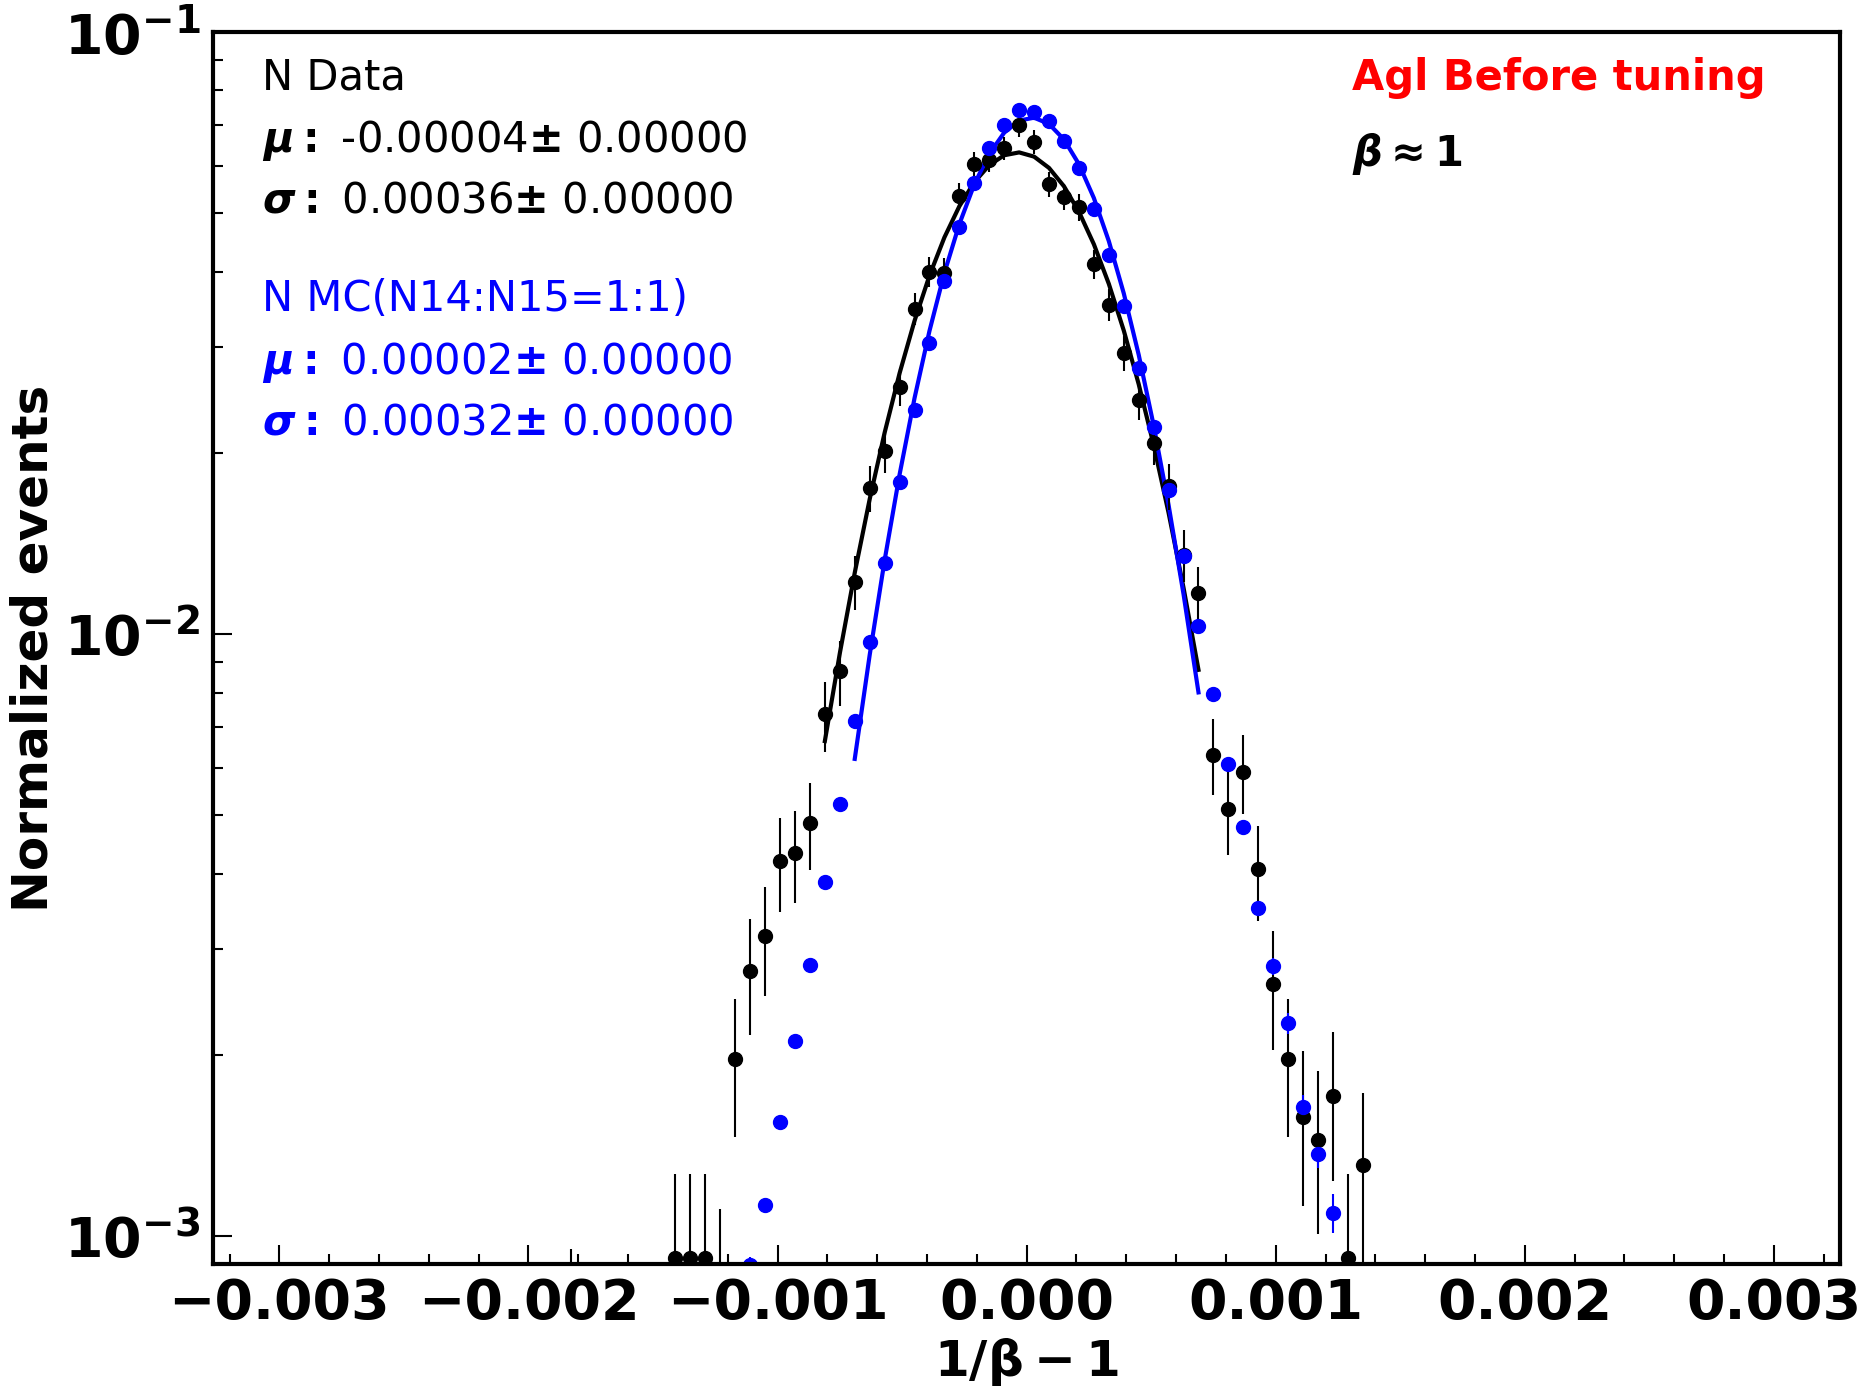

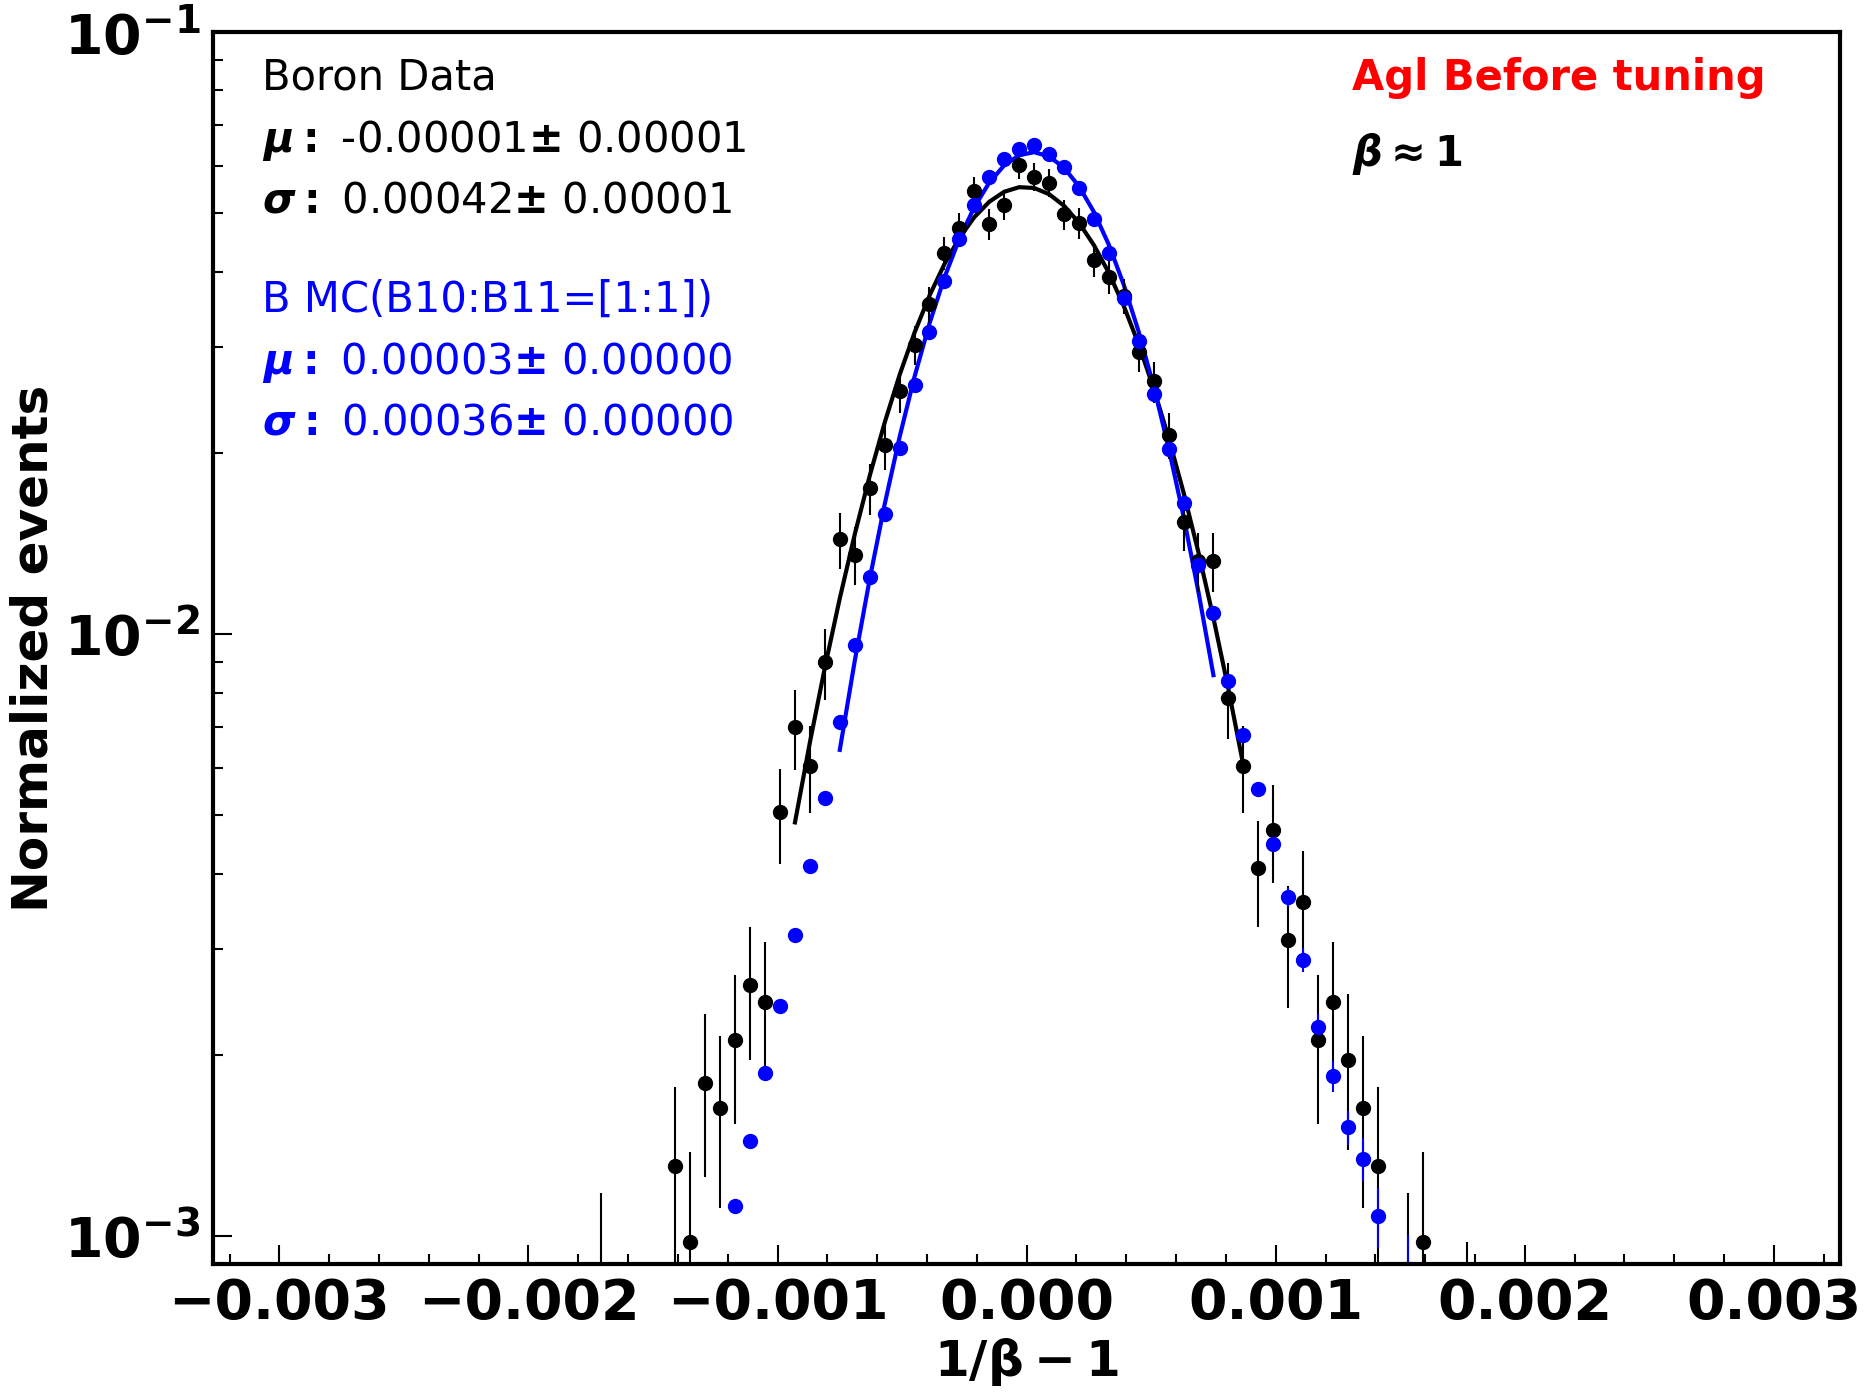

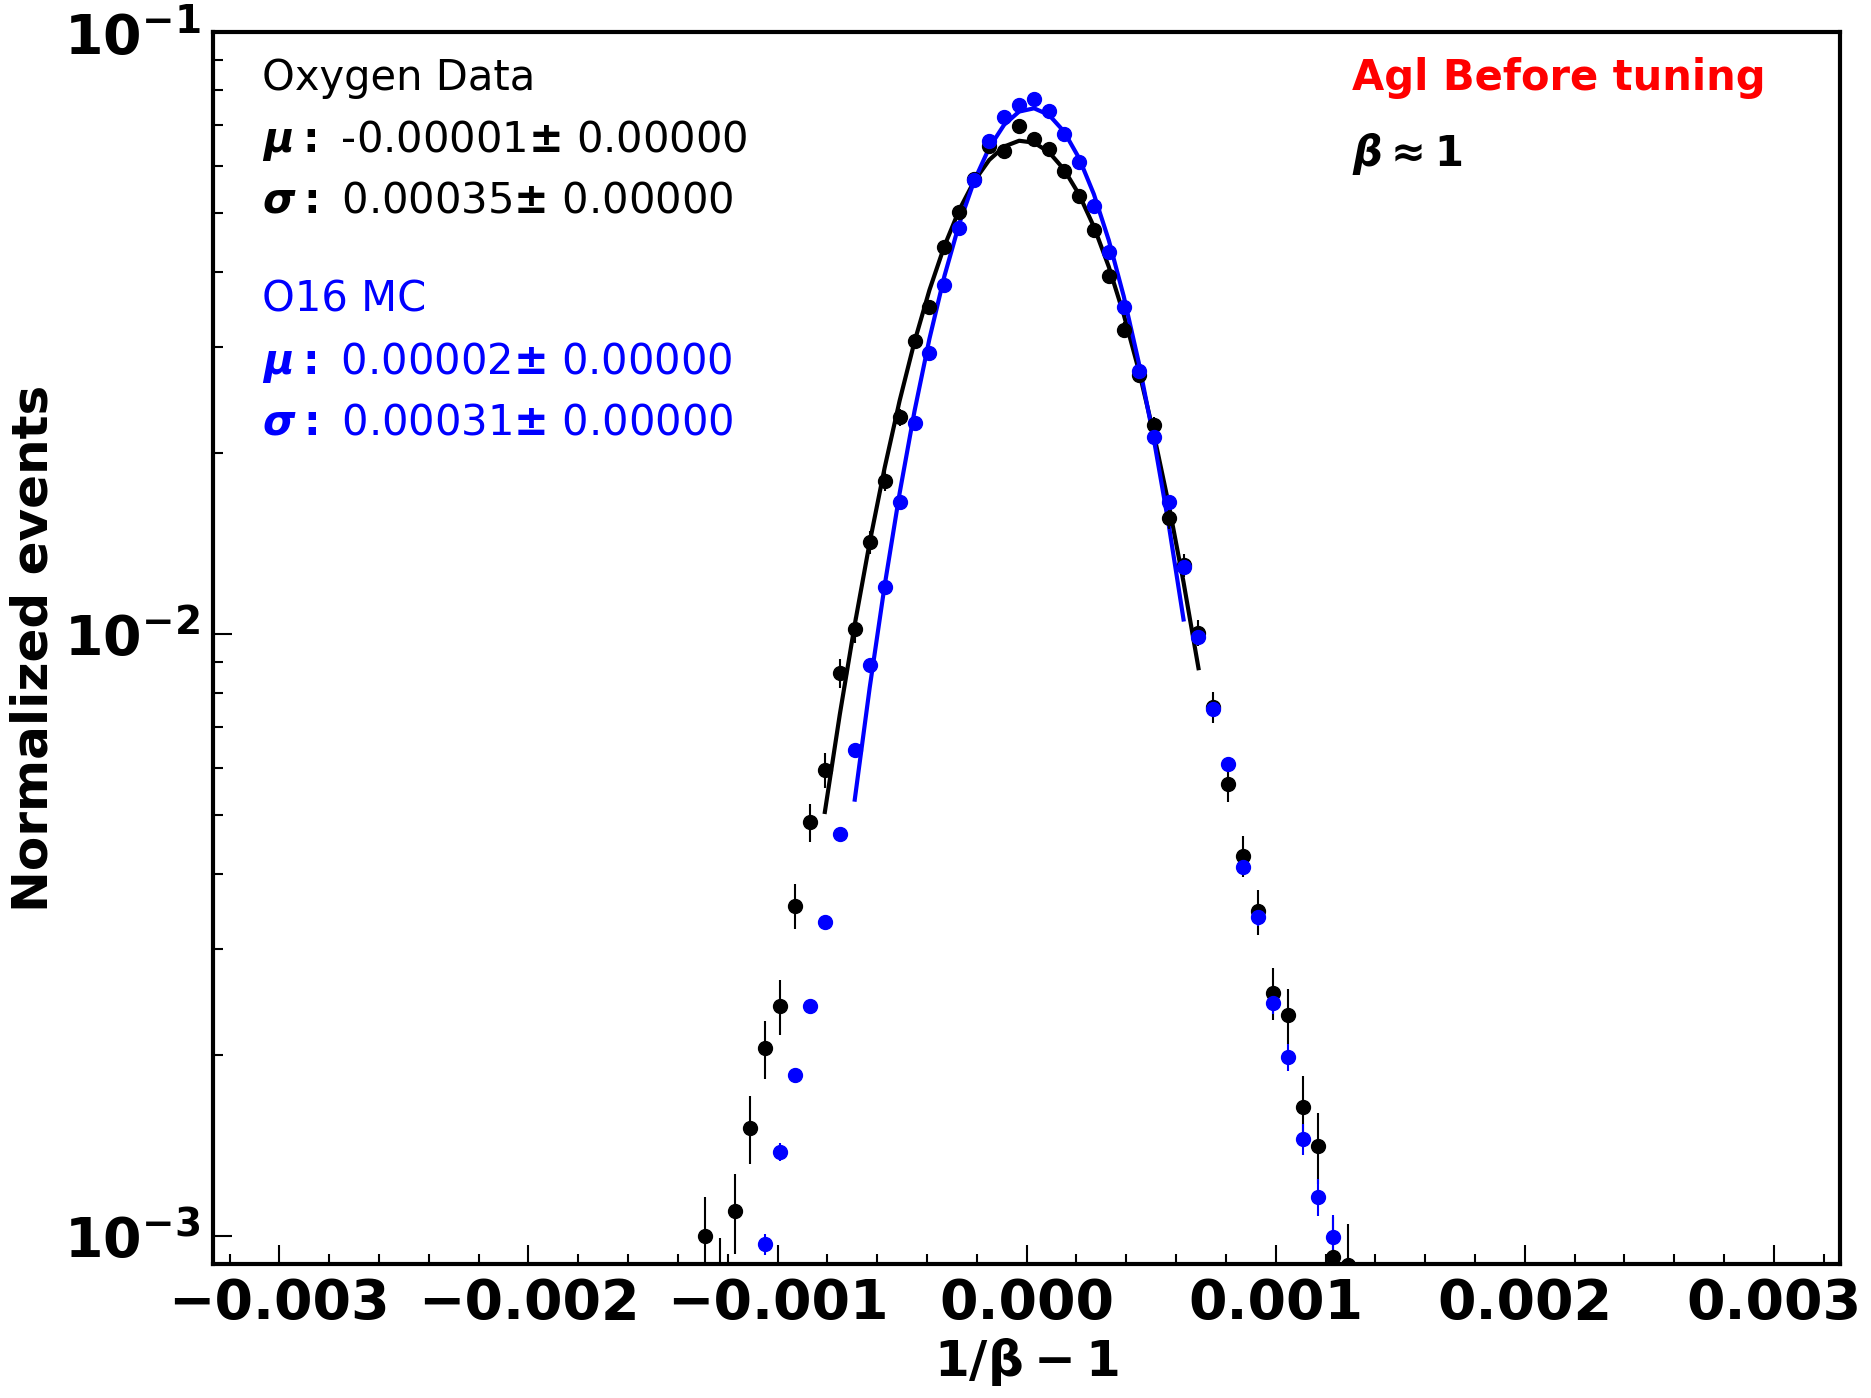

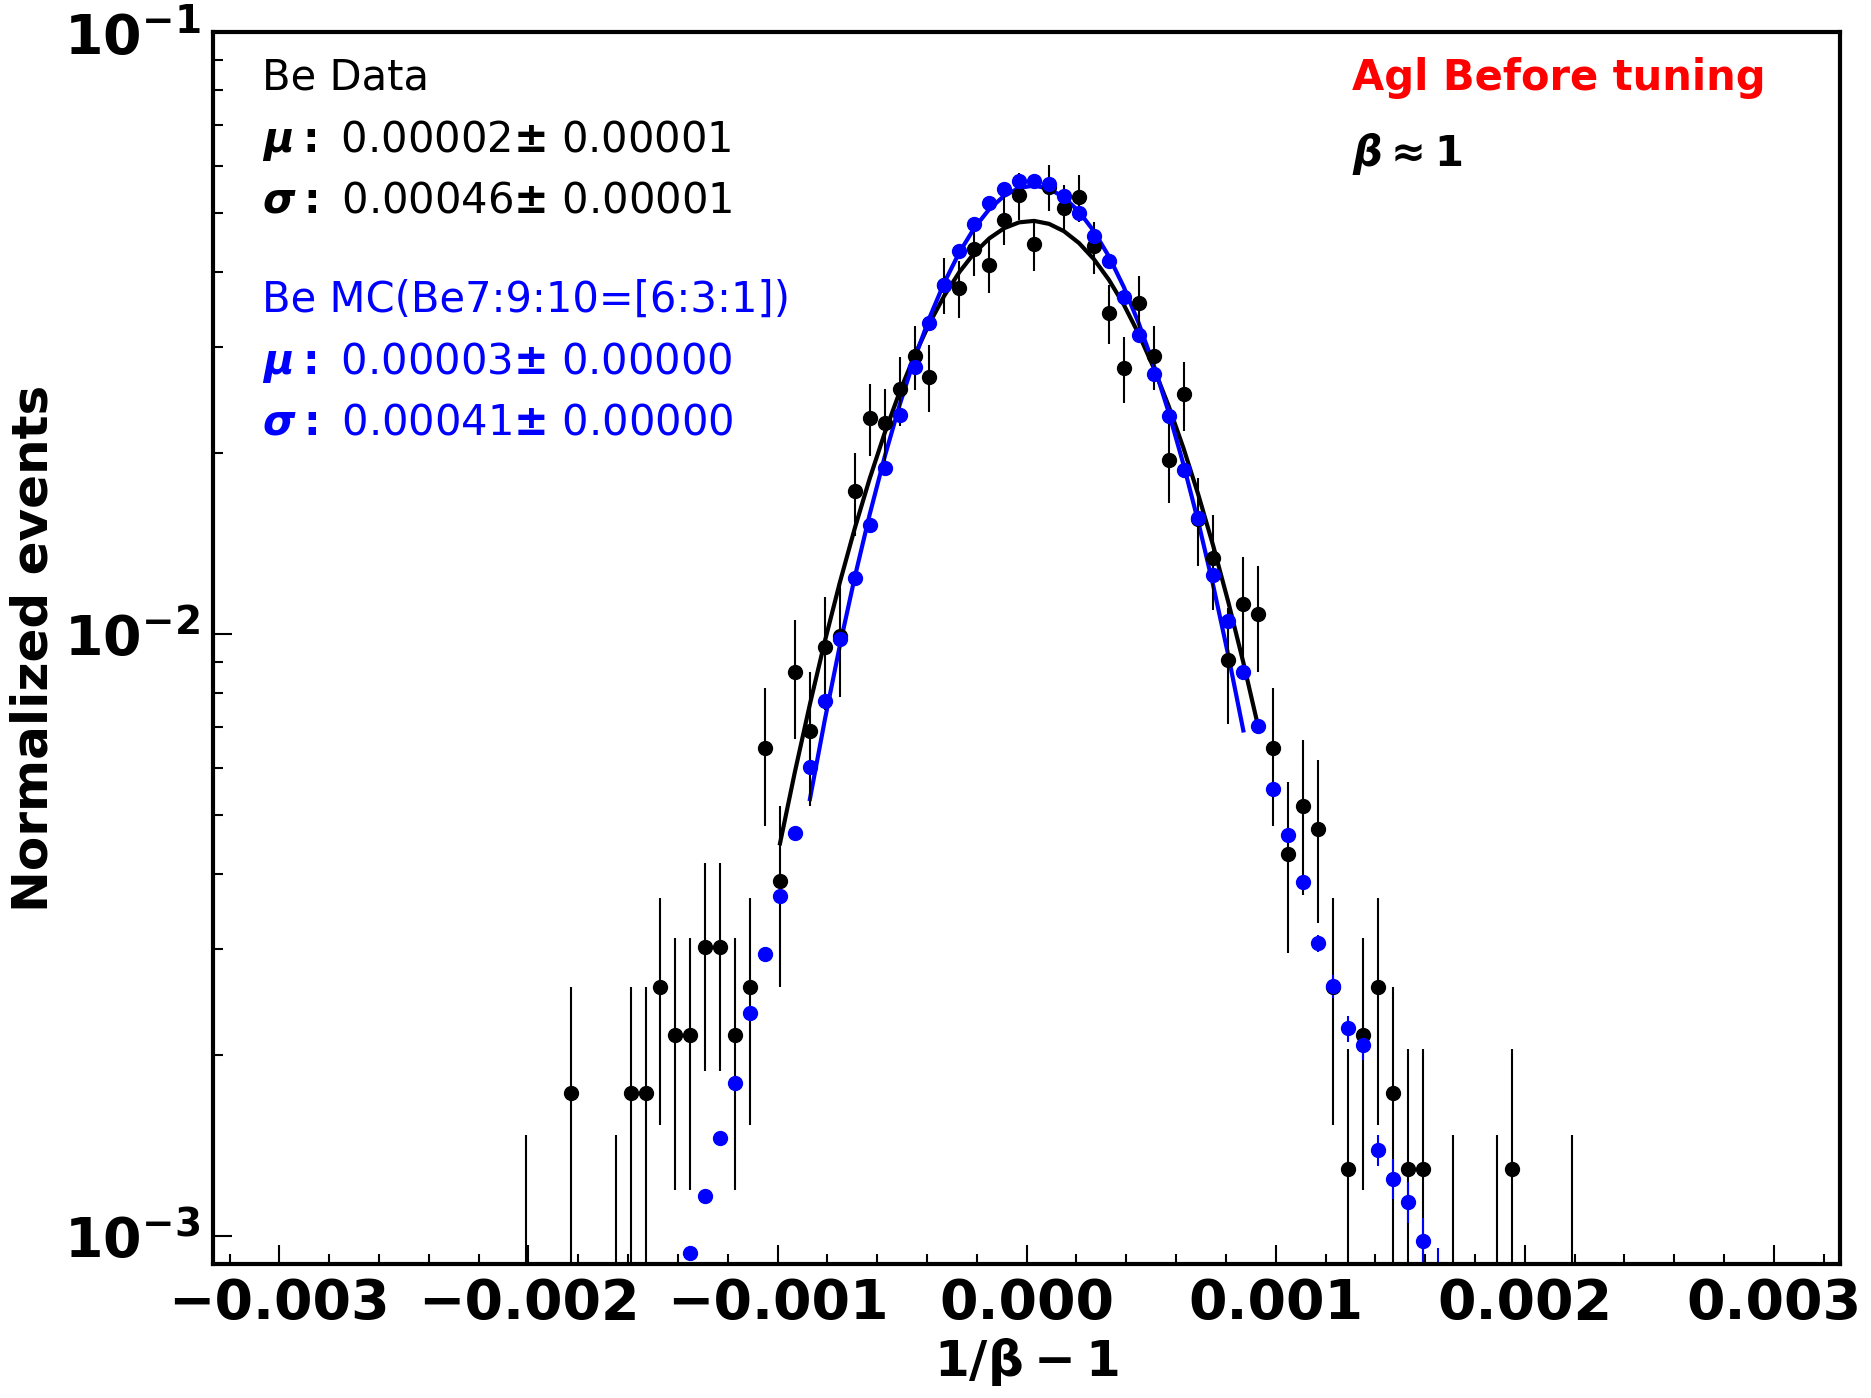

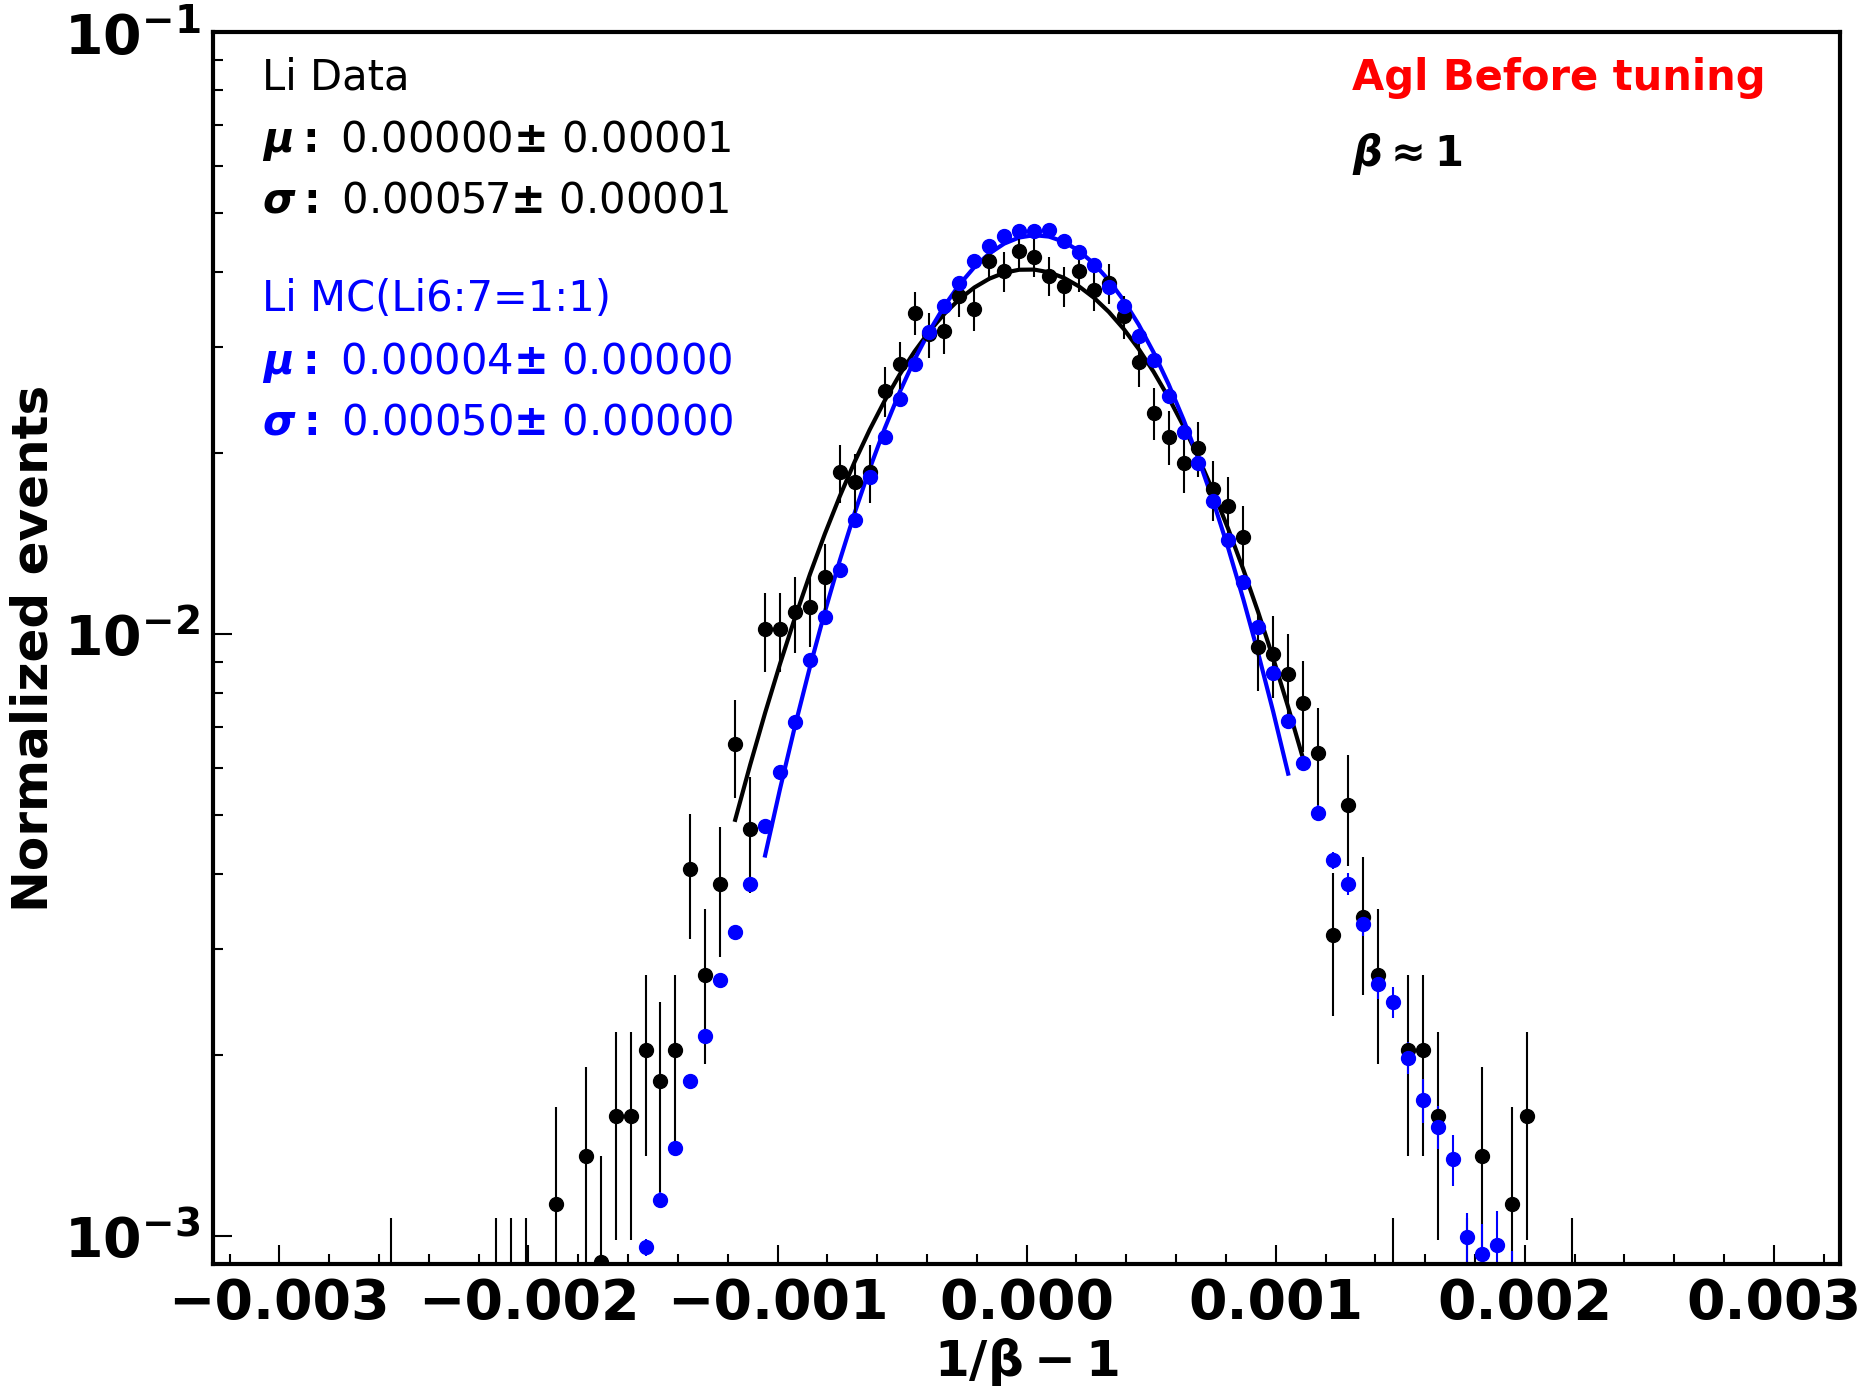

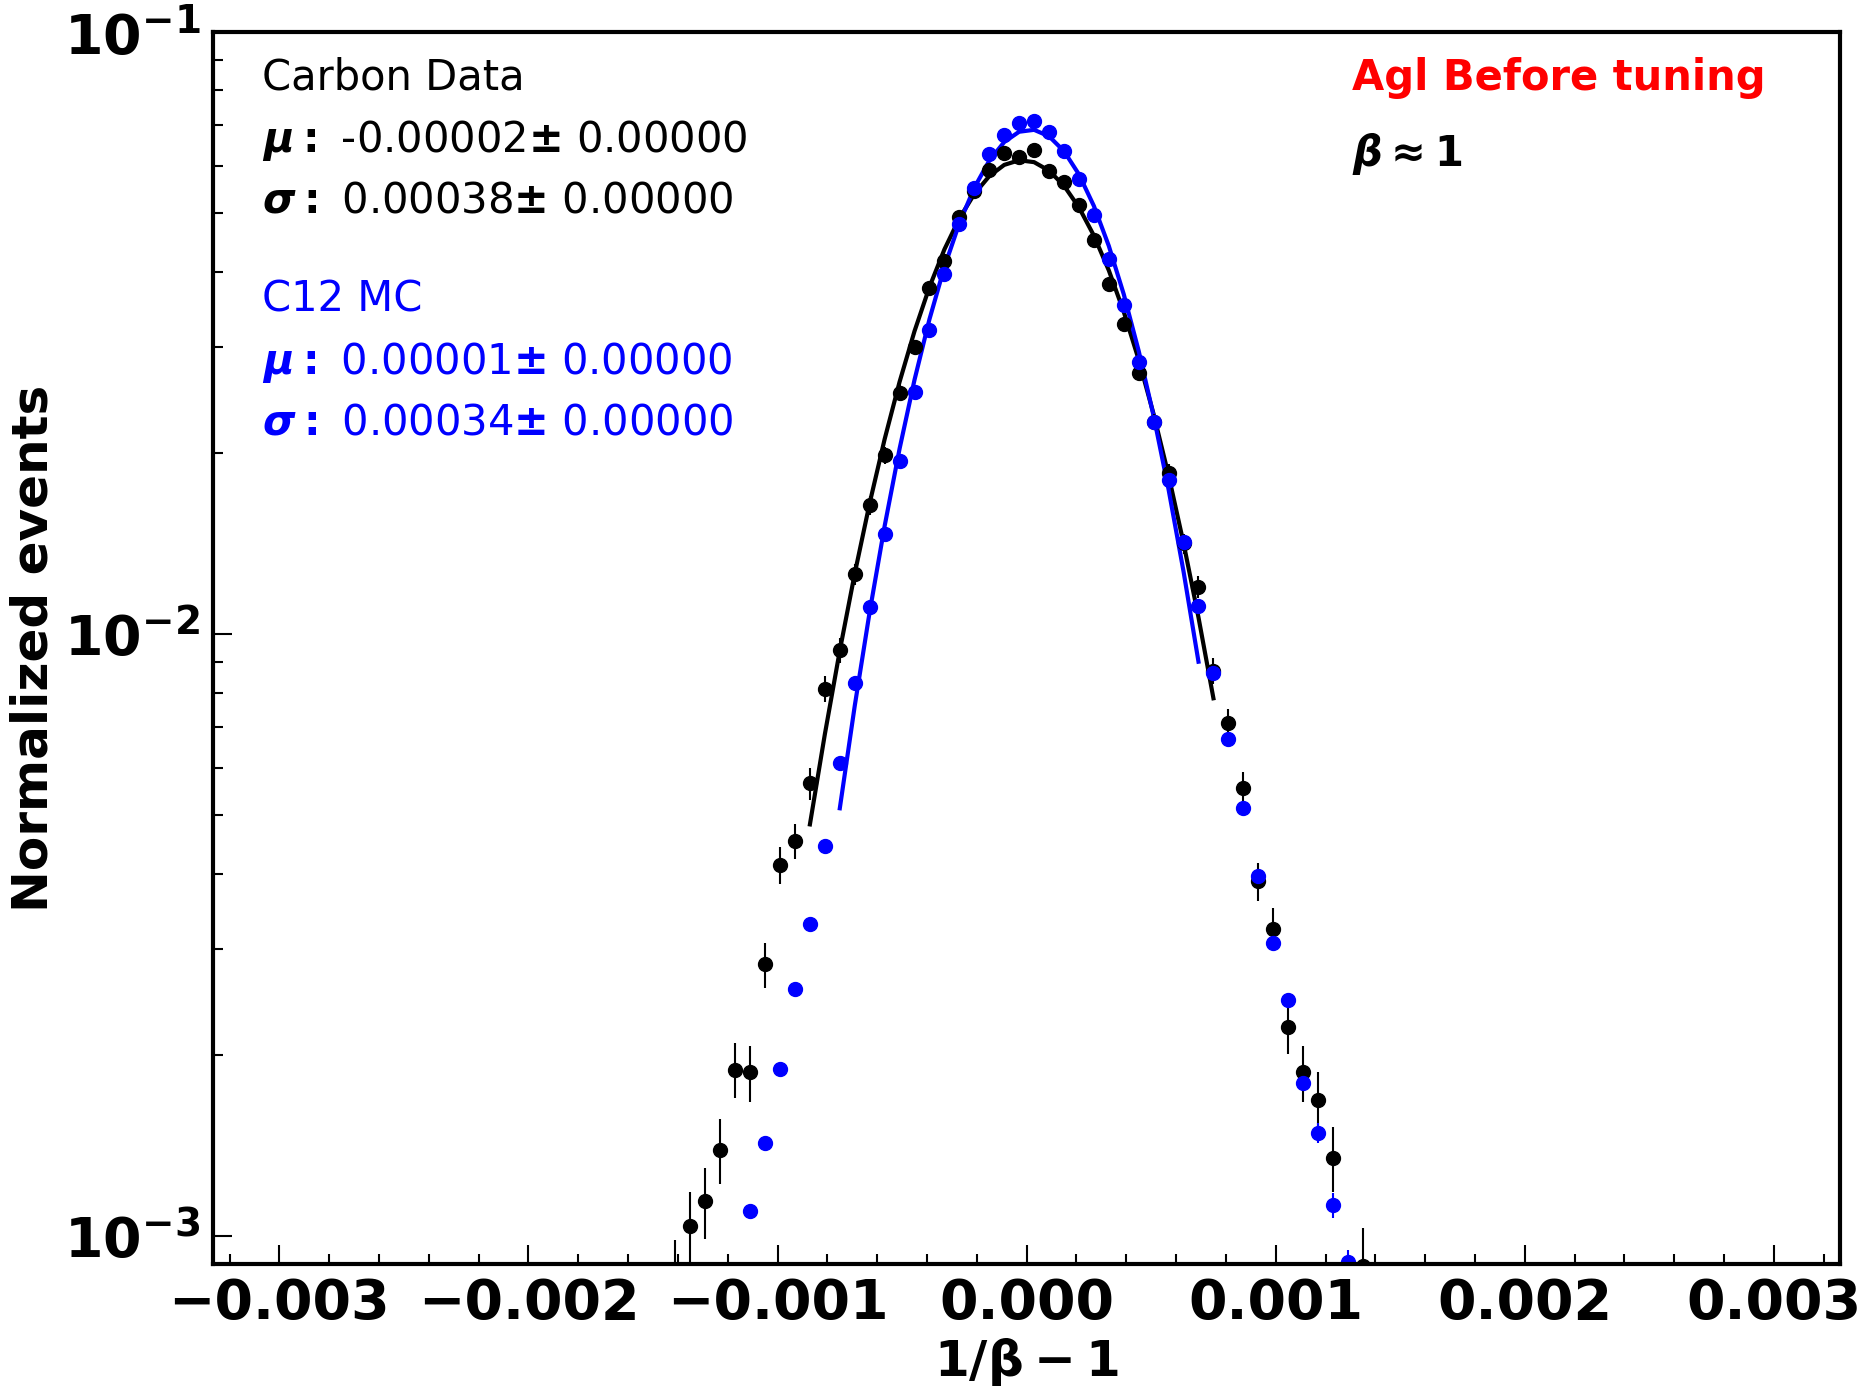

In [21]:
from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'Agl'

for nuclei in nuclei_names:
    isotopes = ISOTOPES[nuclei]
    ipoint = graph_meanvsz_iss[dec].get_index(NUCLEI_CHARGE[nuclei])
    print(nuclei, ipoint)

    xrange = {'mc': {"NaF": [-0.005, 0.005], 'Agl':[-0.0008, 0.00085]},
              'iss': {"NaF": [-0.005, 0.005], 'Agl':[-0.0008, 0.0008]}}
    xbinrange = {'iss': hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange['iss'][dec]),
                 'mc': hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange['mc'][dec])}


    xedges_iss = hist_issbeta_sv[nuclei][dec].binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
    xvalue_iss = hist_issbeta_sv[nuclei][dec].binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
    yvalue_iss = hist_issbeta_sv[nuclei][dec].values[xbinrange['iss'][0]:xbinrange['iss'][1]]
    yvalueserr_iss = np.sqrt(hist_issbeta_sv[nuclei][dec].squared_values[xbinrange['iss'][0]:xbinrange['iss'][1]])
    #yvalueserr_iss = np.sqrt(yvalue_iss)

    xedges_mc = hist_mcbeta[nuclei][dec].binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
    xvalue_mc = hist_mcbeta[nuclei][dec].binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
    yvalue_mc = hist_mcbeta[nuclei][dec].values[xbinrange['mc'][0]:xbinrange['mc'][1]] 

    yvalueserr_mc = np.sqrt(hist_mcbeta[nuclei][dec].squared_values[xbinrange['mc'][0]:xbinrange['mc'][1]])

    guess_iss = dict(counts=100, mu=0.0001, sigma=0.001, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
    guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.0005, sigma_ratio=2.0, fraction_sec=0.1)

    guess_gaus_iss = dict(norm=5.7240560387361177e-05, mu = -2.0668657490074533e-06, sigma= 0.0005)
    guess_gaus_mc = dict(norm=5.7240560387361177e-05, mu=0.00015061983073519196, sigma=0.0004737941993786251)
    #par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
    #par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                  
    par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
    par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)                                                                                                                                                                                    

    for key in guess_gaus_iss.keys():
        guess_gaus_iss[key] = par_iss[key]
        guess_gaus_mc[key] = par_mc[key]
    
    xrange_iter2 = [guess_gaus_iss['mu'] - 2.2 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 2.2* guess_gaus_iss['sigma']]
    xrange_iter2_mc = [guess_gaus_mc['mu'] - 2.2 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.2 * guess_gaus_mc['sigma']]
    xbinrange2 = hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange_iter2)
    xbinrange2mc = hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange_iter2_mc)
    
    xedges_iss = hist_issbeta_sv[nuclei][dec].binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
    xvalue_iss = hist_issbeta_sv[nuclei][dec].binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
    yvalue_iss = hist_issbeta_sv[nuclei][dec].values[xbinrange2[0]:xbinrange2[1]]
    yvalueserr_iss = np.sqrt(hist_issbeta_sv[nuclei][dec].squared_values[xbinrange2[0]:xbinrange2[1]])
    #yvalueserr_iss = np.sqrt(yvalue_iss)  

    xedges_mc = hist_mcbeta[nuclei][dec].binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
    xvalue_mc = hist_mcbeta[nuclei][dec].binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
    yvalue_mc = hist_mcbeta[nuclei][dec].values[xbinrange2mc[0]:xbinrange2mc[1]]
    yvalueserr_mc = np.sqrt(hist_mcbeta[nuclei][dec].squared_values[xbinrange2mc[0]:xbinrange2mc[1]])

    par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
    par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)

    Fill_Graph_Points(graph_meanvsz_iss[dec], graph_sigmavsz_iss[dec], par_iss, parerr_iss, ipoint)
    Fill_Graph_Points(graph_meanvsz_mc[dec], graph_sigmavsz_mc[dec], par_mc, parerr_mc, ipoint)

    fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
    fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                

    fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
    set_plot_style(ax3)
    ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color=isscolor)
    ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color=mccolor)
    plot_histogram_1d(ax3, hist_issbeta_sv[nuclei][dec], style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    plot_histogram_1d(ax3, hist_mcbeta[nuclei][dec], style="iss", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)

    if useTunedBeta:
        ax3.text(0.7, 0.98, f"{dec} After tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold")
    else:
        ax3.text(0.7, 0.98, f"{dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold") 
    
    ax3.text(0.7, 0.92, r"$\beta \approx 1$", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
    #if isbeta1:
    #    ax3.text(0.7, 0.86, f"(Uniformity Correction)", fontsize=FONTSIZE-5, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
    #else:
    #    ax3.text(0.65, 0.86, f"(Uniformity+New Correction)", fontsize=FONTSIZE-5, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
    fit_info = [f"$\\mu$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}"]

    ax3.text(0.03, 0.98, f'{nucleiname[nuclei]} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    ax3.text(0.03, 0.93, f"$\\mu:$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    ax3.text(0.03, 0.88, f"$\\sigma:$ {par_iss['sigma']:.5f}$\\pm$ {parerr_iss['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    ax3.set_ylim([0.0009, 0.1])


    ax3.text(0.03, 0.8, f'{MCNameText[nuclei]}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal') 

    #ax3.text(0.03, 0.8, f'{MCName} MC(B10:B11=[1:1])', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.text(0.03, 0.75, f"$\\mu:$ {par_mc['mu']:.5f}$\\pm$ {parerr_mc['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.text(0.03, 0.7, f"$\\sigma:$ {par_mc['sigma']:.5f}$\\pm$ {parerr_mc['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.set_ylabel('Normalized events')
    ax3.set_xlabel(r'$\mathrm{1/\beta - 1}$')
    #plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate_08012024'
    savefig_tofile(fig3, plotfile, f"{dec}_beta_highR_{nucleiname[nuclei]}_{figsuffix}", show=True) 


N 4
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR
B 2
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR
O 5
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR
Be 1
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR
Li 0
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR
C 3
/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


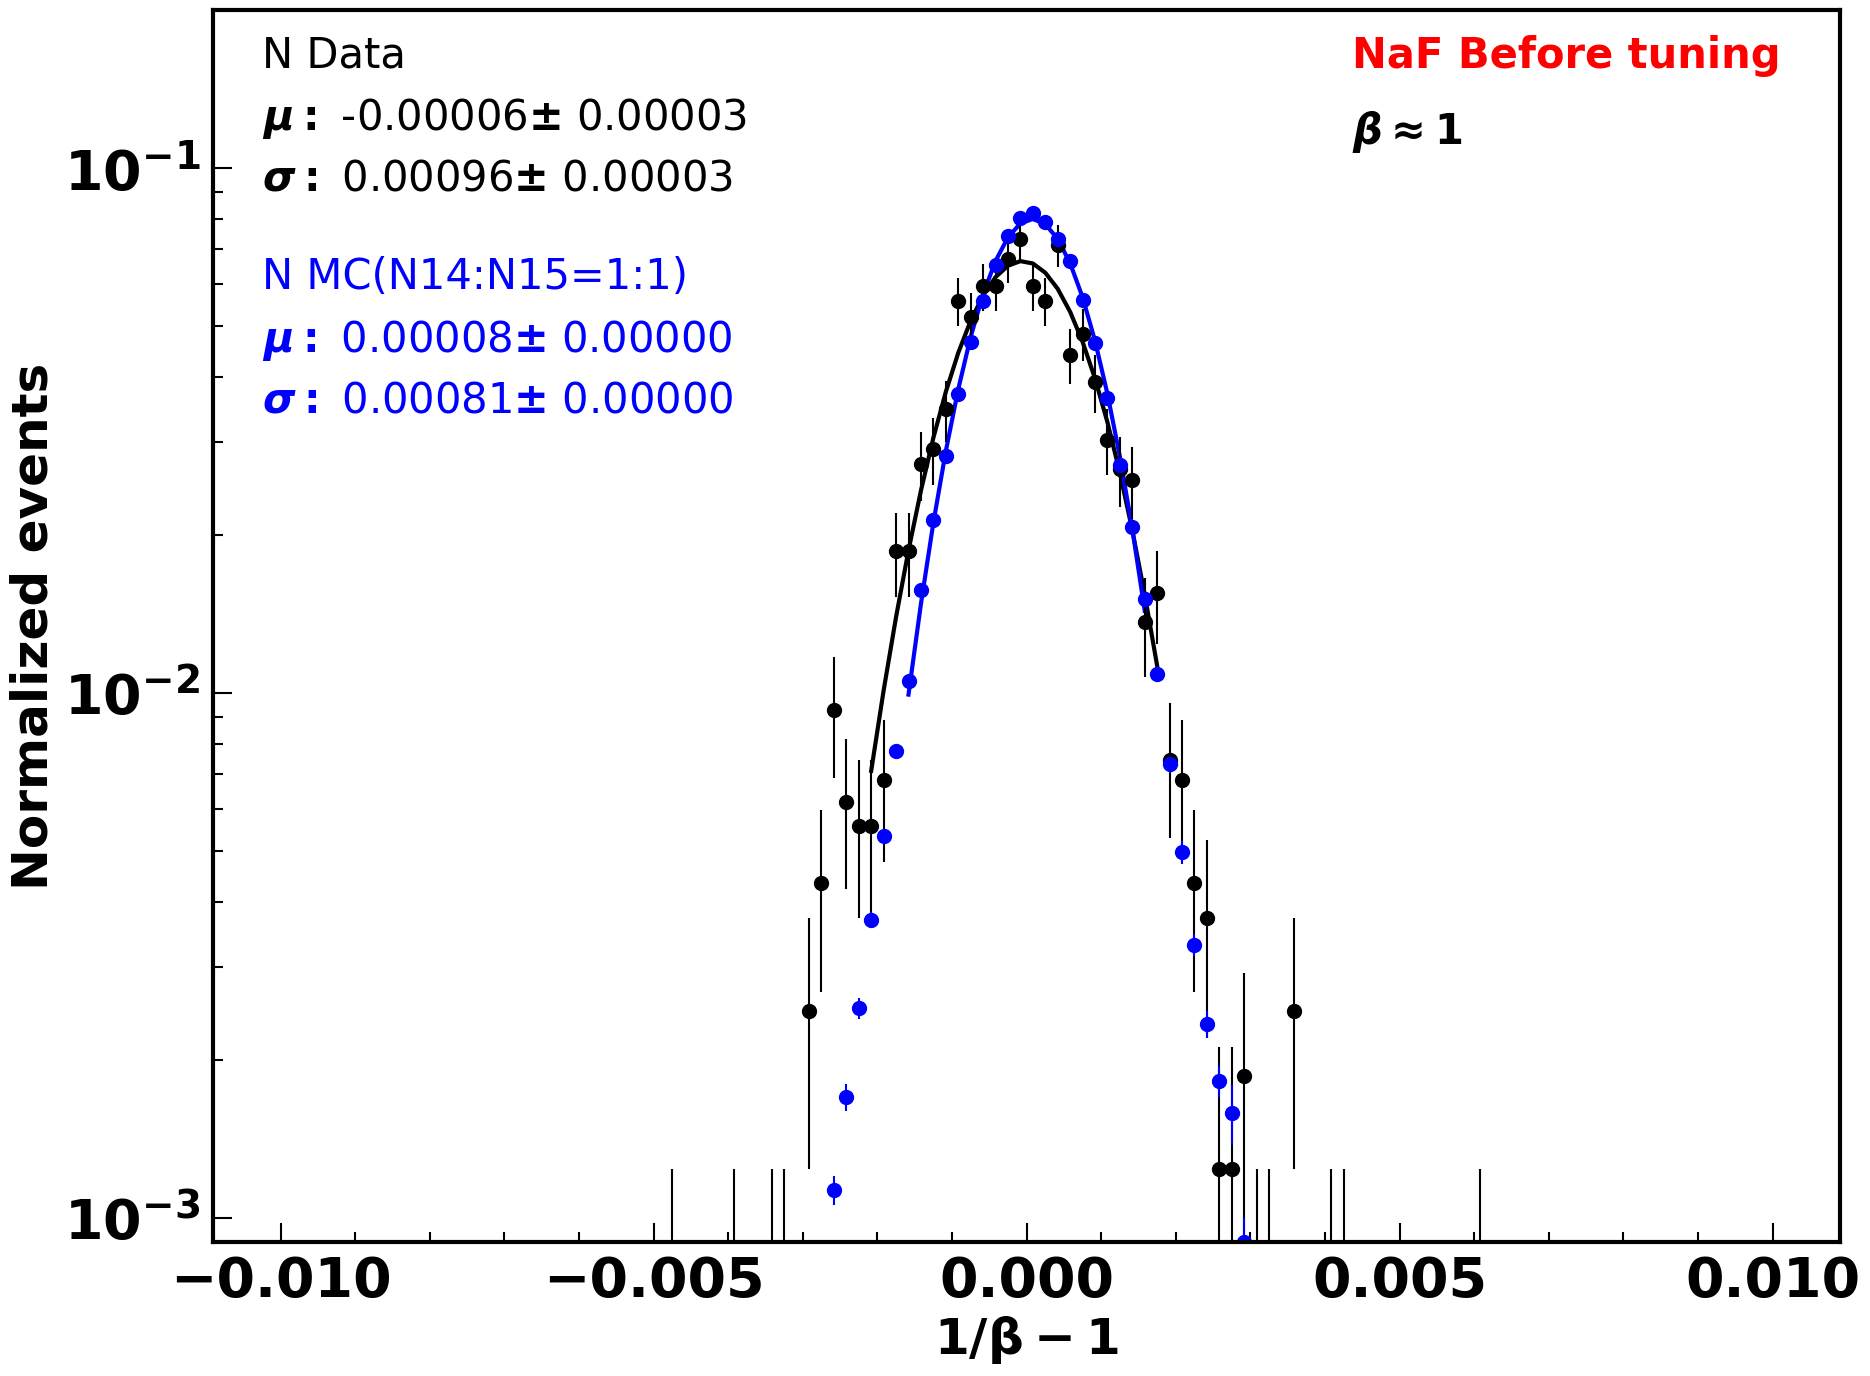

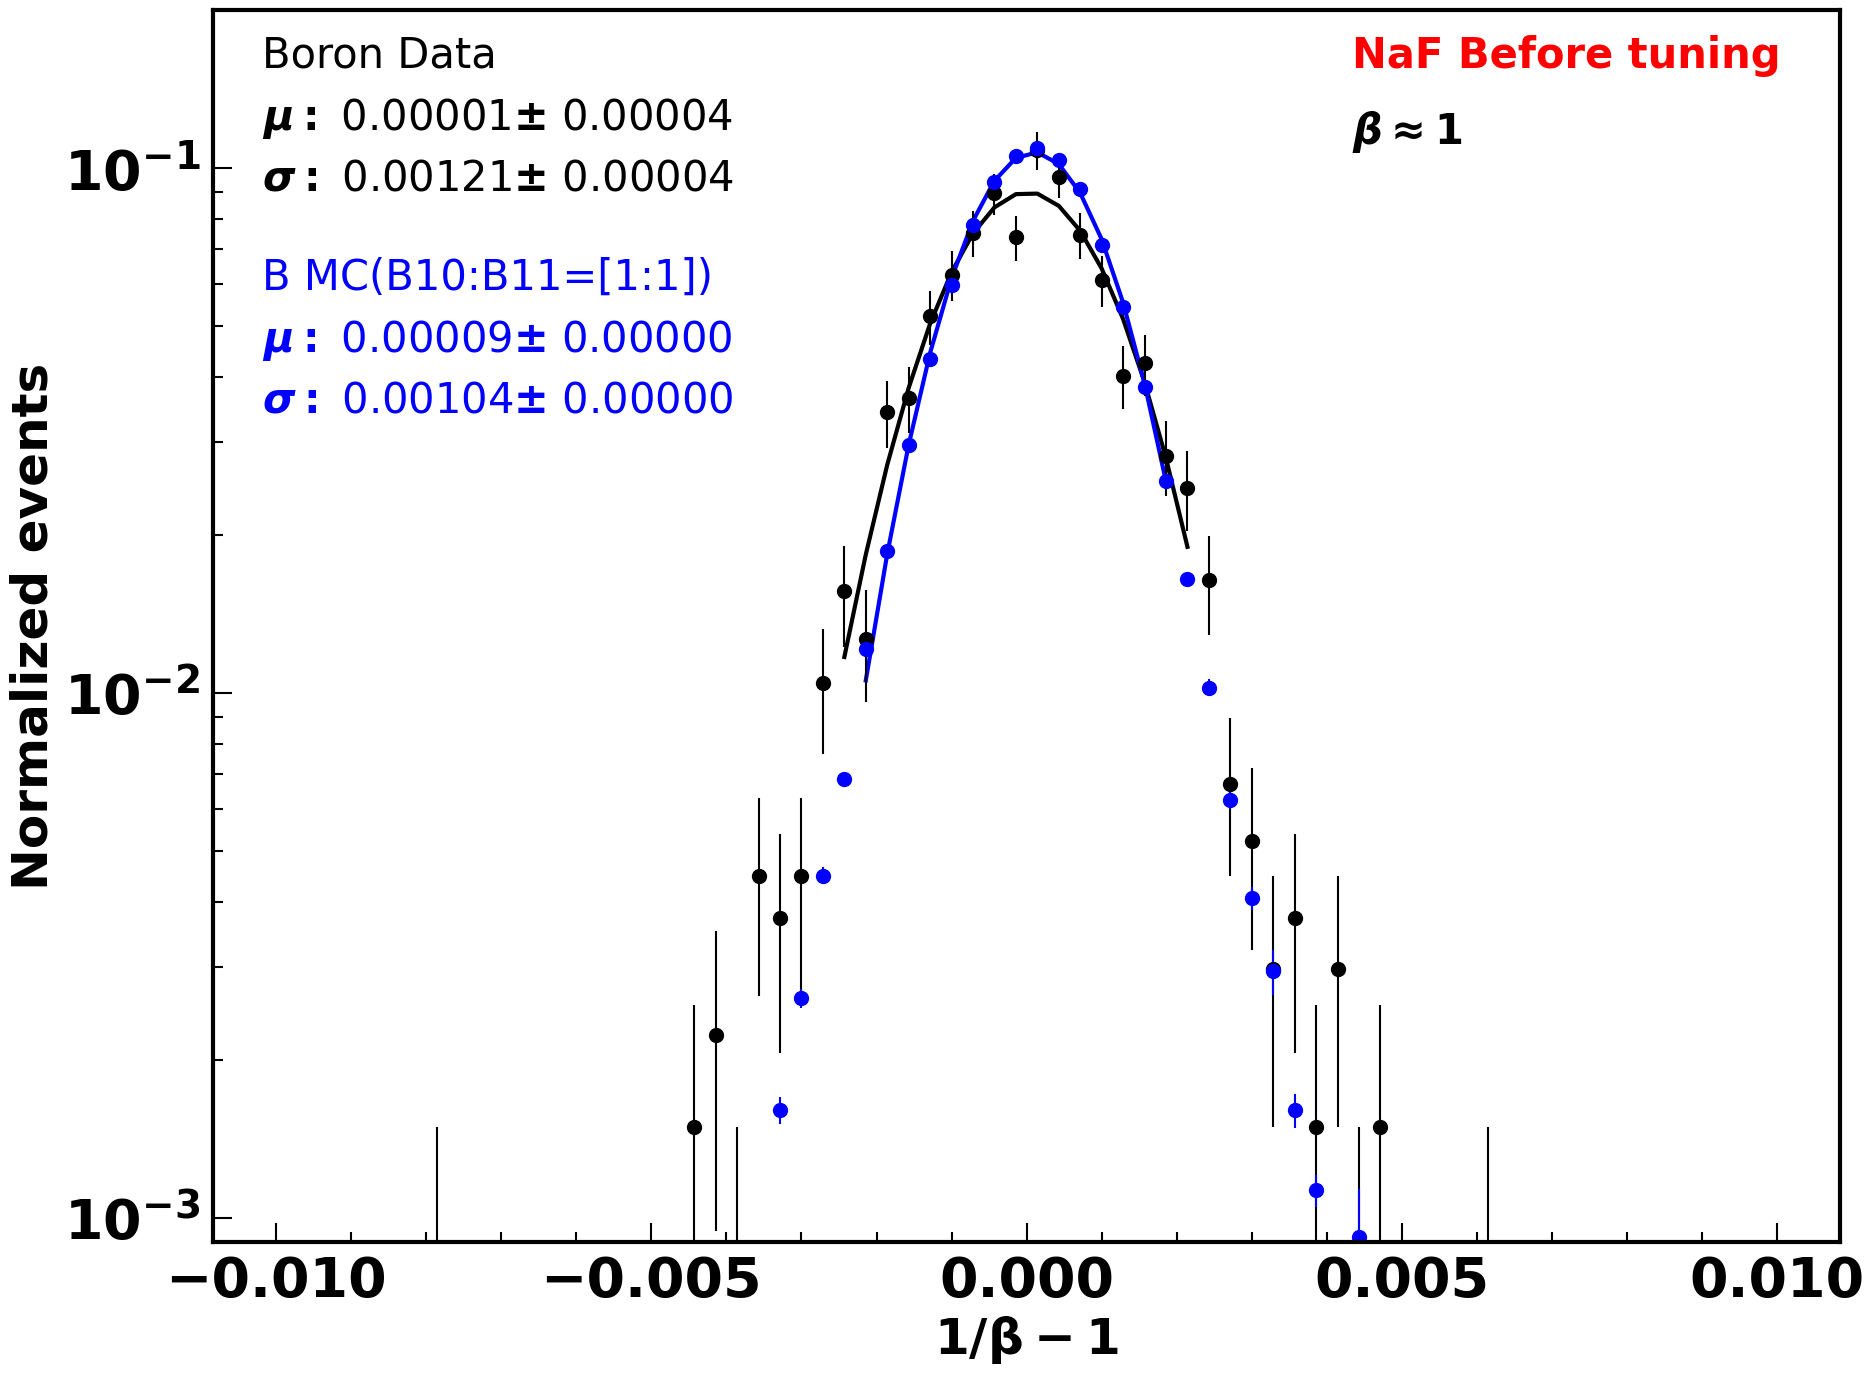

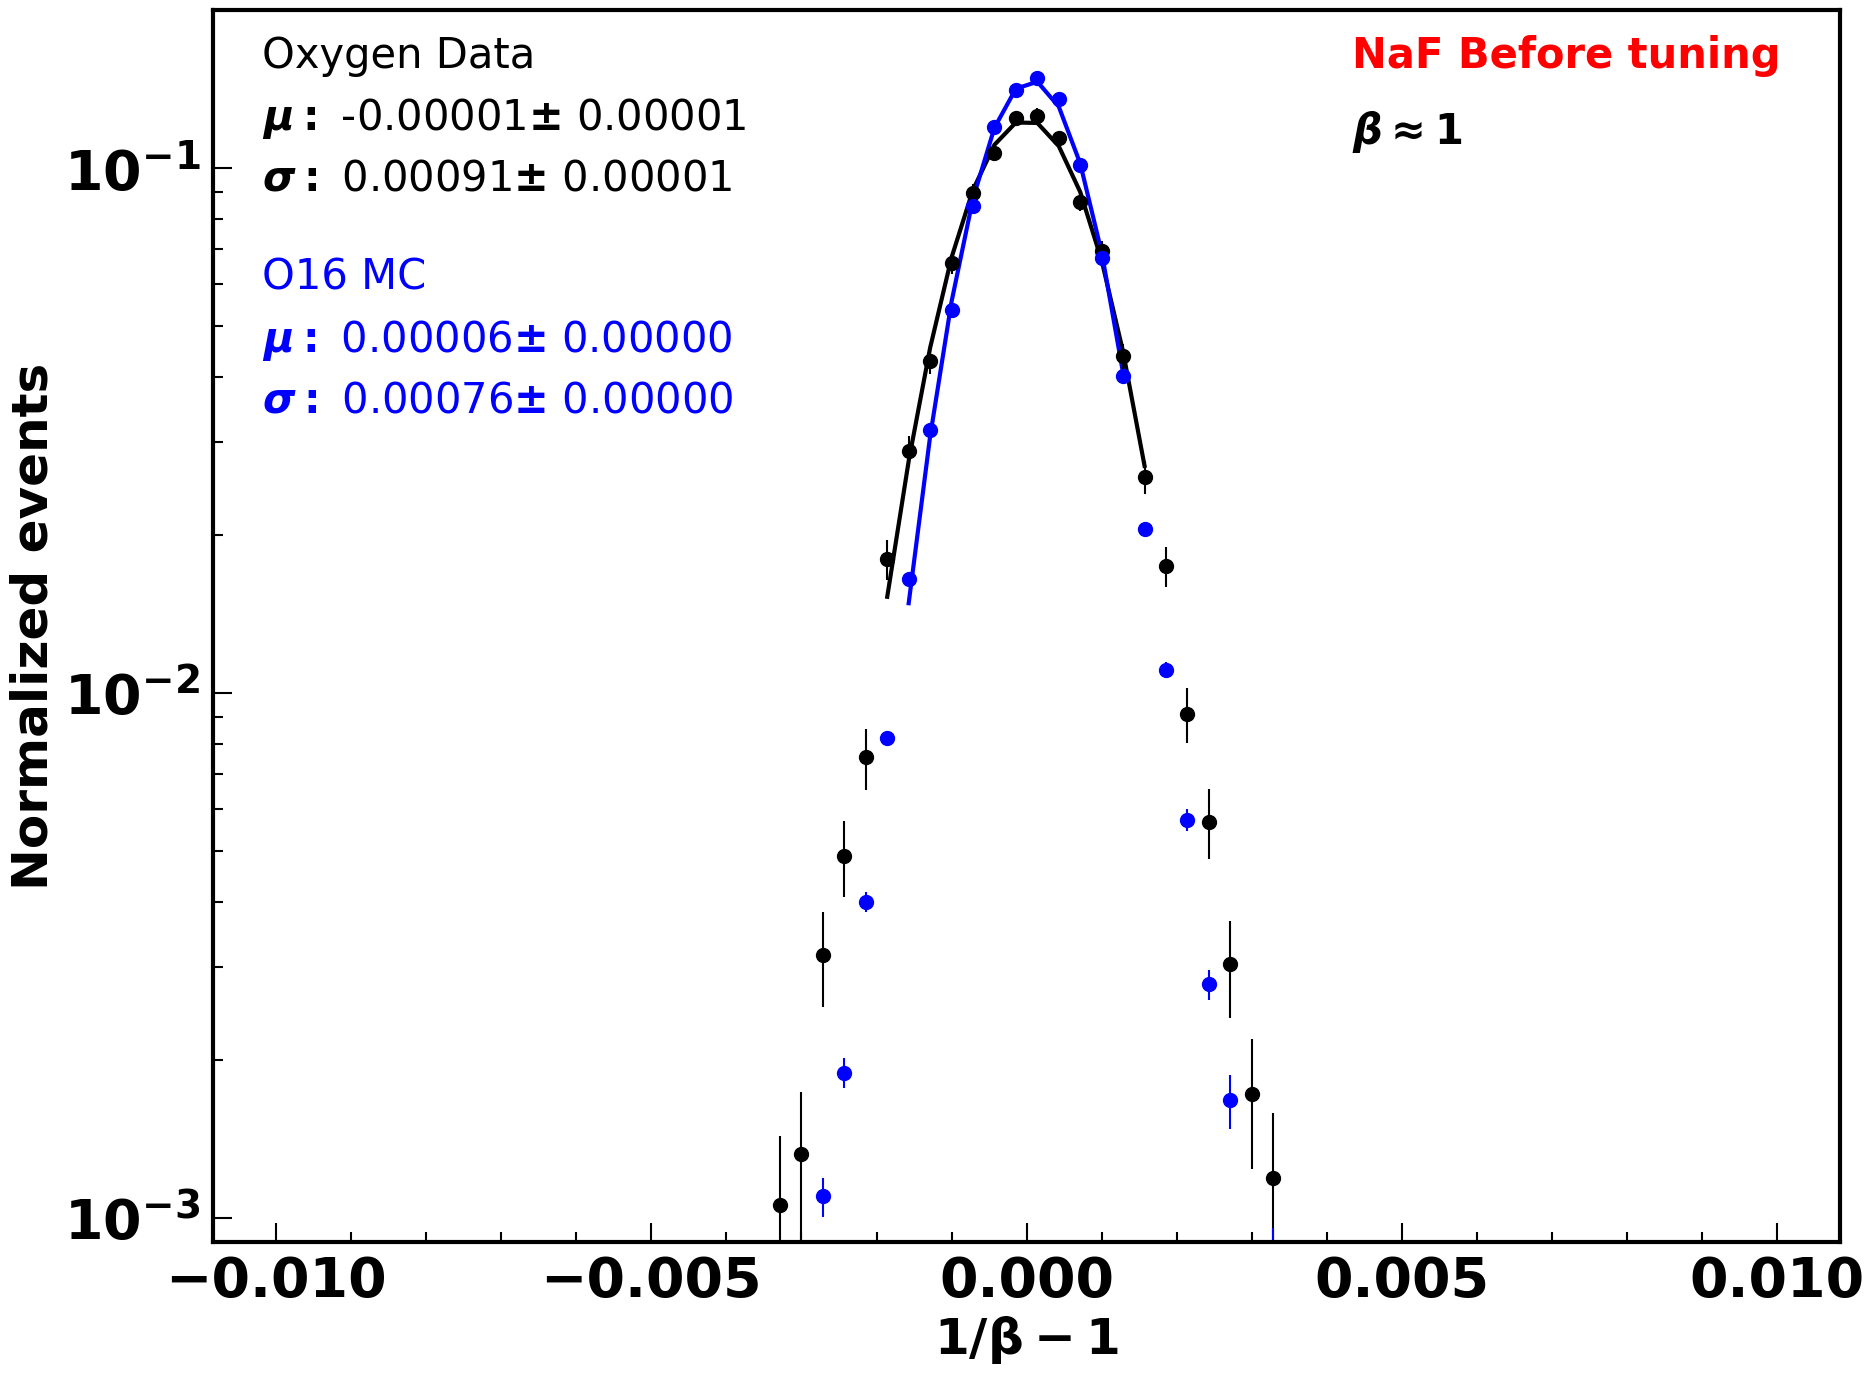

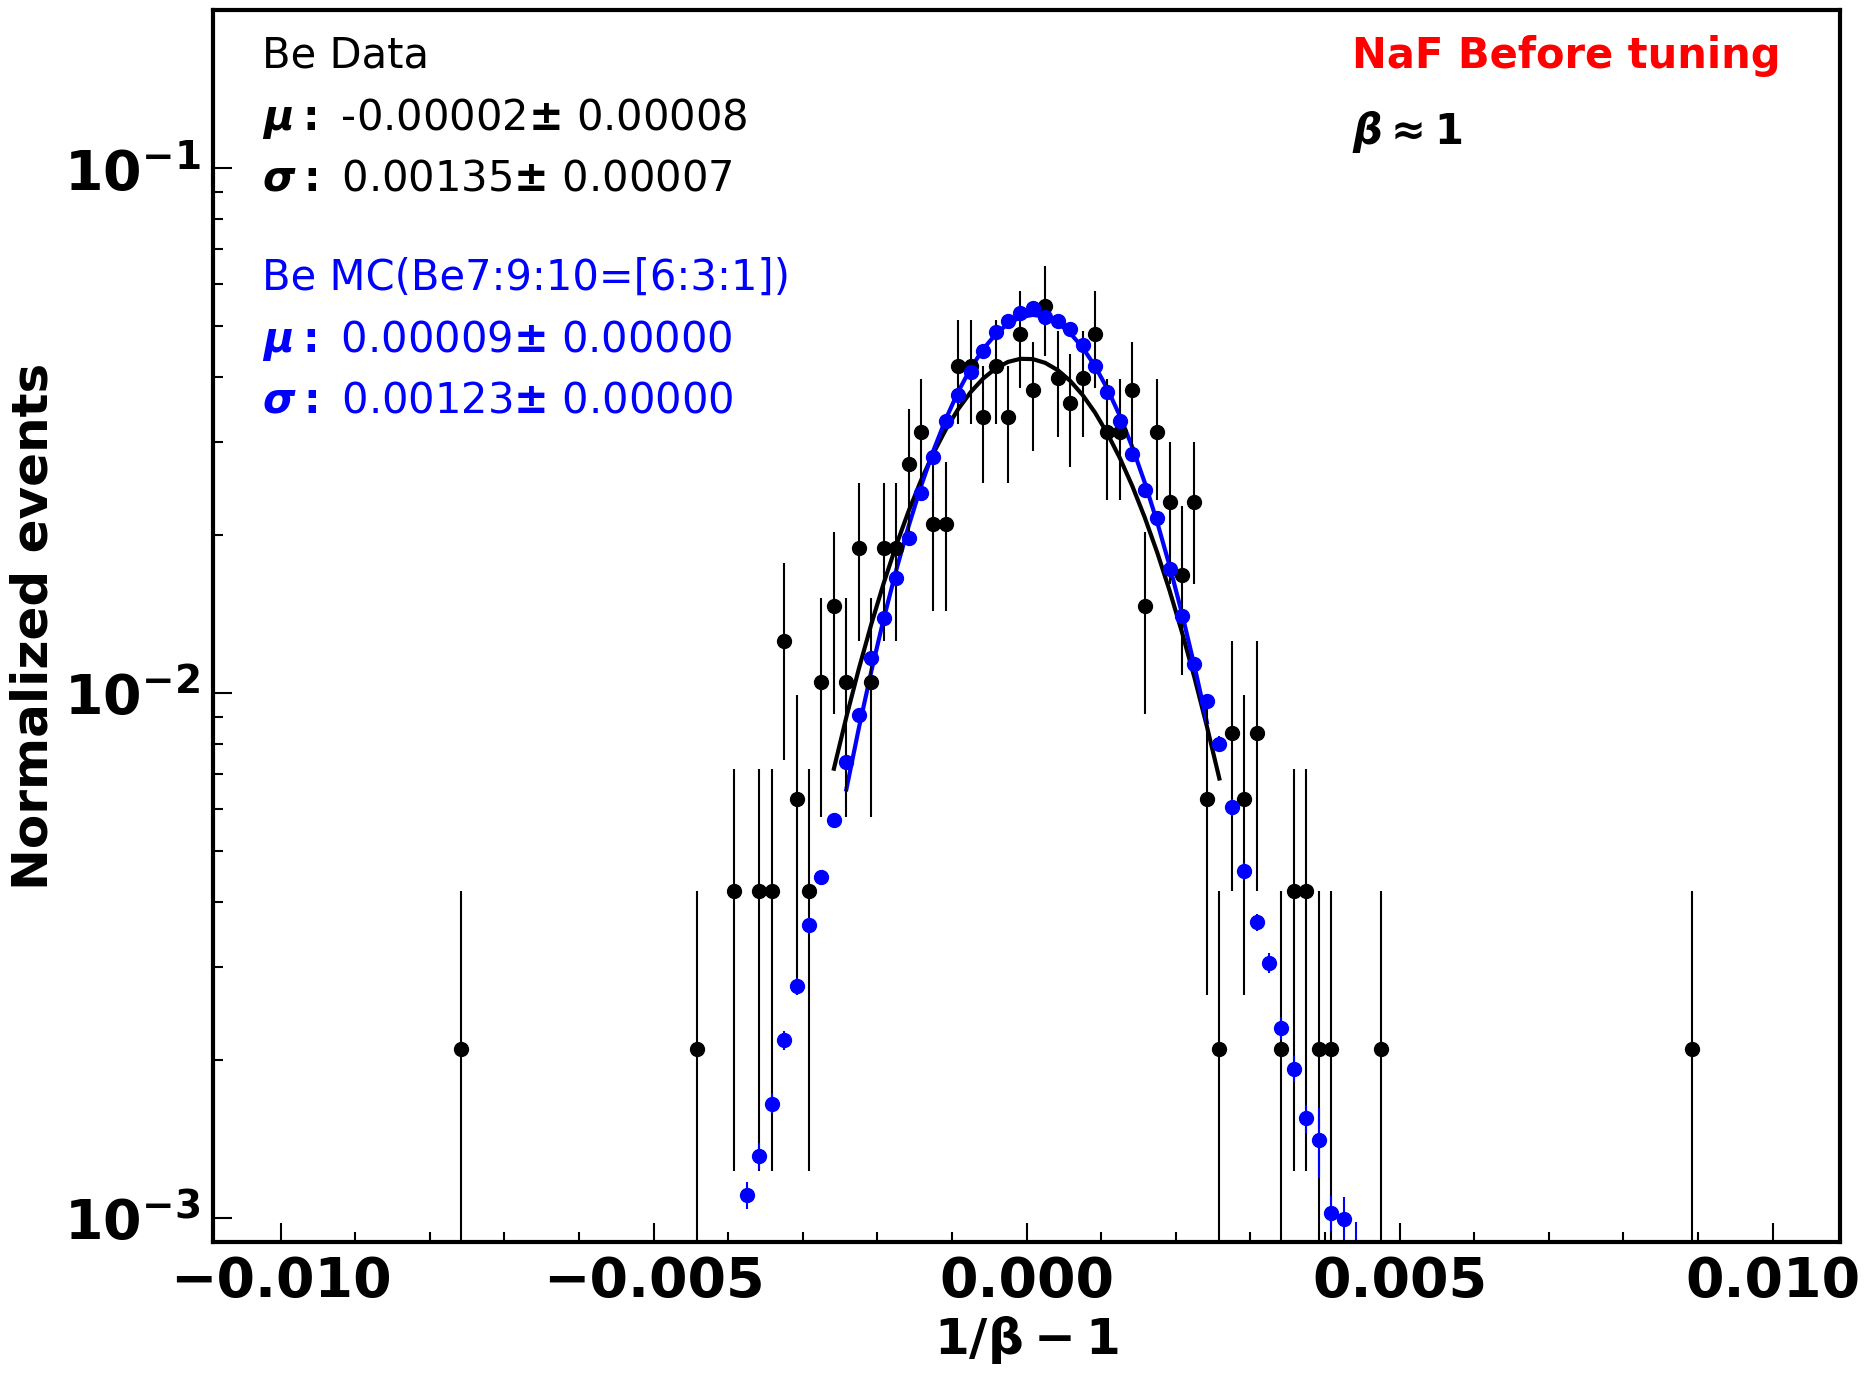

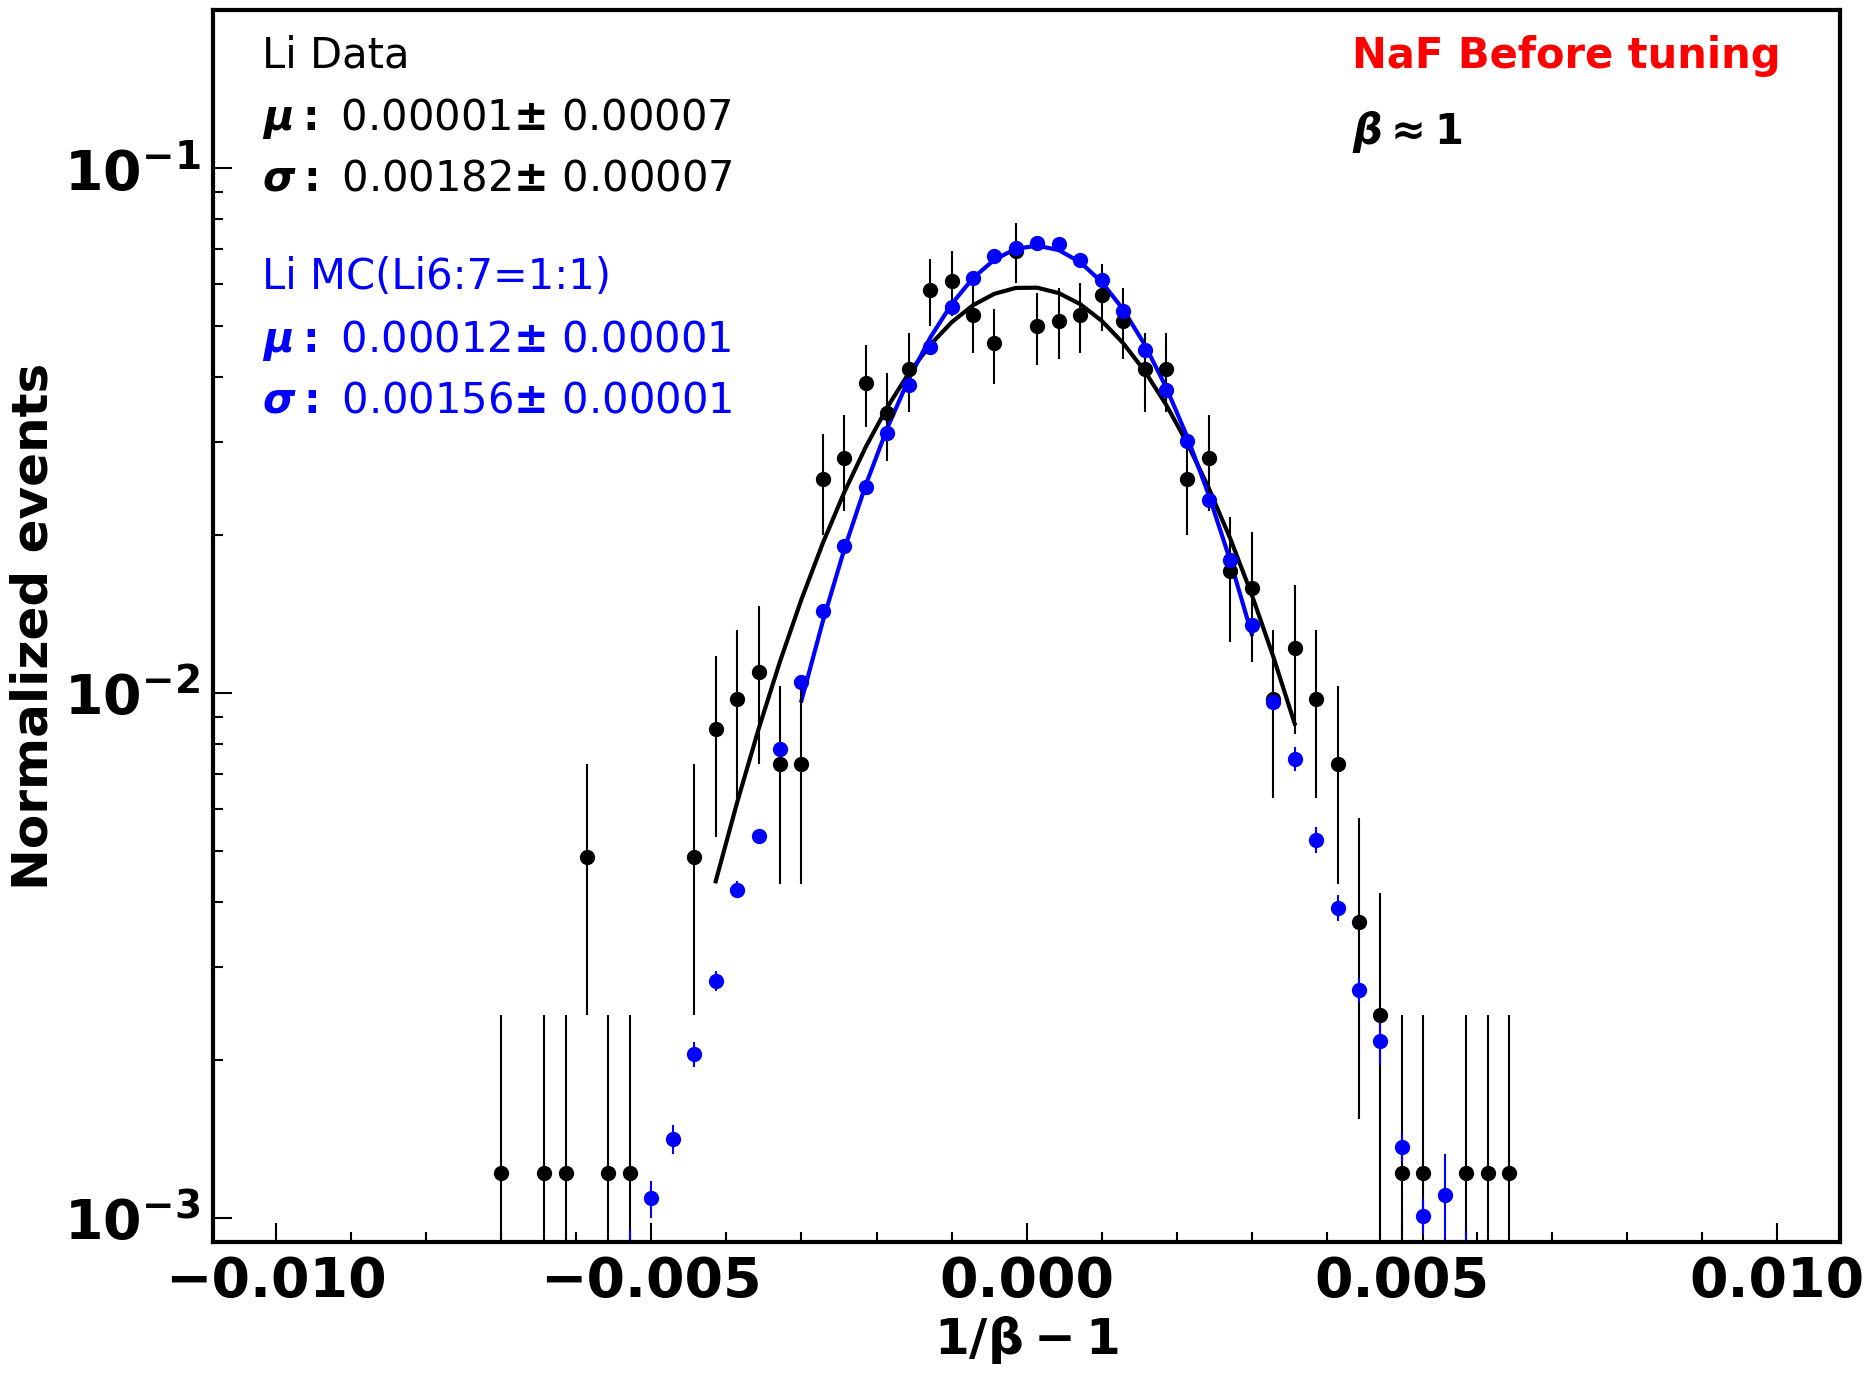

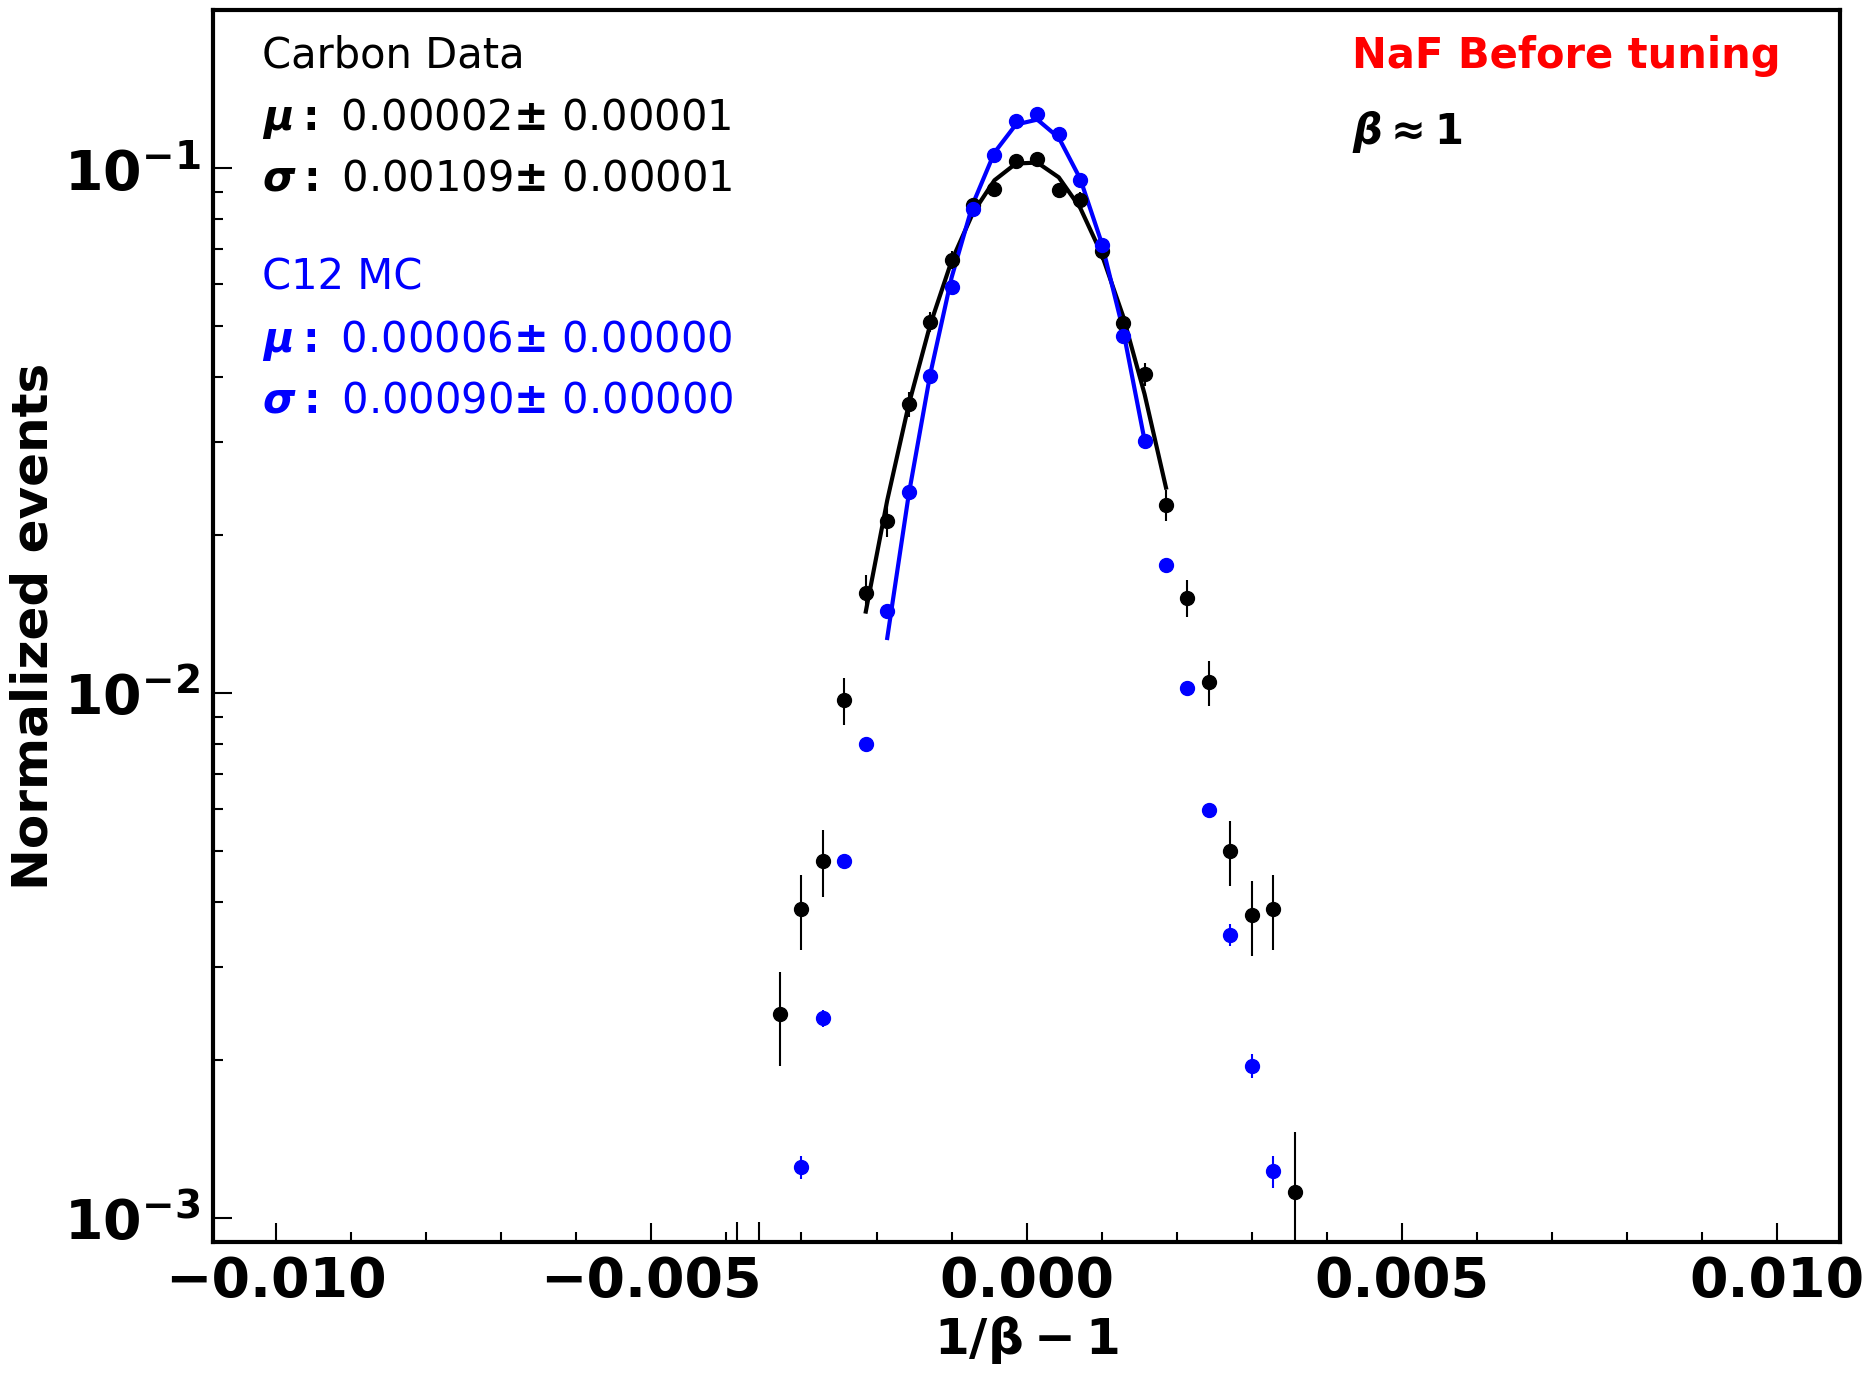

In [22]:
from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'NaF'

for nuclei in nuclei_names:
    isotopes = ISOTOPES[nuclei]
    ipoint = graph_meanvsz_iss[dec].get_index(NUCLEI_CHARGE[nuclei])
    print(nuclei, ipoint)

    xrange = {'mc': {"Tof": [-0.003, 0.003], "NaF": [-0.0023, 0.0028], 'Agl':[-0.00065, 0.00095]},
          'iss': {"Tof": [-0.003, 0.003], "NaF": [-0.0025, 0.0028], 'Agl':[-0.0008, 0.0008]}}
    
    xbinrange = {'iss': hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange['iss'][dec]),
                 'mc': hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange['mc'][dec])}


    xedges_iss = hist_issbeta_sv[nuclei][dec].binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
    xvalue_iss = hist_issbeta_sv[nuclei][dec].binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
    yvalue_iss = hist_issbeta_sv[nuclei][dec].values[xbinrange['iss'][0]:xbinrange['iss'][1]]
    yvalueserr_iss = np.sqrt(hist_issbeta_sv[nuclei][dec].squared_values[xbinrange['iss'][0]:xbinrange['iss'][1]])
    #yvalueserr_iss = np.sqrt(yvalue_iss)

    xedges_mc = hist_mcbeta[nuclei][dec].binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
    xvalue_mc = hist_mcbeta[nuclei][dec].binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
    yvalue_mc = hist_mcbeta[nuclei][dec].values[xbinrange['mc'][0]:xbinrange['mc'][1]] 

    yvalueserr_mc = np.sqrt(hist_mcbeta[nuclei][dec].squared_values[xbinrange['mc'][0]:xbinrange['mc'][1]])
    guess_iss = dict(counts=100, mu=0.0001, sigma=0.001, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
    guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.0005, sigma_ratio=2.0, fraction_sec=0.1)
    guess_gaus_iss = dict(norm=0.0002769178989665516, mu=-0.0001850360763378543, sigma=0.001)
    guess_gaus_mc = dict(norm=0.0002802964351902568, mu=0.00015778040618018424, sigma=0.0008)
   
    #par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
    #par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                  
    par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
    par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)                                                                                                                                                                                    

    for key in guess_gaus_iss.keys():
        guess_gaus_iss[key] = par_iss[key]
        guess_gaus_mc[key] = par_mc[key]
    
    xrange_iter2 = [guess_gaus_iss['mu'] - 2.0 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 2.0* guess_gaus_iss['sigma']]
    xrange_iter2_mc = [guess_gaus_mc['mu'] - 2.0 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.0 * guess_gaus_mc['sigma']]
    xbinrange2 = hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange_iter2)
    xbinrange2mc = hist_issbeta_sv[nuclei][dec].binnings[0].get_indices(xrange_iter2_mc)
    
    xedges_iss = hist_issbeta_sv[nuclei][dec].binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
    xvalue_iss = hist_issbeta_sv[nuclei][dec].binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
    yvalue_iss = hist_issbeta_sv[nuclei][dec].values[xbinrange2[0]:xbinrange2[1]]
    yvalueserr_iss = np.sqrt(hist_issbeta_sv[nuclei][dec].squared_values[xbinrange2[0]:xbinrange2[1]])
    #yvalueserr_iss = np.sqrt(yvalue_iss)  

    xedges_mc = hist_mcbeta[nuclei][dec].binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
    xvalue_mc = hist_mcbeta[nuclei][dec].binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
    yvalue_mc = hist_mcbeta[nuclei][dec].values[xbinrange2mc[0]:xbinrange2mc[1]]
    yvalueserr_mc = np.sqrt(hist_mcbeta[nuclei][dec].squared_values[xbinrange2mc[0]:xbinrange2mc[1]])

    par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
    par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)

    Fill_Graph_Points(graph_meanvsz_iss[dec], graph_sigmavsz_iss[dec], par_iss, parerr_iss, ipoint)
    Fill_Graph_Points(graph_meanvsz_mc[dec], graph_sigmavsz_mc[dec], par_mc, parerr_mc, ipoint)

    fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
    fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                

    fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
    set_plot_style(ax3)
    ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color=isscolor)
    ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color=mccolor)
    plot_histogram_1d(ax3, hist_issbeta_sv[nuclei][dec], style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    plot_histogram_1d(ax3, hist_mcbeta[nuclei][dec], style="iss", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)

    if useTunedBeta:
        ax3.text(0.7, 0.98, f"{dec} After tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold")
    else:
        ax3.text(0.7, 0.98, f"{dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold") 
    
    ax3.text(0.7, 0.92, r"$\beta \approx 1$", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
  
    fit_info = [f"$\\mu$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}"]

    ax3.text(0.03, 0.98, f'{nucleiname[nuclei]} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    ax3.text(0.03, 0.93, f"$\\mu:$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    ax3.text(0.03, 0.88, f"$\\sigma:$ {par_iss['sigma']:.5f}$\\pm$ {parerr_iss['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
    
    ax3.set_ylim([0.0009, 0.2])

    ax3.text(0.03, 0.8, f'{MCNameText[nuclei]}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal') 

    #ax3.text(0.03, 0.8, f'{MCName} MC(B10:B11=[1:1])', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.text(0.03, 0.75, f"$\\mu:$ {par_mc['mu']:.5f}$\\pm$ {parerr_mc['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.text(0.03, 0.7, f"$\\sigma:$ {par_mc['sigma']:.5f}$\\pm$ {parerr_mc['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
    ax3.set_ylabel('Normalized events')
    ax3.set_xlabel(r'$\mathrm{1/\beta - 1}$')
    ax3.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 
    print(plotfile)
    savefig_tofile(fig3, plotfile, f"{dec}_beta_highR_{nucleiname[nuclei]}_{figsuffix}", show=True) 


In [38]:
def set_plotstyle(ax1, ax2):
    plt.subplots_adjust(hspace=.0)   
    set_plot_defaultstyle(ax1)
    set_plot_defaultstyle(ax2)
    ax1.set_xticklabels([])

df_pars = {}

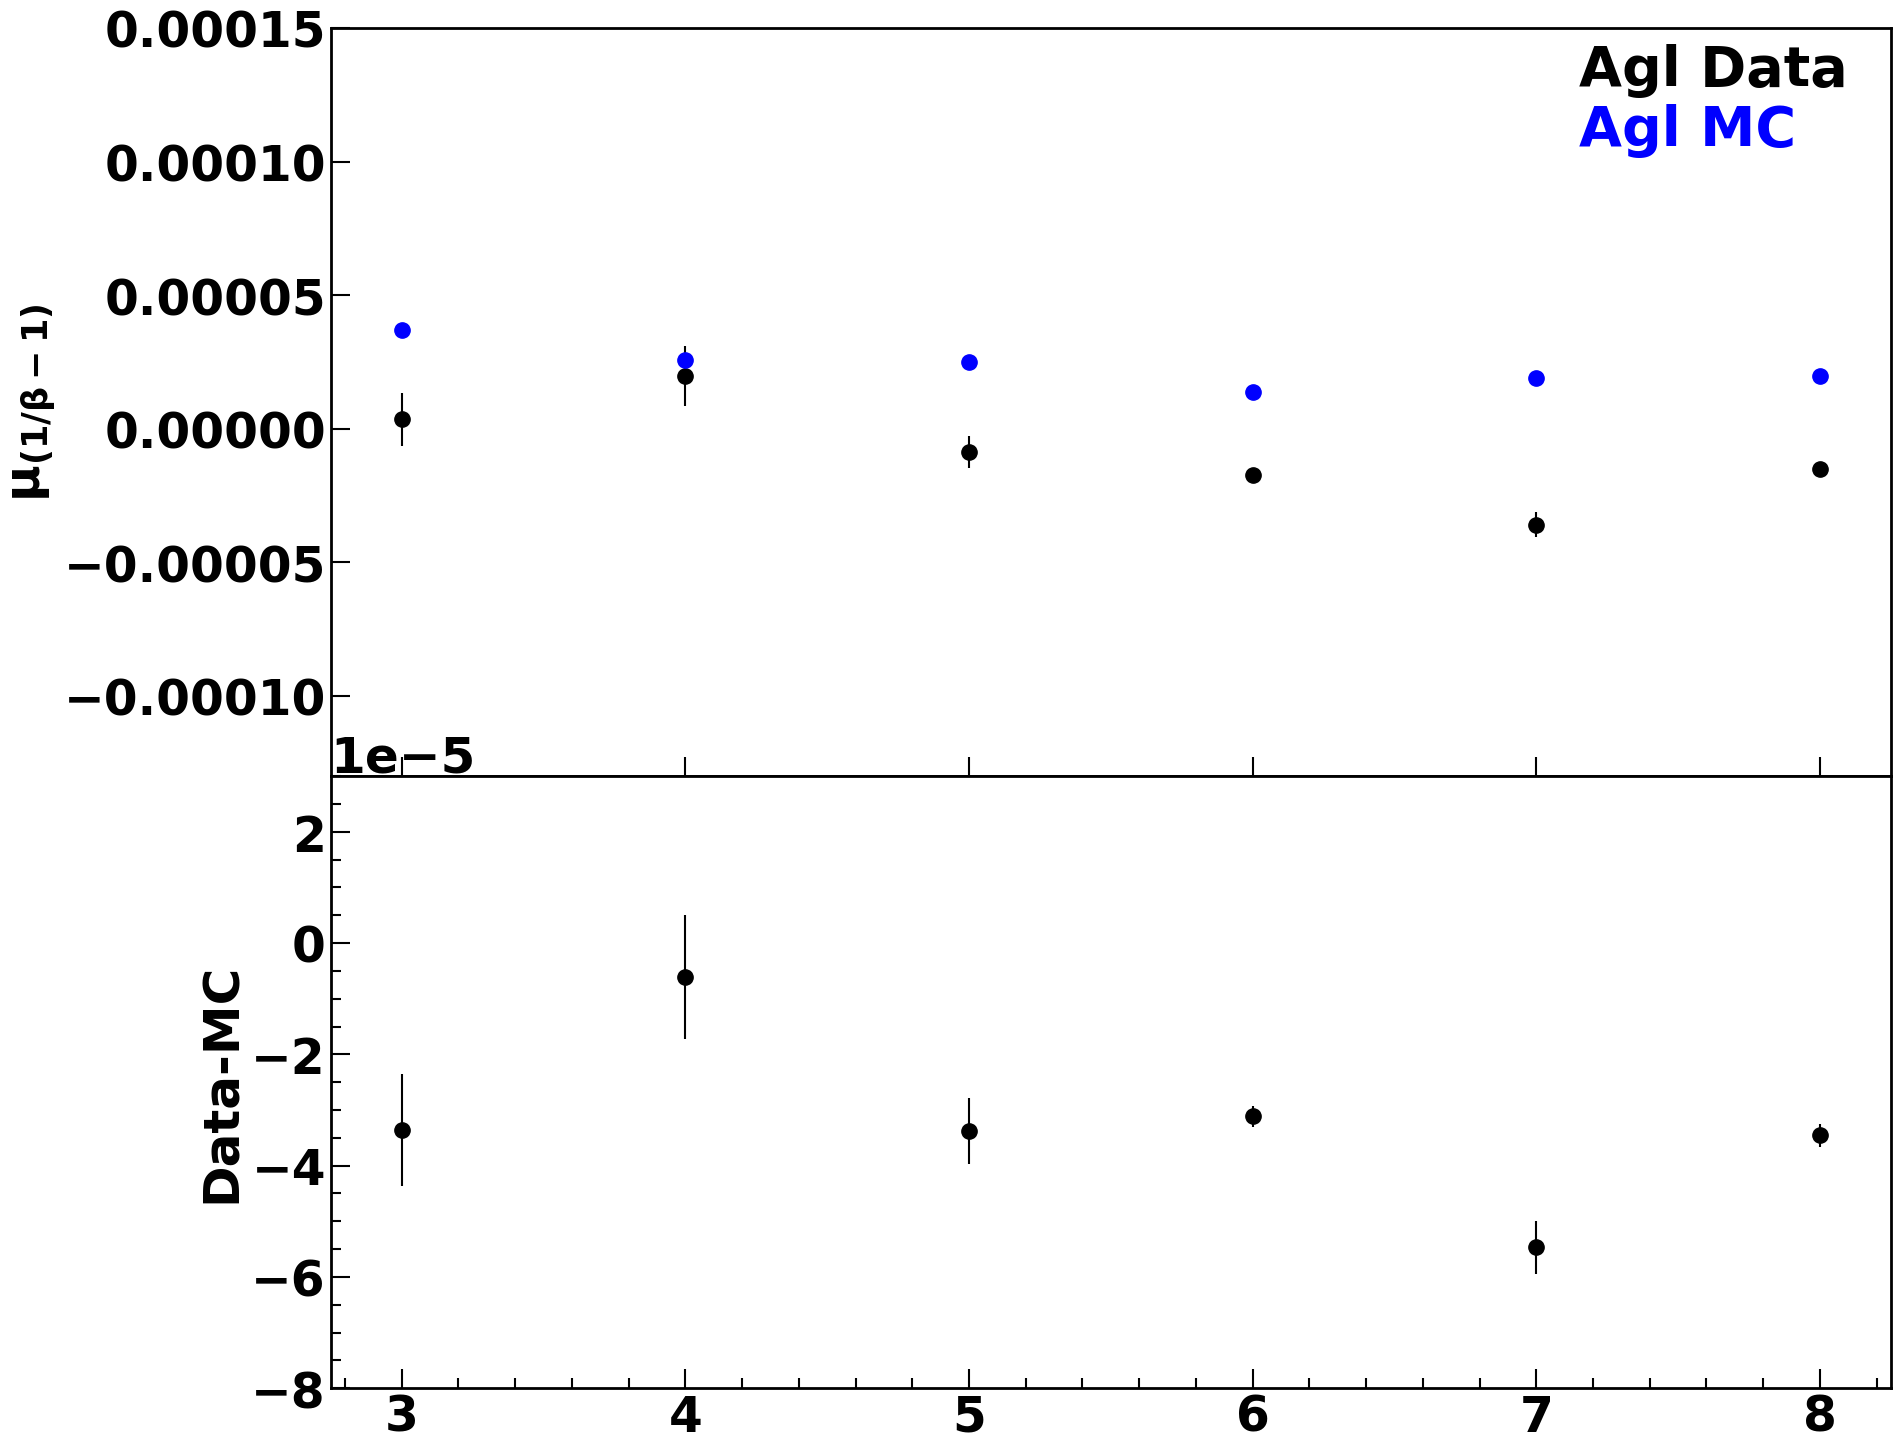

In [39]:
dec= 'Agl'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
fig.subplots_adjust(left= 0.17, right=0.95, bottom=0.1, top=0.95)
plot_graph(fig, ax1, graph_meanvsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} Data') 
plot_graph(fig, ax1, graph_meanvsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} MC')  
ax1.set_xlabel('charge Z')
ax1.set_ylabel(r'$\mathrm{\mu_{(1/\beta -1)}}$')

ax1.text(0.8, 0.98, f'{dec} Data', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='bold')
ax1.set_ylim([-0.00013, 0.00015])
ax1.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])


graph_diff_mean[dec].yvalues = graph_meanvsz_iss[dec].yvalues - graph_meanvsz_mc[dec].yvalues
graph_diff_mean[dec].yerrs = np.sqrt(graph_meanvsz_iss[dec].yerrs**2 + graph_meanvsz_mc[dec].yerrs**2 - 2*graph_meanvsz_iss[dec].yerrs*graph_meanvsz_mc[dec].yerrs*0.1)

plot_graph(fig, ax2, graph_diff_mean[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
ax2.set_ylim([-0.00008, 0.00003])
ax2.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax2.set_ylabel('Data-MC')
#savefig_tofile(fig, plotfile, f"graph_mean_{dec}_{figsuffix}", show=True) 

graph_meanvsz_iss[dec].add_to_file(df_pars, f'graph_meanvsz_iss_{dec}')
graph_meanvsz_mc[dec].add_to_file(df_pars, f'graph_meanvsz_mc_{dec}')
graph_diff_mean[dec].add_to_file(df_pars, f'graph_diff_mean_{dec}')


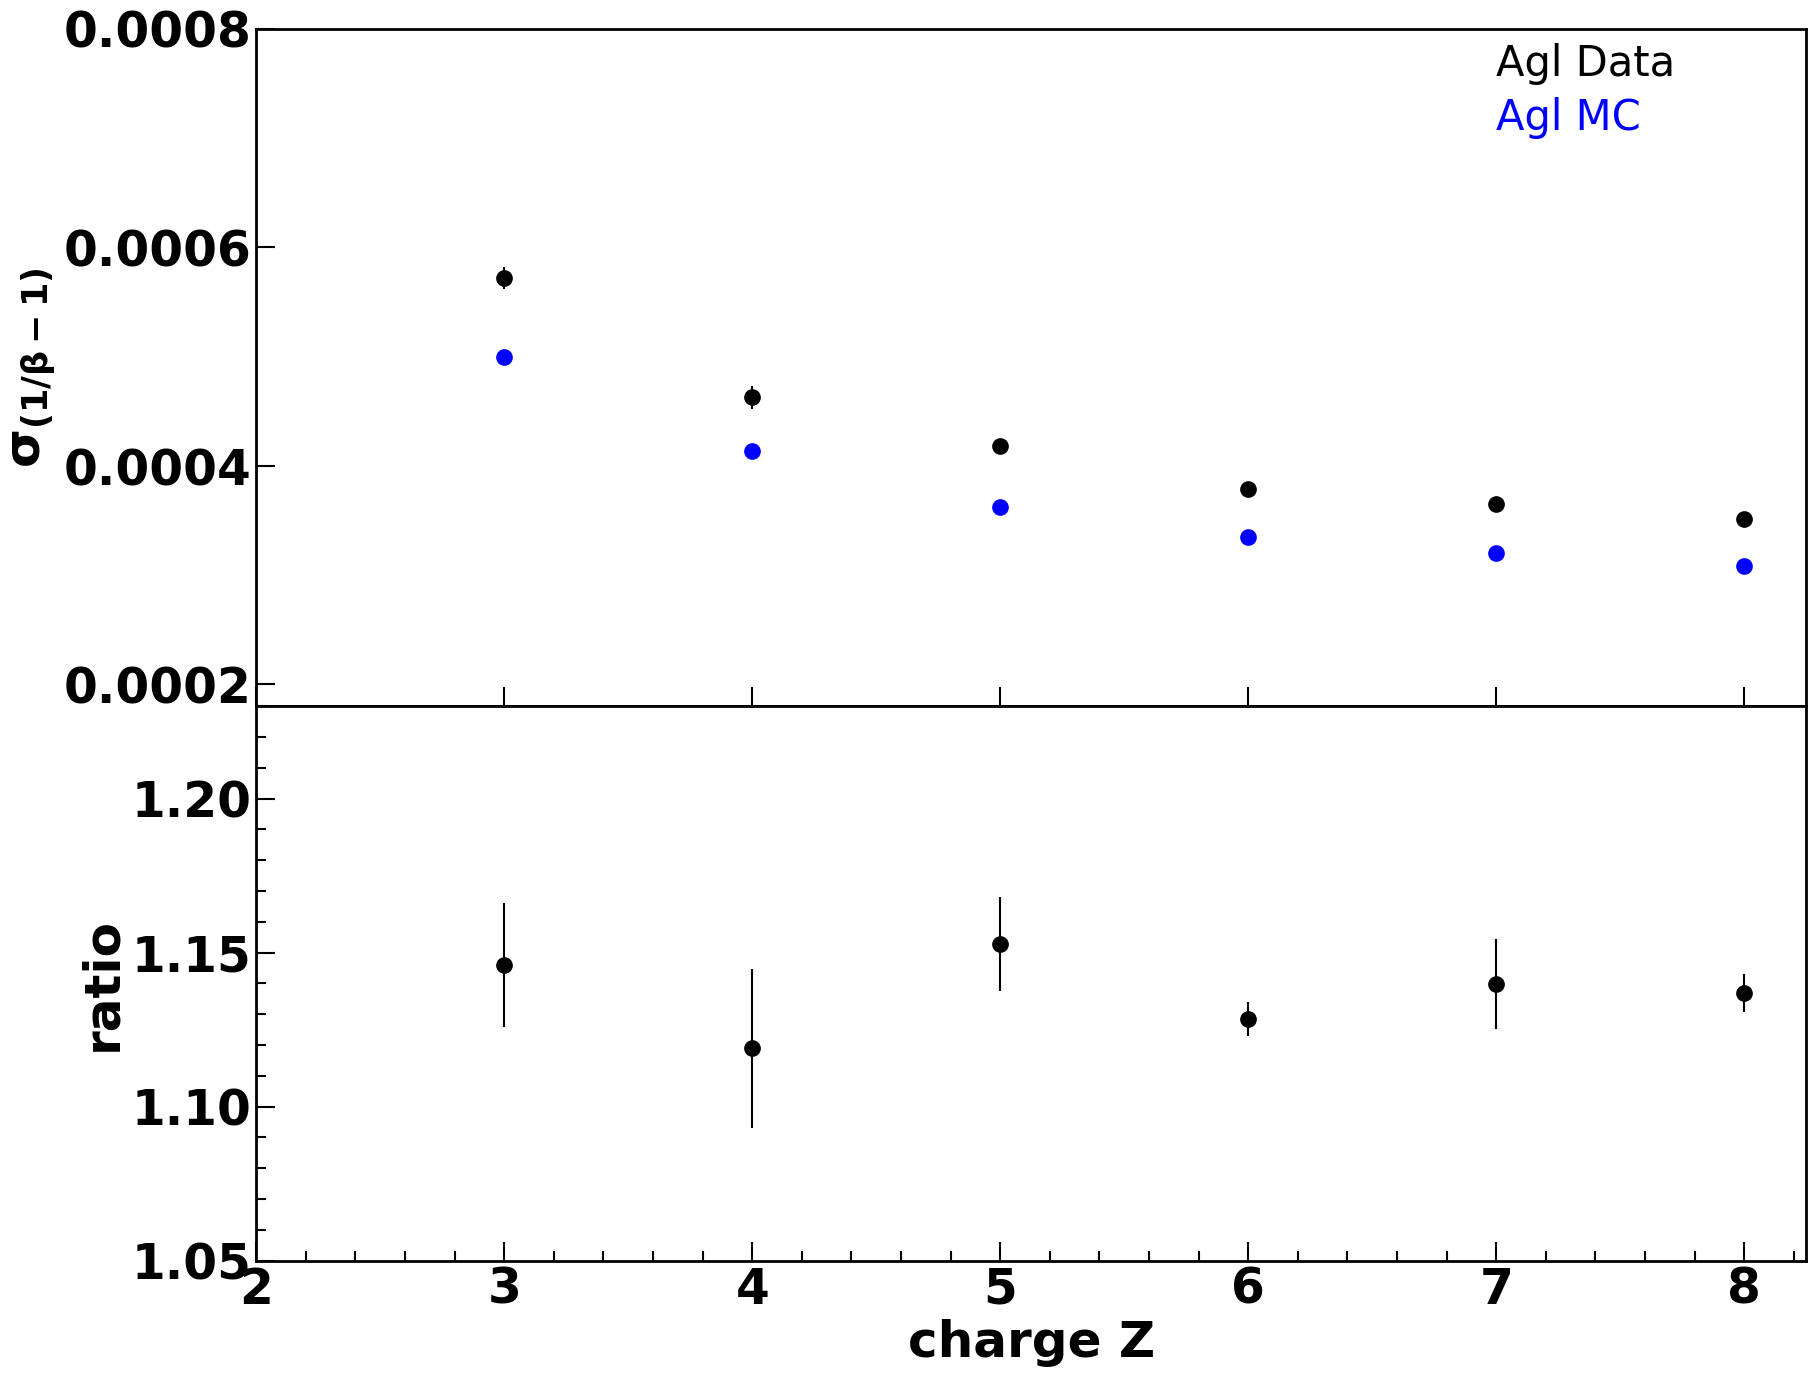

In [40]:
dec= 'Agl'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} MC')  

ax1.set_ylabel(r'$\mathrm{\sigma_{(1/\beta -1)}}$')
ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')
ax1.set_ylim([0.00018, 0.0008])
ax1.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs*0.6
ax2.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

ax2.set_ylim([1.05, 1.23])
ax2.set_xlabel('charge Z')
ax2.set_ylabel('ratio')
#savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}", show=True) 

graph_sigmavsz_iss[dec].add_to_file(df_pars, f'graph_sigmavsz_iss_{dec}')
graph_sigmavsz_mc[dec].add_to_file(df_pars, f'graph_sigmavsz_mc_{dec}')
graph_ratio_sigma[dec].add_to_file(df_pars, f'graph_ratio_sigma_{dec}')

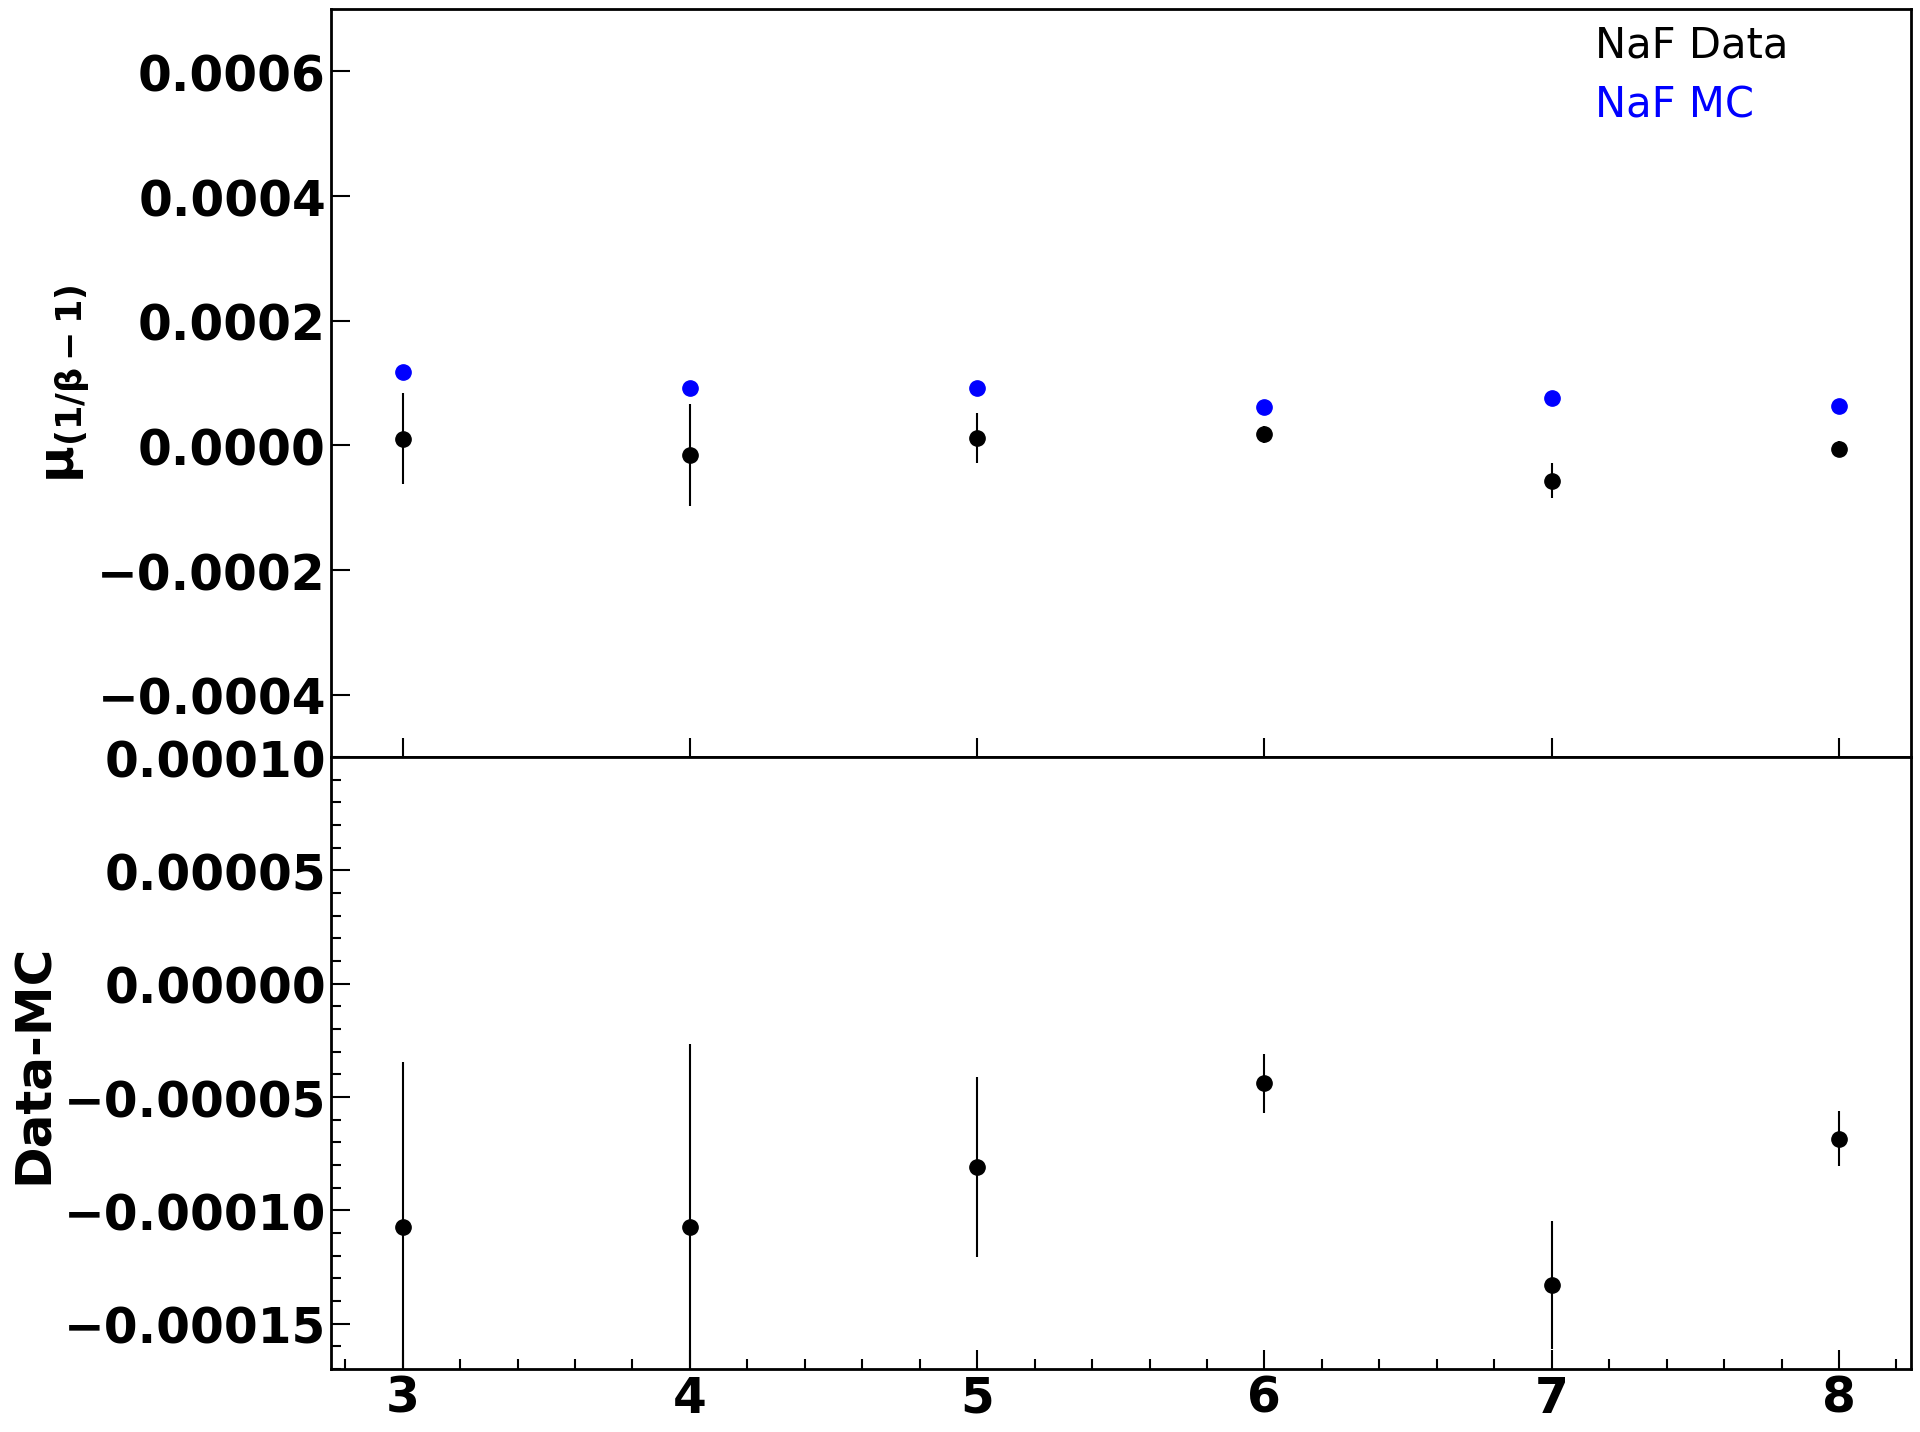

In [41]:
dec= 'NaF'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
fig.subplots_adjust(left= 0.16, right=0.95, bottom=0.1, top=0.95) 
plot_graph(fig, ax1, graph_meanvsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} Data') 
plot_graph(fig, ax1, graph_meanvsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} MC')  
ax1.set_xlabel('charge Z')
ax1.set_ylabel(r'$\mathrm{\mu_{(1/\beta -1)}}$')

ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')

ax1.set_ylim([-0.0005, 0.0007])
ax1.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])


graph_diff_mean[dec].yvalues = graph_meanvsz_iss[dec].yvalues - graph_meanvsz_mc[dec].yvalues
graph_diff_mean[dec].yerrs = np.sqrt(graph_meanvsz_iss[dec].yerrs**2 + graph_meanvsz_mc[dec].yerrs**2 - 2*graph_meanvsz_iss[dec].yerrs*graph_meanvsz_mc[dec].yerrs*0.1)

plot_graph(fig, ax2, graph_diff_mean[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
ax2.set_ylim([-0.00017, 0.0001])
ax2.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax2.set_ylabel('Data-MC')
#savefig_tofile(fig, plotfile, f"graph_mean_{dec}_{figsuffix}", show=True) 

graph_meanvsz_iss[dec].add_to_file(df_pars, f'graph_meanvsz_iss_{dec}')
graph_meanvsz_mc[dec].add_to_file(df_pars, f'graph_meanvsz_mc_{dec}')
graph_diff_mean[dec].add_to_file(df_pars, f'graph_diff_mean_{dec}')




xvalues			yvalues			yerrs
3.0			0.0015609597410586953			5.113287403042682e-06
4.0			0.0012295884719508204			3.0517830842071087e-06
5.0			0.0010382279992049888			2.9794272134339034e-06
6.0			0.0008989438348941433			2.0646619932156165e-06
7.0			0.0008126901972738974			2.3067907825399813e-06
8.0			0.0007631273574358664			2.7201987799643107e-06

/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


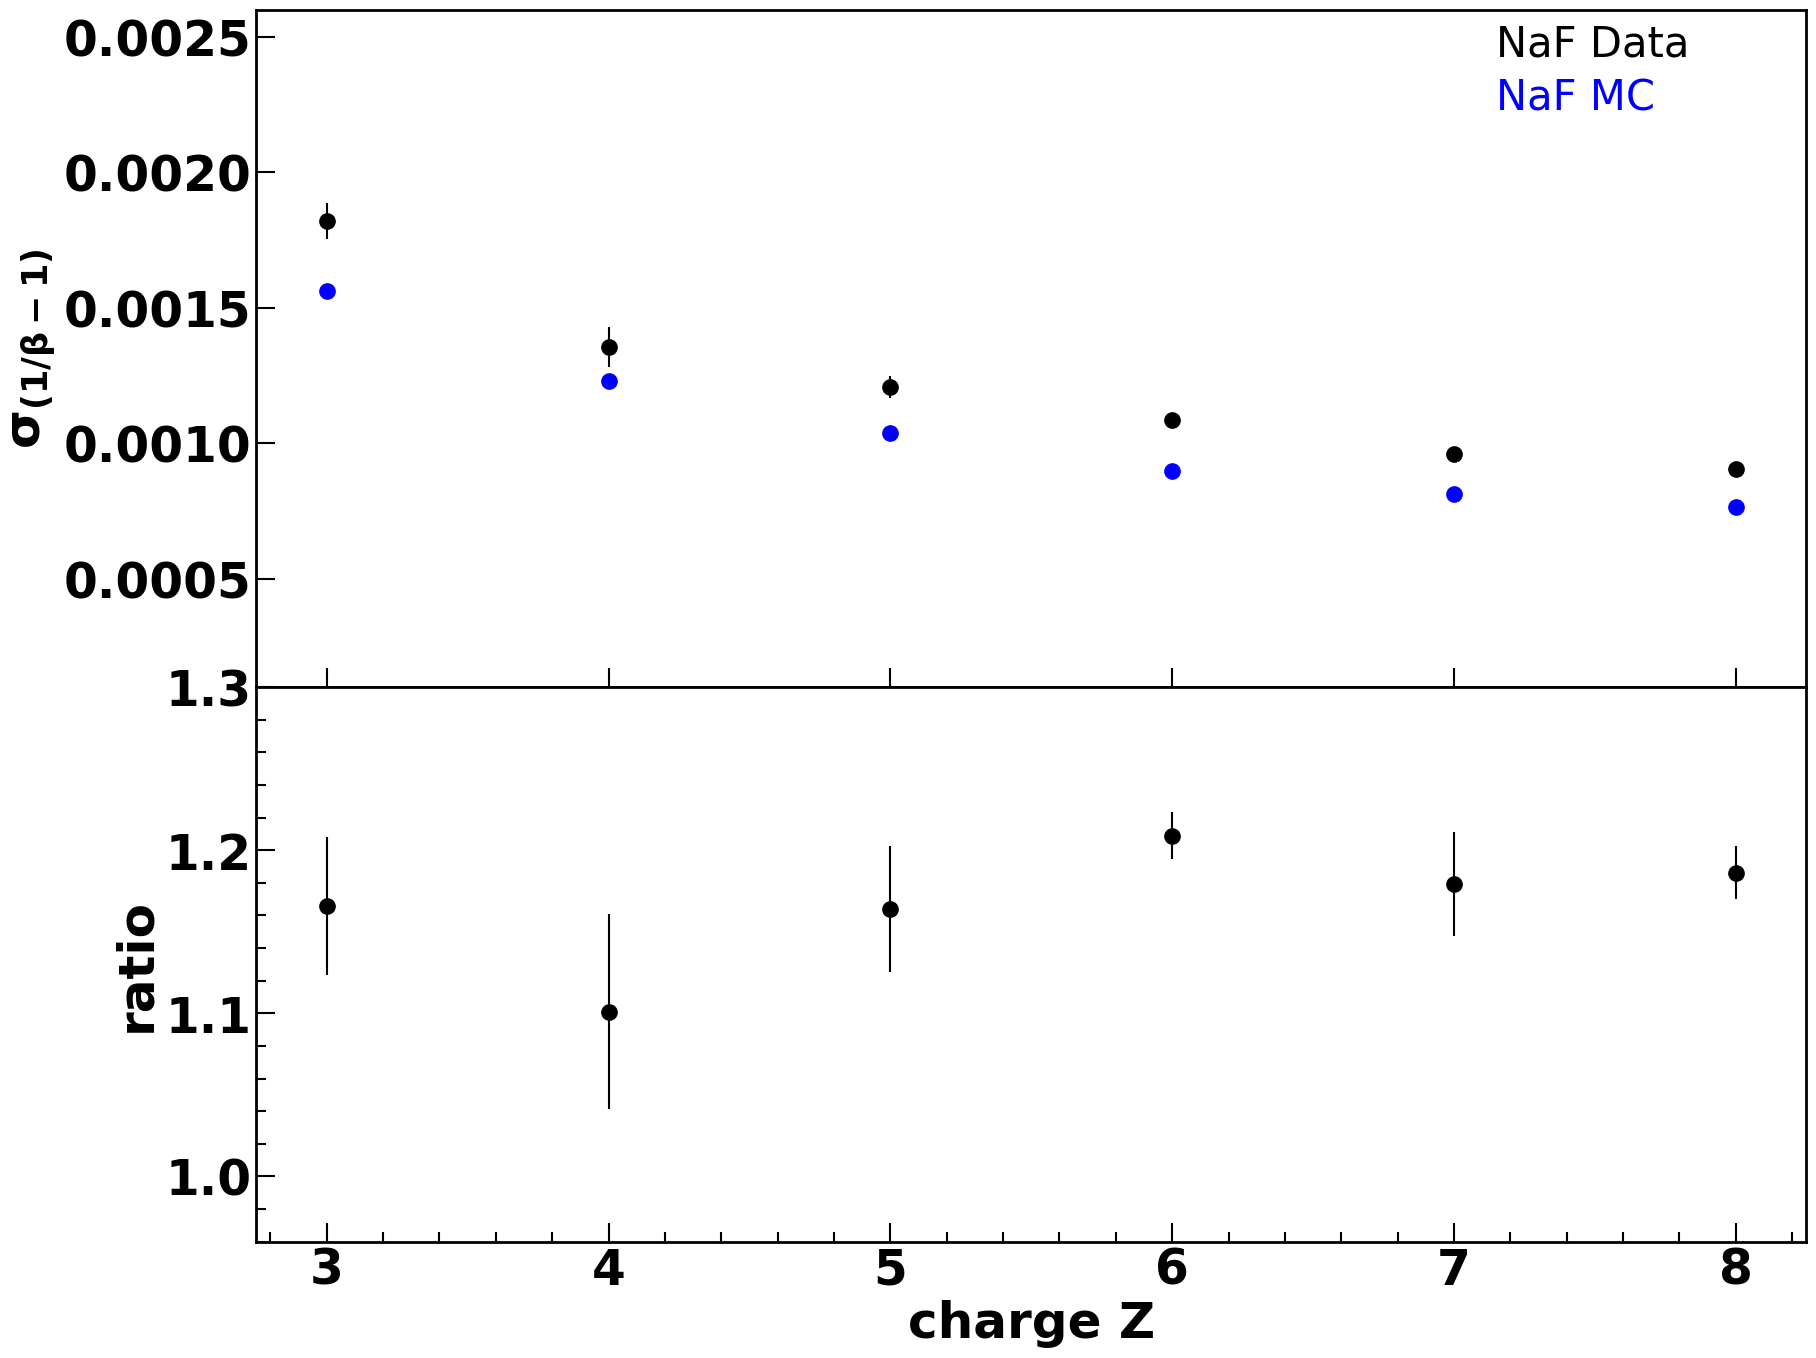

In [42]:
dec= 'NaF'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{nuclei} MC')  
print(graph_sigmavsz_mc[dec])

ax1.set_ylabel(r'$\mathrm{\sigma_{(1/\beta -1)}}$')
ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')
ax1.set_ylim([0.0001, 0.0026])
ax1.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs*0.6
ax2.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax2.set_ylim([0.96, 1.3])
ax2.set_xlabel('charge Z')
ax2.set_ylabel('ratio')
#savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}", show=True) 

graph_sigmavsz_iss[dec].add_to_file(df_pars, f'graph_sigmavsz_iss_{dec}')
graph_sigmavsz_mc[dec].add_to_file(df_pars, f'graph_sigmavsz_mc_{dec}')
graph_ratio_sigma[dec].add_to_file(df_pars, f'graph_ratio_sigma_{dec}')
print(plotfile)
np.savez(os.path.join(plotfile, 'graph_pars_RICH_HighRuntuned.npz'), **df_pars)
np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_pars_RICH_HighR_untuned.npz'), **df_pars)


In [43]:
df_highRPars = np.load(os.path.join('/home/manbing/Documents/Data/data_BeP8/', 'graph_pars_RICH_HighR_untuned.npz'))
df_highRPars_tuned = np.load(os.path.join('/home/manbing/Documents/Data/data_BeP8/', 'graph_pars_RICH_HighRAll_tuned.npz'))
graph_diff_mean = {}
graph_ratio_sigma = {}
graph_meanvsz_iss = {}
graph_meanvsz_mc = {}
graph_sigmavsz_iss = {}
graph_sigmavsz_mc = {}
graph_sigmavsz_mctuned = {}
for dec in ['NaF','Agl']:
    graph_meanvsz_iss[dec] =  MGraph.from_file(df_highRPars, f'graph_meanvsz_iss_{dec}')
    graph_meanvsz_mc[dec] = MGraph.from_file(df_highRPars, f'graph_meanvsz_mc_{dec}')
    graph_sigmavsz_iss[dec] = MGraph.from_file(df_highRPars, f'graph_sigmavsz_iss_{dec}')
    graph_sigmavsz_mc[dec] = MGraph.from_file(df_highRPars, f'graph_sigmavsz_mc_{dec}')
    graph_diff_mean[dec] = MGraph.from_file(df_highRPars, f'graph_diff_mean_{dec}')
    graph_ratio_sigma[dec] = MGraph.from_file(df_highRPars, f'graph_ratio_sigma_{dec}')
    graph_sigmavsz_mctuned[dec] = MGraph.from_file(df_highRPars_tuned, f'graph_sigmavsz_mc_{dec}')
    
    
def set_plotstyle(ax1, ax2):
    plt.subplots_adjust(hspace=.0)   
    set_plot_defaultstyle(ax1)
    set_plot_defaultstyle(ax2)
    ax1.set_xticklabels([])


isscolor = 'black'
mccolor = 'blue'
df_pars = {}

def getpolyfit(agraph, p0):
    popt, pcov = curve_fit(poly, agraph.xvalues, agraph.yvalues, sigma=agraph.yerrs, p0 = p0)
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    yfit, yfiterr = get_fitpdf_witherr(agraph.xvalues, polypars, upoly)
    graph_fit = MGraph(agraph.xvalues, yfit, yfiterr)
    return graph_fit, polypars

graph_mean_Agl_beta_untuned_thesis


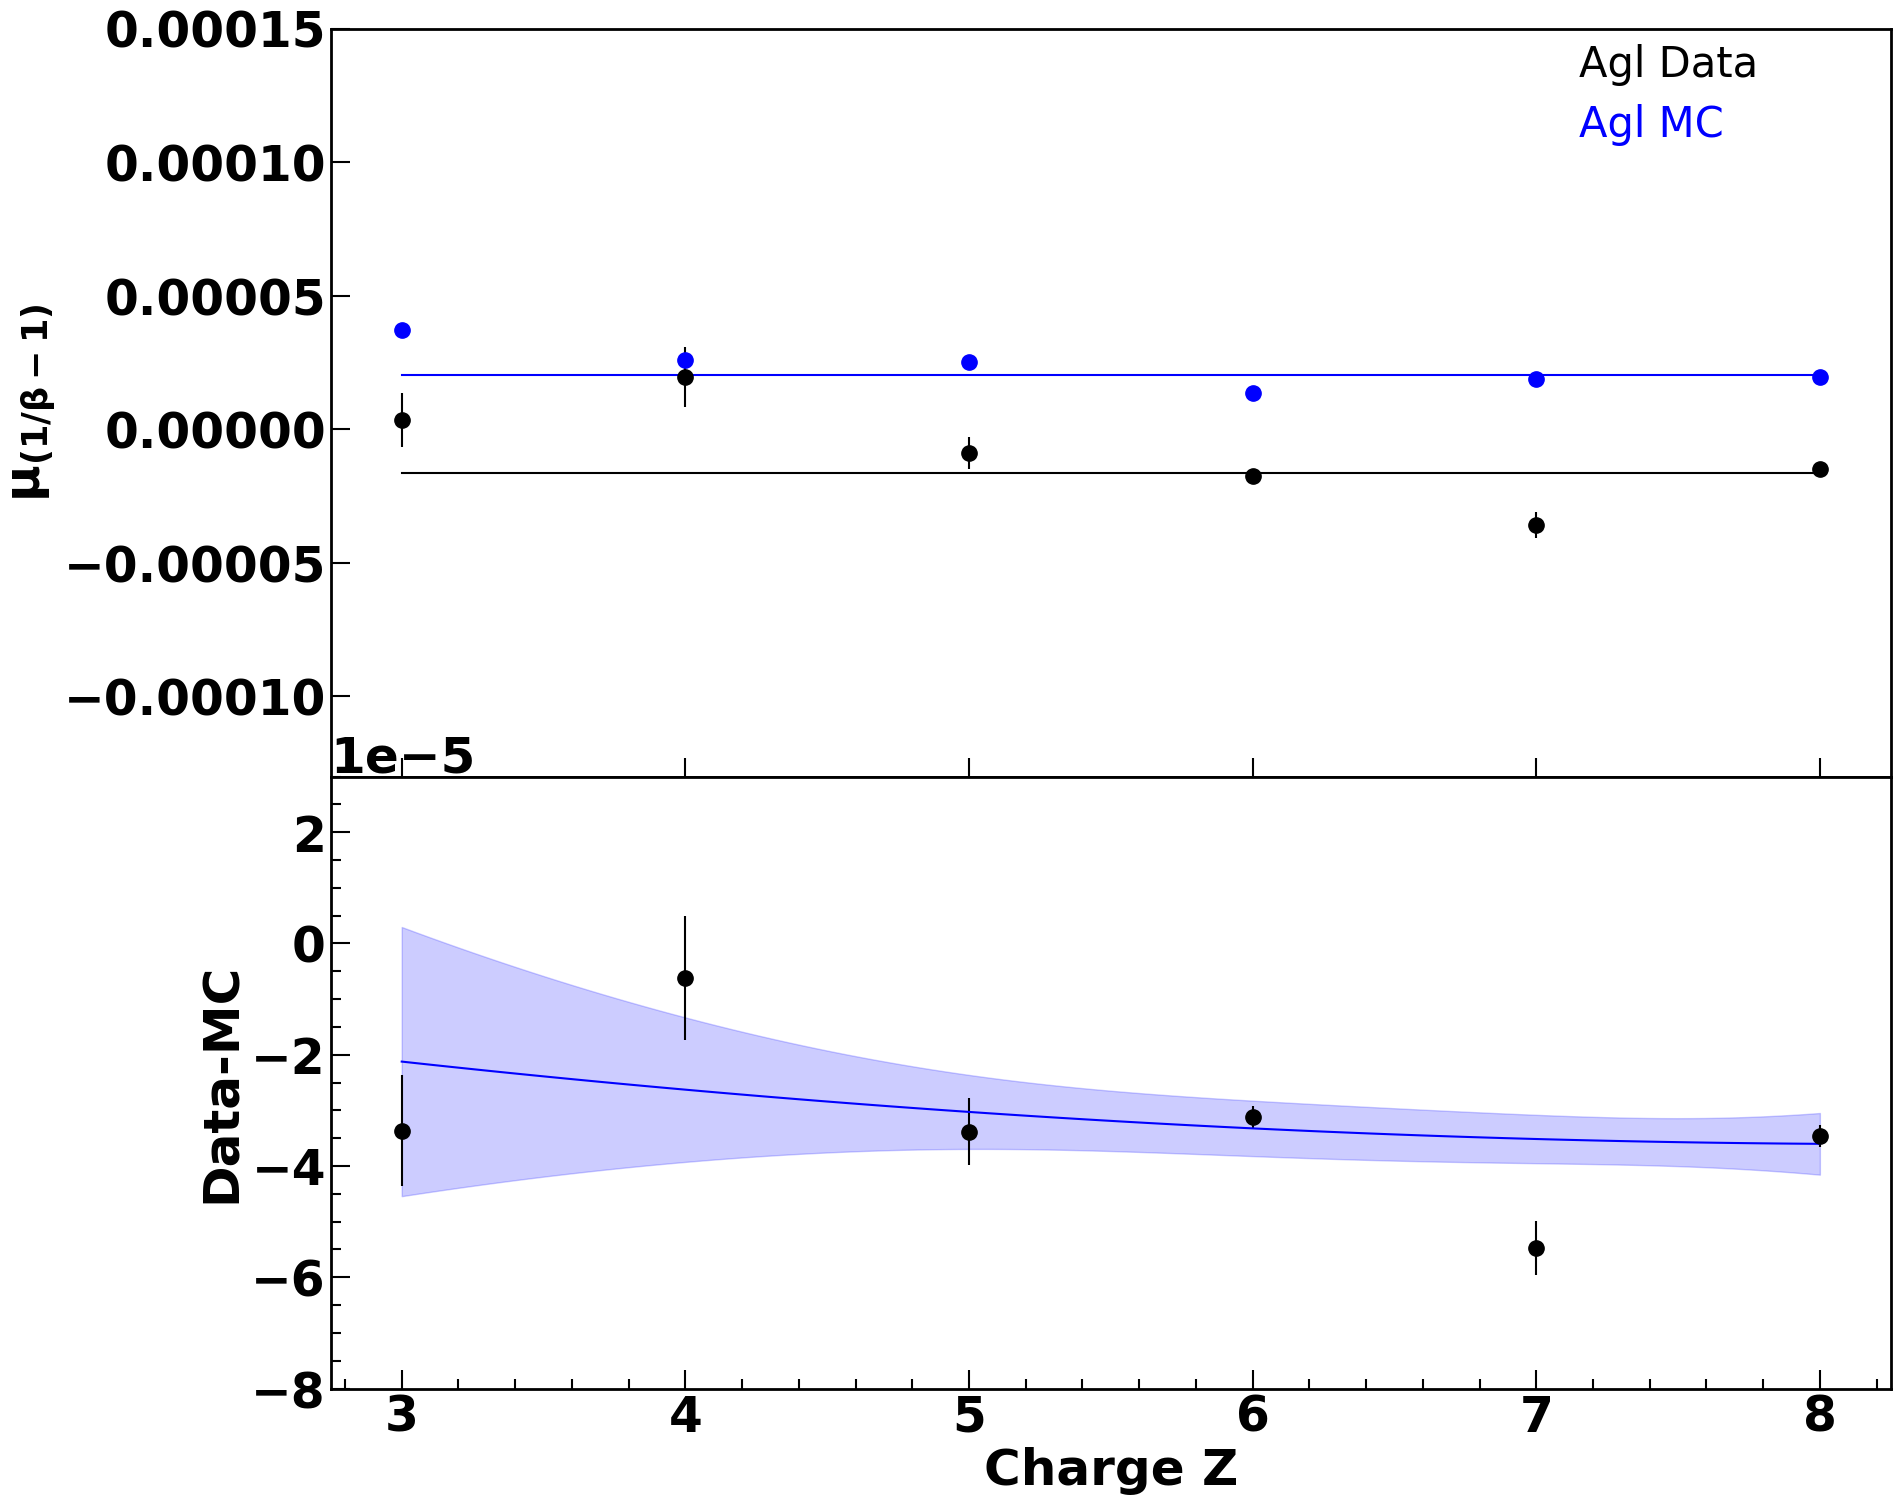

In [44]:
graphfit_meanvsz_iss = {}
graphfit_meanvsz_mc = {}
meaniss_parpolyfit = {}
meanmc_parpolyfit = {}
graphfit_mean_ratio = {}
graphfit_mean_ratio = {}
meanratio_parpolyfit = {}
meanratio_parpolyfit = {}

dec= 'Agl'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)

fig.subplots_adjust(left= 0.17, right=0.95, bottom=0.1, top=0.95)
plot_graph(fig, ax1, graph_meanvsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data') 
plot_graph(fig, ax1, graph_meanvsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'MC')  

ax1.set_ylabel(r'$\mathrm{\mu_{(1/\beta -1)}}$')

ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')
ax1.set_ylim([-0.00013, 0.00015])
ax1.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])


graph_diff_mean[dec].yvalues = graph_meanvsz_iss[dec].yvalues - graph_meanvsz_mc[dec].yvalues
graph_diff_mean[dec].yerrs = np.sqrt(graph_meanvsz_iss[dec].yerrs**2 + graph_meanvsz_mc[dec].yerrs**2 - 2*graph_meanvsz_iss[dec].yerrs*graph_meanvsz_mc[dec].yerrs*0.1)

p0 = [0.0001]
graphfit_meanvsz_iss[dec], meaniss_parpolyfit[dec] = getpolyfit(graph_meanvsz_iss[dec], p0)
graphfit_meanvsz_mc[dec], meanmc_parpolyfit[dec] = getpolyfit(graph_meanvsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), meaniss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), meanmc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
ydeltamean = graph_iss.yvalues - graph_mc.yvalues
#ax2.plot(np.linspace(3, 8, 100), ydeltamean, '-', color='black')

#plot_graph(fig, ax2, graph_ratio, color='black',  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
plot_graph(fig, ax2, graph_diff_mean[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
p0 = [0.0001, 0.001, 0.001]
graphfit_mean_ratio[dec], meanratio_parpolyfit[dec] = getpolyfit(graph_diff_mean[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), meanratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio- yfiterr_ratio, yfit_ratio+ yfiterr_ratio, color=mccolor, alpha=0.2) 


ax2.set_ylim([-0.00008, 0.00003])
ax2.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax2.set_ylabel('Data-MC')
ax2.set_xlabel('Charge Z')
print(f"graph_mean_{dec}_{figsuffix}")
savefig_tofile(fig, plotfile, f"graph_mean_{dec}_{figsuffix}", show=True) 
graph_meanvsz_iss[dec].add_to_file(df_pars, f'graph_meanvsz_iss_{dec}')
graph_meanvsz_mc[dec].add_to_file(df_pars, f'graph_meanvsz_mc_{dec}')
graph_diff_mean[dec].add_to_file(df_pars, f'graph_diff_mean_{dec}')


/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


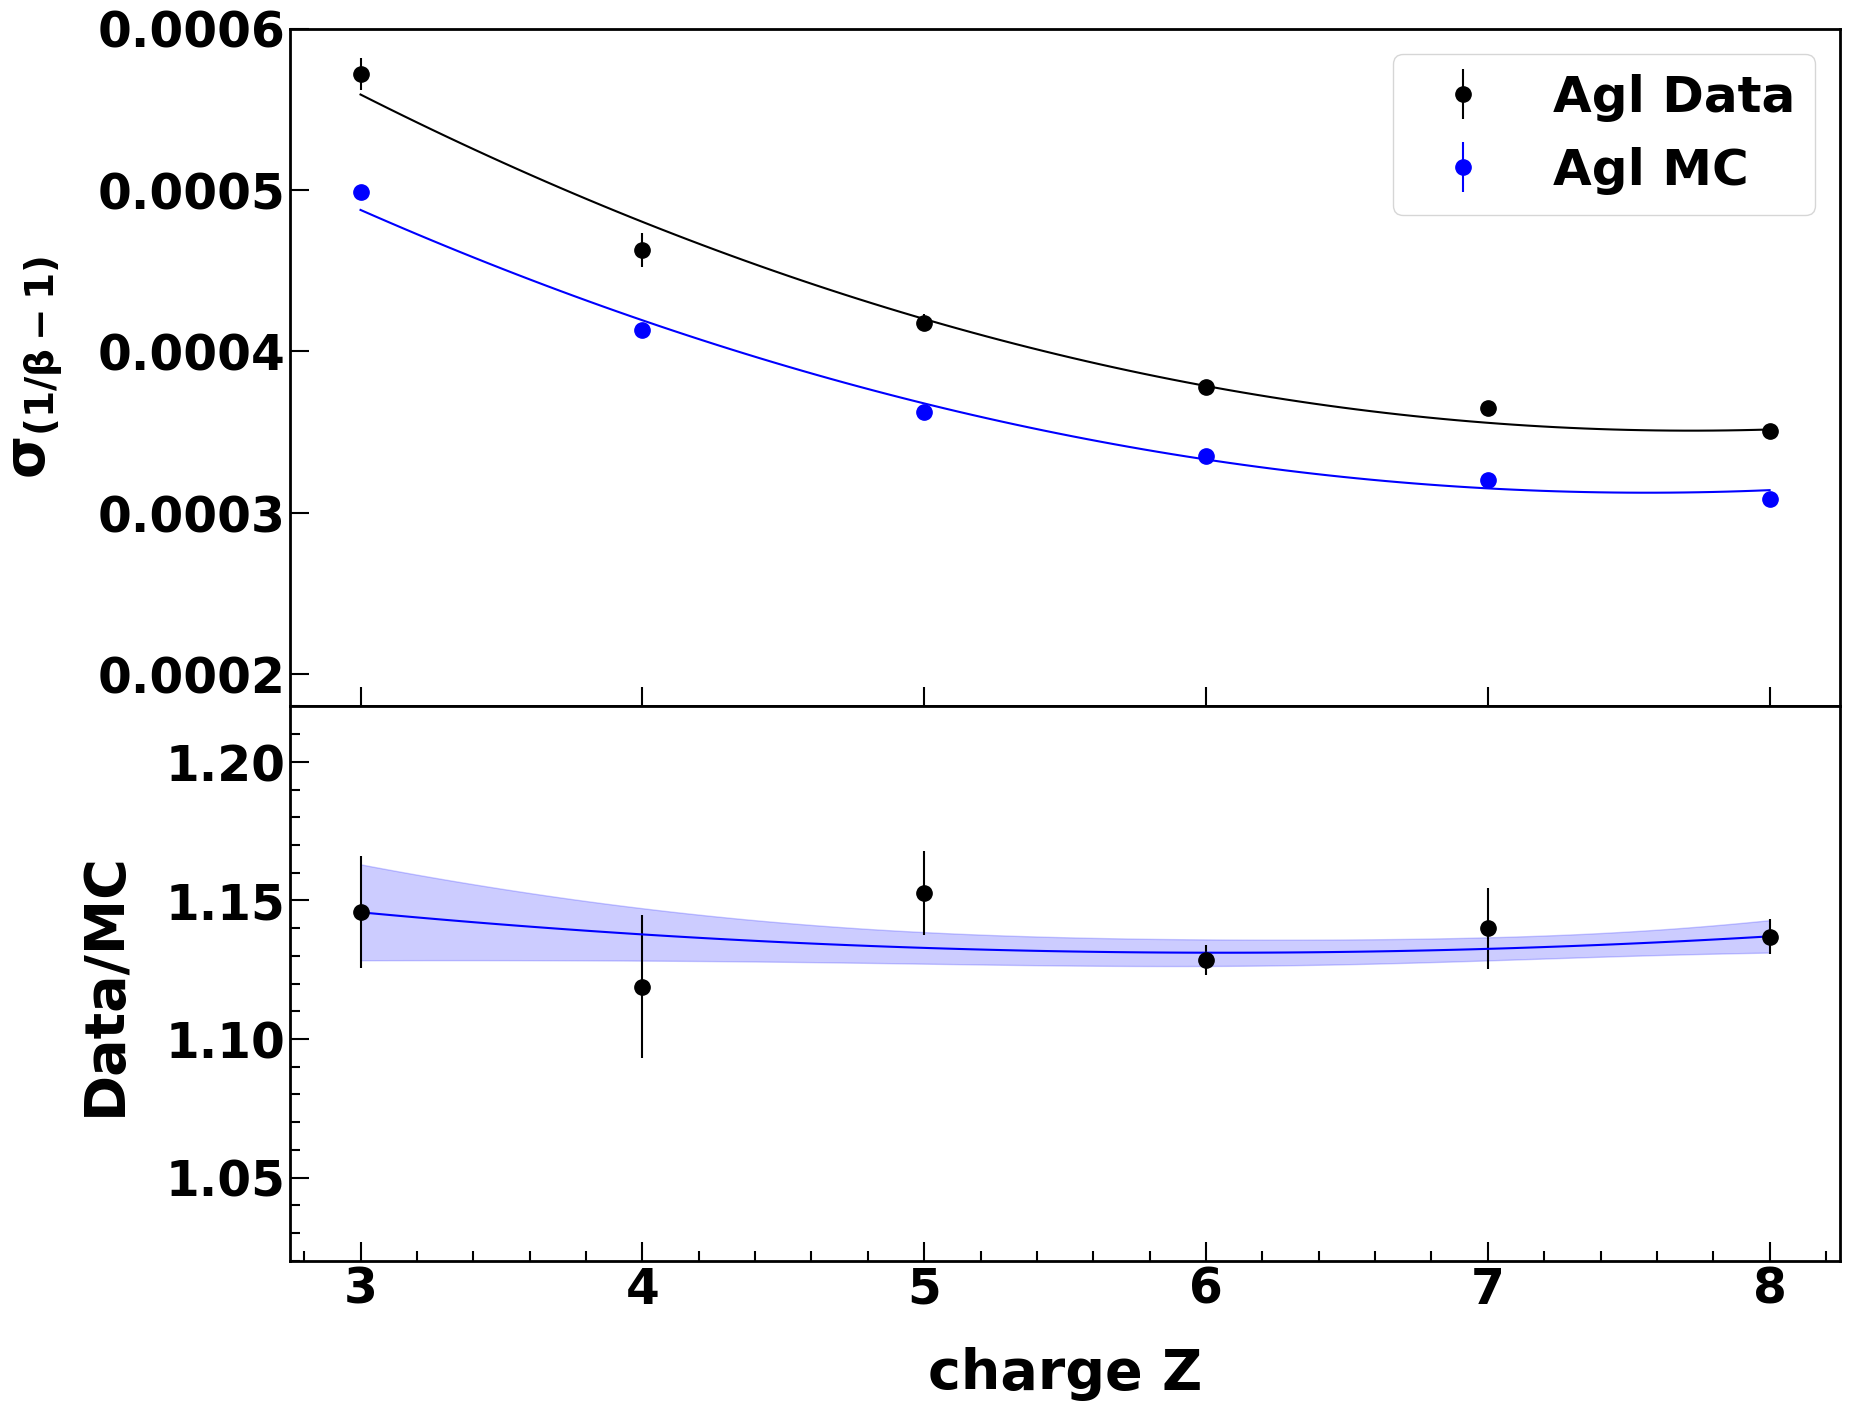

In [79]:
graphfit_sigmavsz_iss = {}
graphfit_sigmavsz_mc = {}
sigmaiss_parpolyfit = {}
sigmamc_parpolyfit = {}
graphfit_sigmaratio = {}
sigmaratio_parpolyfit = {}

dec= 'Agl'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{dec} Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{dec} MC')  

SetAx1Axis(ax1, '',r'$\mathrm{\sigma_{(1/\beta -1)}}$' , TEXTSIZE, xlimrange=None, ylimrange=[0.00018, 0.0006],custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax1.legend()
graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs


p0 = [0.0005, 0.01, 0.01]
graphfit_sigmavsz_iss[dec], sigmaiss_parpolyfit[dec] = getpolyfit(graph_sigmavsz_iss[dec], p0)
graphfit_sigmavsz_mc[dec], sigmamc_parpolyfit[dec] = getpolyfit(graph_sigmavsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaiss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmamc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
graph_ratio = graph_iss/graph_mc

p0 = [0.0005, 0.01, 0.1]
graphfit_sigmaratio[dec], sigmaratio_parpolyfit[dec] = getpolyfit(graph_ratio_sigma[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio-yfiterr_ratio, yfit_ratio+yfiterr_ratio, color=mccolor, alpha=0.2) 
SetAx1Axis(ax1, '',r'$\mathrm{\sigma_{(1/\beta -1)}}$' , TEXTSIZE, xlimrange=None, ylimrange=[0.00018, 0.0006],custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
SetAx1Axis(ax2, 'charge Z', 'Data/MC' , TEXTSIZE, ylimrange=[1.02, 1.22], custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate_08012024'
savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}_Apr", show=True) 
print(plotfile)

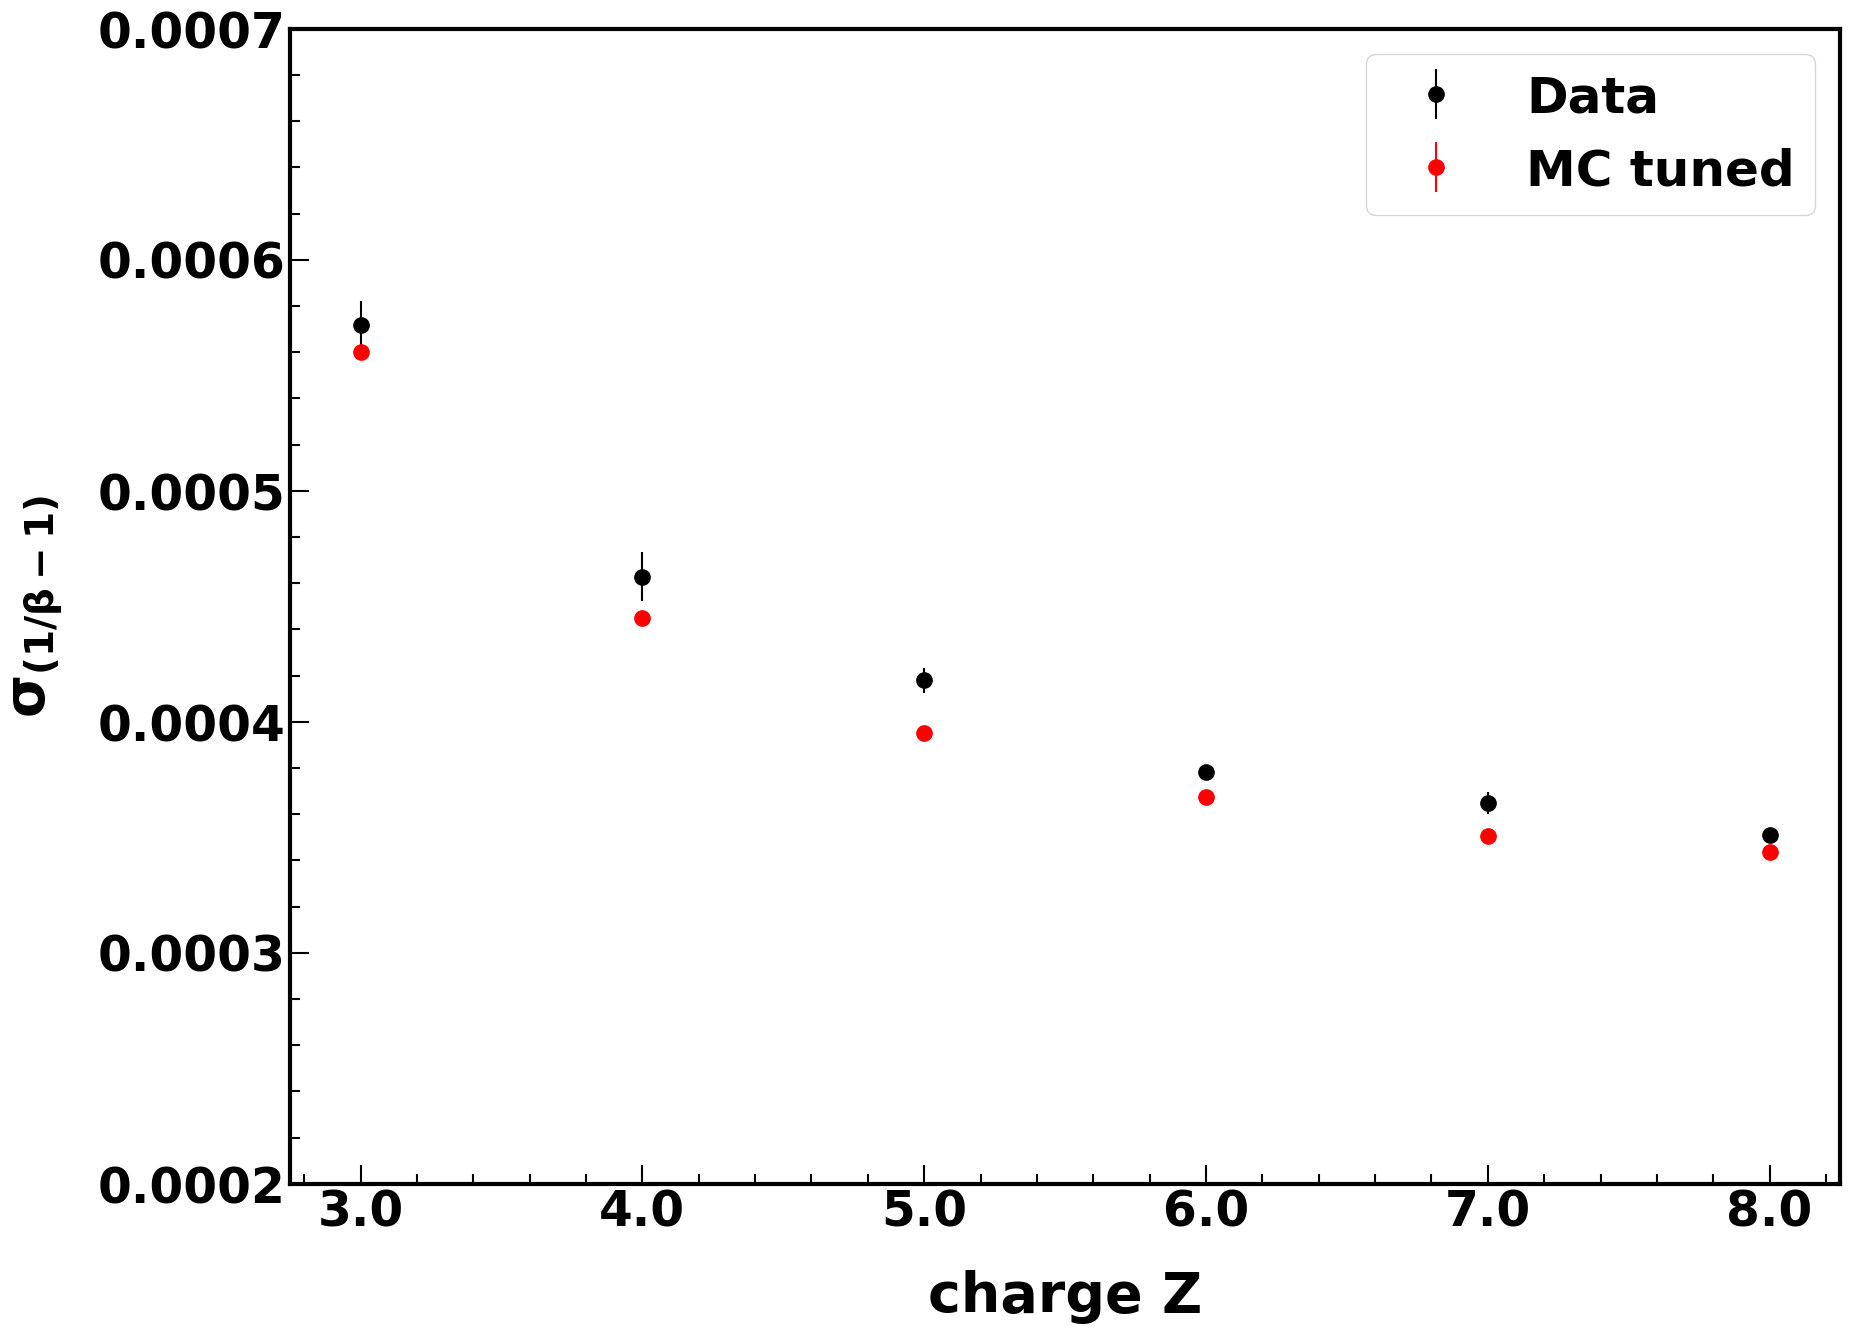

In [46]:
graphfit_sigmavsz_iss = {}
graphfit_sigmavsz_mc = {}
sigmaiss_parpolyfit = {}
sigmamc_parpolyfit = {}
graphfit_sigmaratio = {}
sigmaratio_parpolyfit = {}
dec= 'Agl'
FIGSIZE1 = (20, 15)
fig, ax1 = plt.subplots(figsize=FIGSIZE1) 
set_plot_style(ax1)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data') 
plot_graph(fig, ax1, graph_sigmavsz_mctuned[dec], color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'MC tuned')  

SetAx1Axis(ax1, 'charge Z',r'$\mathrm{\sigma_{(1/\beta -1)}}$' , TEXTSIZE, xlimrange=None, ylimrange=[0.0002, 0.0007],custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0], custom_tickslabels=['3.0', '4.0', '5.0', '6.0', '7.0', '8.0'])
ax1.legend()
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate_08012024'
savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_tuned", show=True) 

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


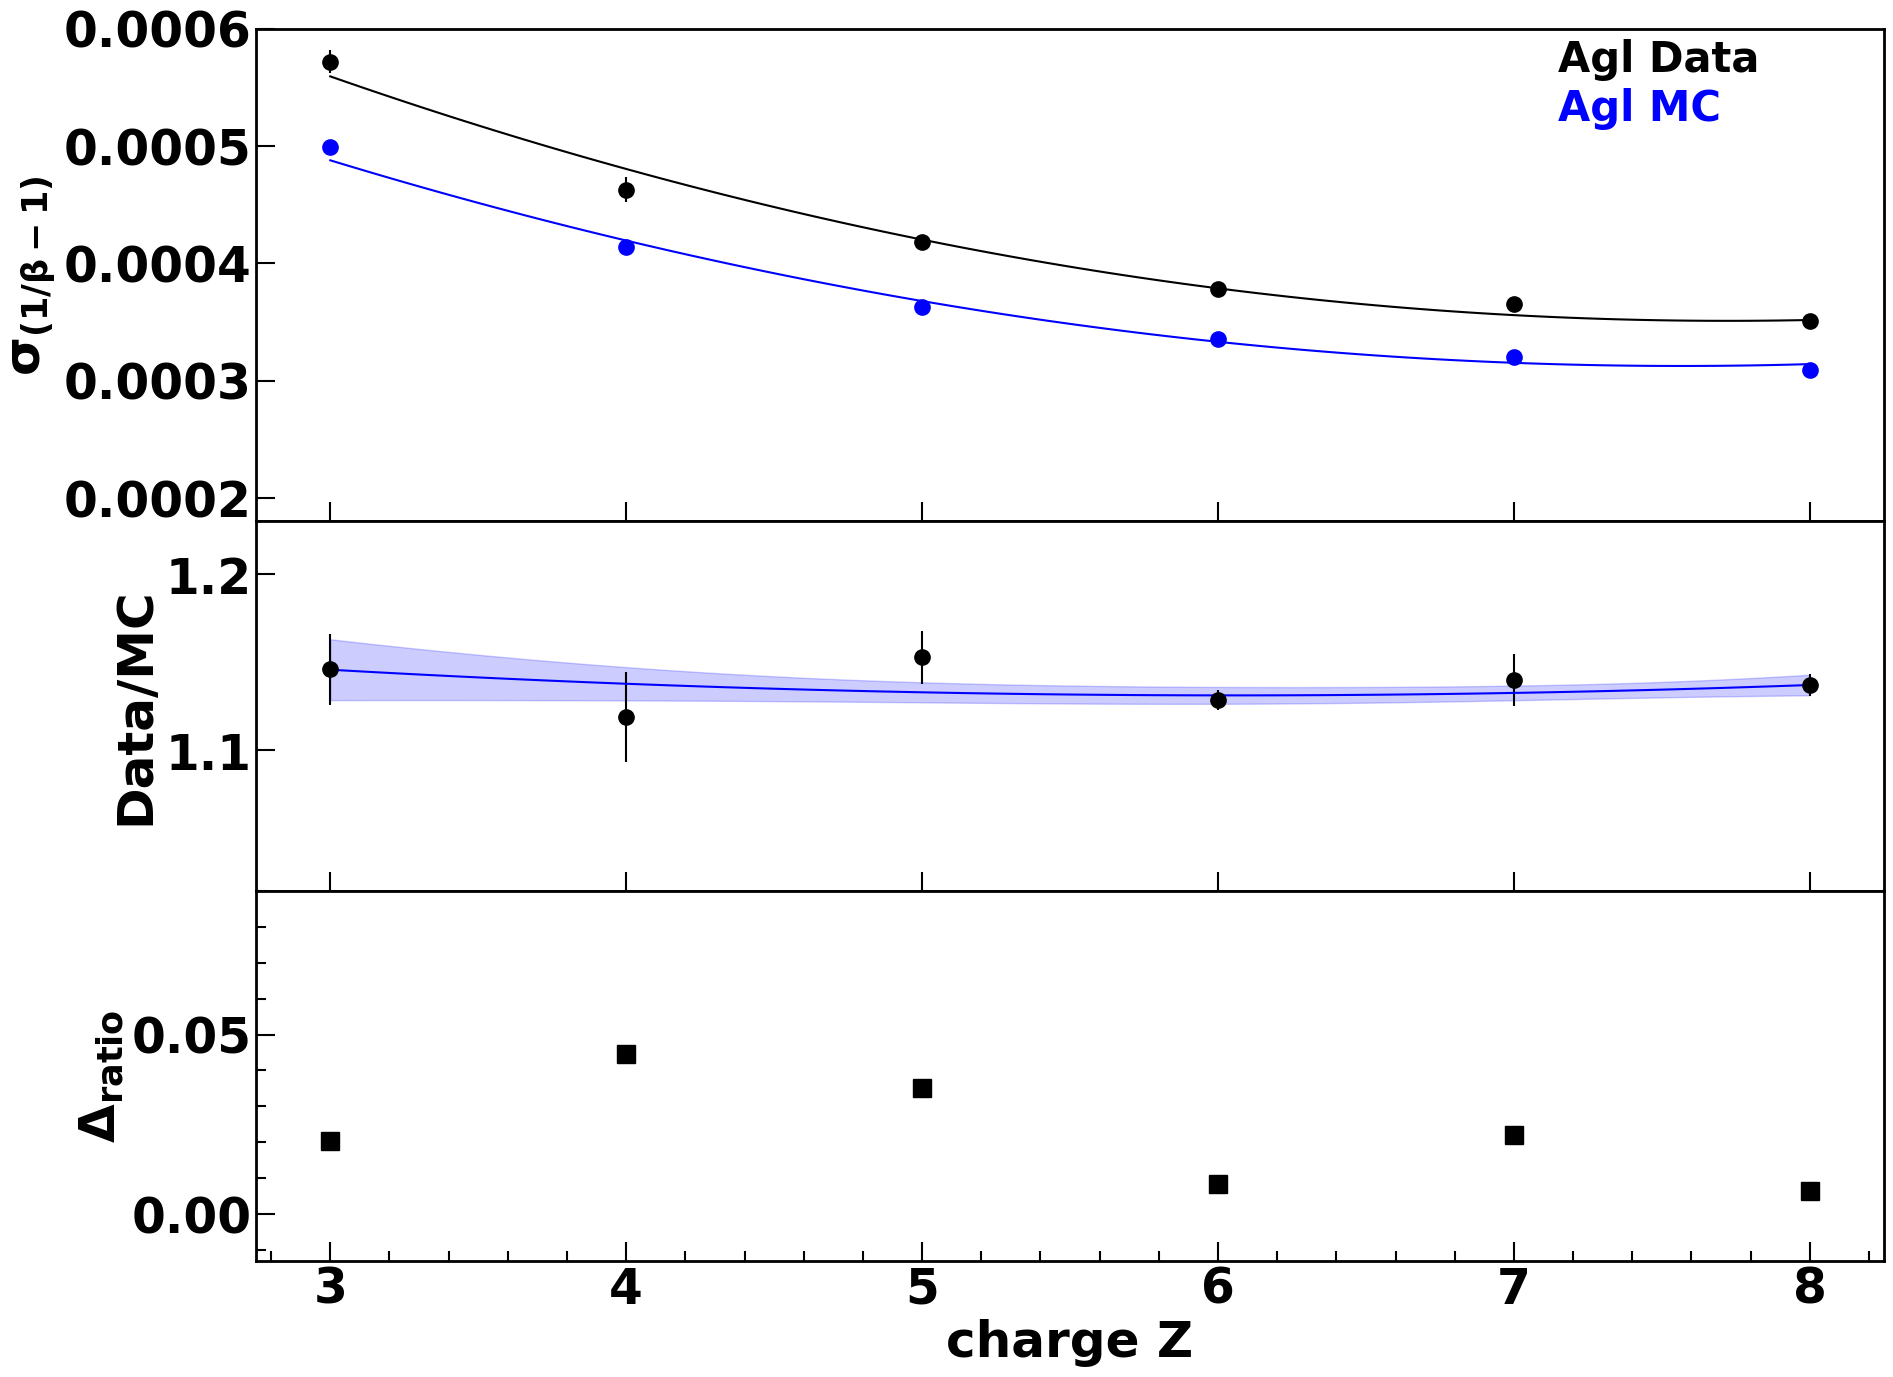

In [74]:
graphfit_sigmavsz_iss = {}
graphfit_sigmavsz_mc = {}
sigmaiss_parpolyfit = {}
sigmamc_parpolyfit = {}
graphfit_sigmaratio = {}
sigmaratio_parpolyfit = {}

dec= 'Agl'

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.4, 0.3, 0.3]}, figsize=(21, 16)) 
set_plotstyle(ax1, ax2)
set_plotstyle(ax2, ax3)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{dec} Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{dec} MC')  

ax1.set_ylabel(r'$\mathrm{\sigma_{(1/\beta -1)}}$')
ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
ax1.text(0.8, 0.88, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='bold')
#ax1.legend()
ax1.set_ylim([0.00018, 0.0006])
ax1.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs
ax3.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

p0 = [0.0005, 0.01, 0.01]
graphfit_sigmavsz_iss[dec], sigmaiss_parpolyfit[dec] = getpolyfit(graph_sigmavsz_iss[dec], p0)
graphfit_sigmavsz_mc[dec], sigmamc_parpolyfit[dec] = getpolyfit(graph_sigmavsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaiss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmamc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
graph_ratio = graph_iss/graph_mc

p0 = [0.0005, 0.01, 0.1]
graphfit_sigmaratio[dec], sigmaratio_parpolyfit[dec] = getpolyfit(graph_ratio_sigma[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio-yfiterr_ratio, yfit_ratio+yfiterr_ratio, color=mccolor, alpha=0.2) 

#plot_graph(fig, ax2, graph_ratio, color='black',  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
yvaluesmaxdiff = abs(graphfit_sigmaratio[dec].yvalues - graph_ratio_sigma[dec].yvalues) + abs(graph_ratio_sigma[dec].yerrs)

graph_maxdiff = MGraph(graph_ratio_sigma[dec].xvalues, yvaluesmaxdiff, np.zeros_like(graph_ratio_sigma[dec].xvalues))
plot_graph(fig, ax3, graph_maxdiff, color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=13, label=f'', marker = 's')  
#ax2.fill_between(graph_ratio.xvalues, graph_ratio.yvalues-graph_ratio.yerrs, graph_ratio.yvalues+graph_ratio.yerrs, color='grey', alpha=0.2)  

ax3.set_ylabel(r'$\mathrm{\Delta_{ratio}}$')
ax2.set_ylim([1.02, 1.23])
ax3.set_xlabel('charge Z')
ax2.set_ylabel('Data/MC')
ax3.set_ylim([-0.013, 0.09])
print(plotfile)
savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}_V1Apr", show=True) 

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


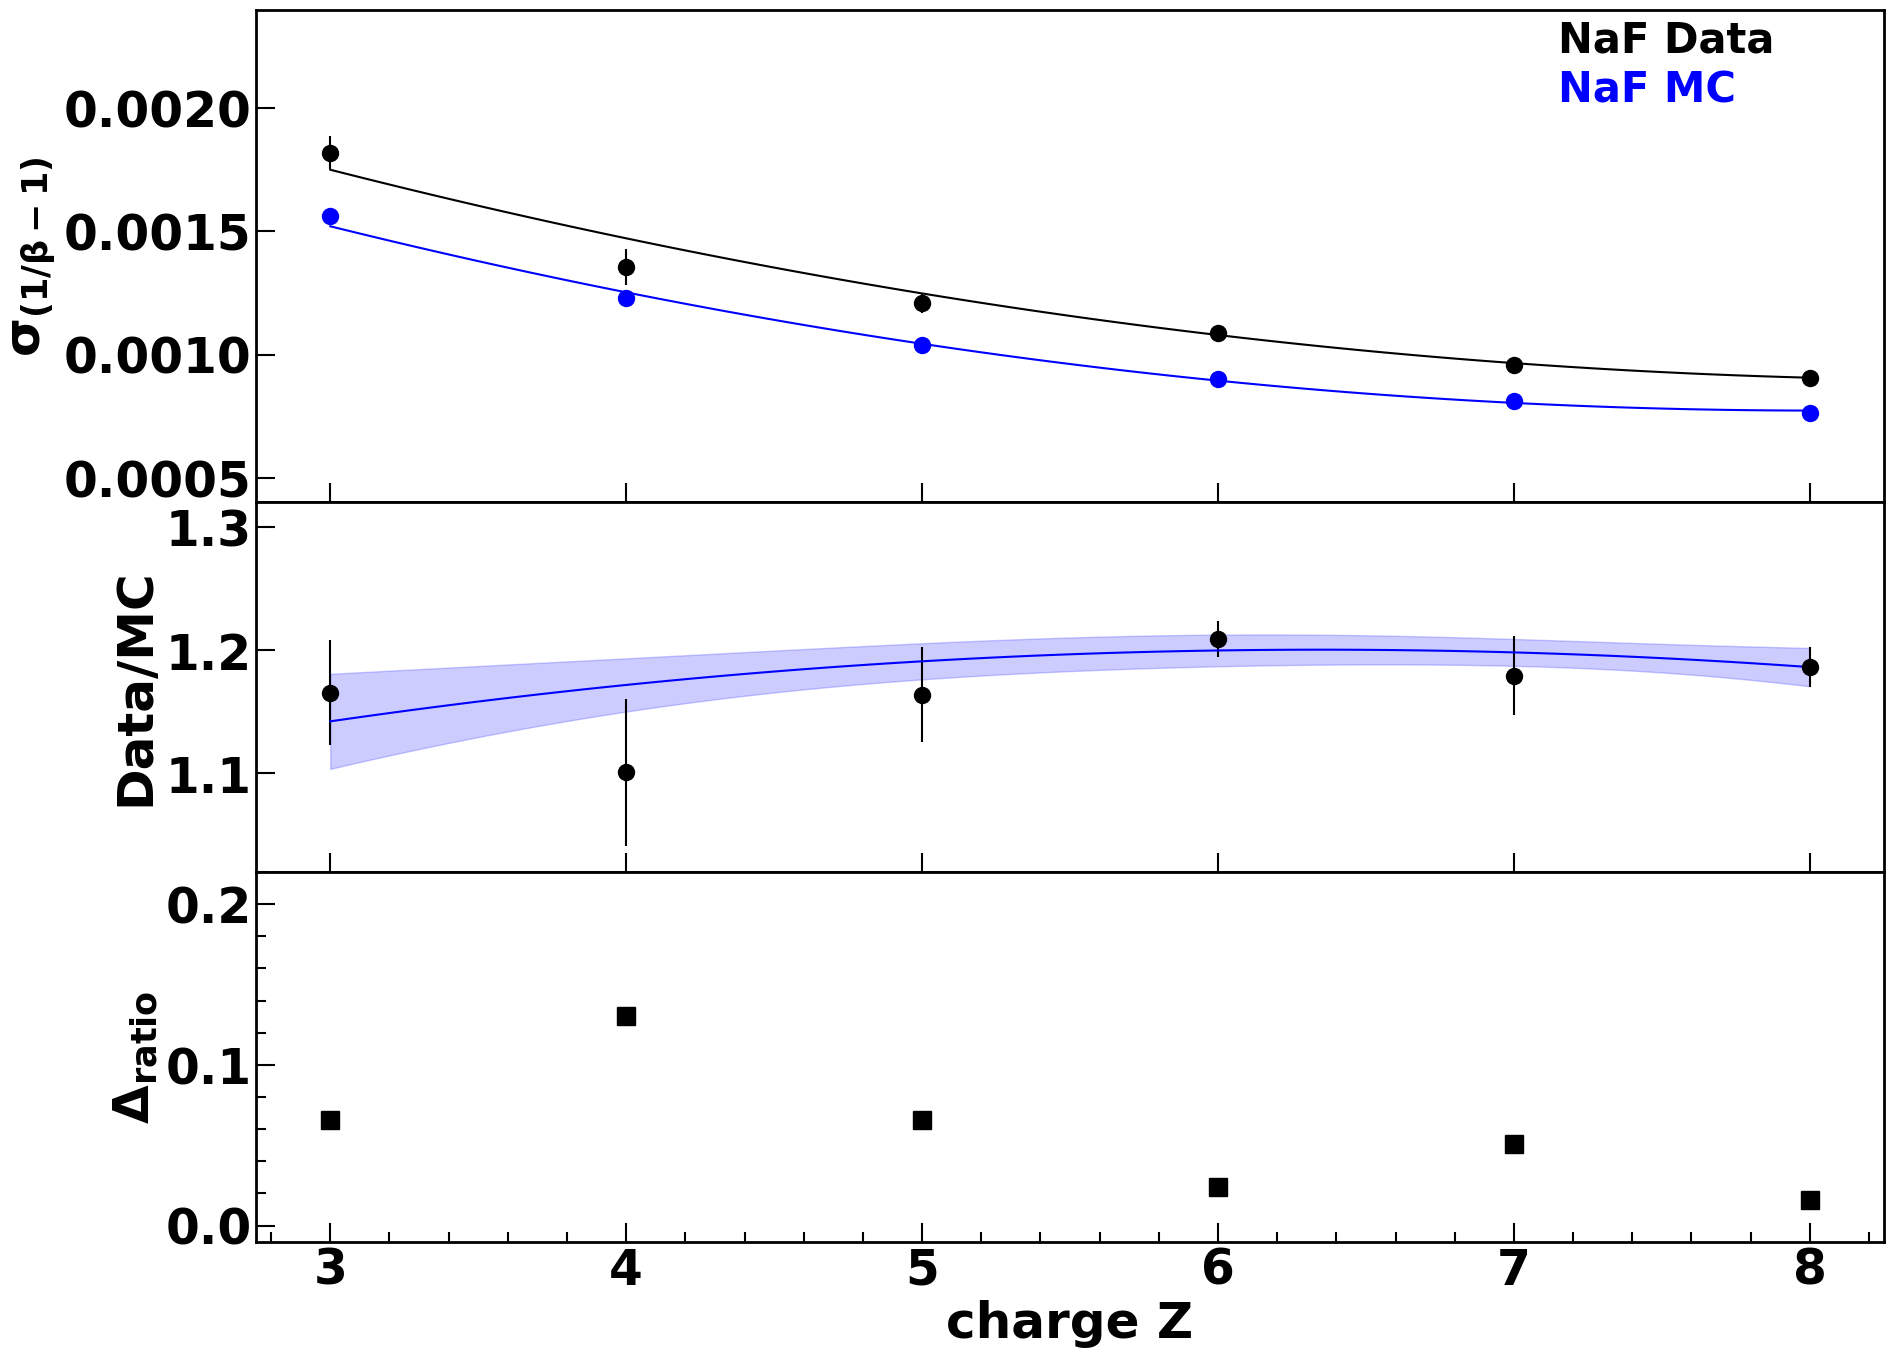

In [77]:
graphfit_sigmavsz_iss = {}
graphfit_sigmavsz_mc = {}
sigmaiss_parpolyfit = {}
sigmamc_parpolyfit = {}
graphfit_sigmaratio = {}
sigmaratio_parpolyfit = {}

dec= 'NaF'

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.4, 0.3, 0.3]}, figsize=(21, 16)) 
set_plotstyle(ax1, ax2)
set_plotstyle(ax2, ax3)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=23, label=f'{dec} Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=23, label=f'{dec} MC')  

ax1.set_ylabel(r'$\mathrm{\sigma_{(1/\beta -1)}}$')
ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
ax1.text(0.8, 0.88, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='bold')
#ax1.legend()
ax1.set_ylim([0.0004, 0.0024])
ax1.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=23, label=f'Data/MC')  
graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs
ax3.set_xticks([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])

p0 = [0.0005, 0.01, 0.01]
graphfit_sigmavsz_iss[dec], sigmaiss_parpolyfit[dec] = getpolyfit(graph_sigmavsz_iss[dec], p0)
graphfit_sigmavsz_mc[dec], sigmamc_parpolyfit[dec] = getpolyfit(graph_sigmavsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaiss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmamc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
graph_ratio = graph_iss/graph_mc

p0 = [0.0005, 0.01, 0.1]
graphfit_sigmaratio[dec], sigmaratio_parpolyfit[dec] = getpolyfit(graph_ratio_sigma[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio-yfiterr_ratio, yfit_ratio+yfiterr_ratio, color=mccolor, alpha=0.2) 

#plot_graph(fig, ax2, graph_ratio, color='black',  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
yvaluesmaxdiff = abs(graphfit_sigmaratio[dec].yvalues - graph_ratio_sigma[dec].yvalues) + abs(graph_ratio_sigma[dec].yerrs)

graph_maxdiff = MGraph(graph_ratio_sigma[dec].xvalues, yvaluesmaxdiff, np.zeros_like(graph_ratio_sigma[dec].xvalues))
plot_graph(fig, ax3, graph_maxdiff, color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=13, label=f'', marker='s')  
#ax2.fill_between(graph_ratio.xvalues, graph_ratio.yvalues-graph_ratio.yerrs, graph_ratio.yvalues+graph_ratio.yerrs, color='grey', alpha=0.2)  

ax3.set_ylabel(r'$\mathrm{\Delta_{ratio}}$')
ax2.set_ylim([1.02, 1.32])
ax3.set_xlabel('charge Z')
ax2.set_ylabel('Data/MC')
ax3.set_ylim([-0.01, 0.22])
print(plotfile)

savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}V0Apr", show=True) 

/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


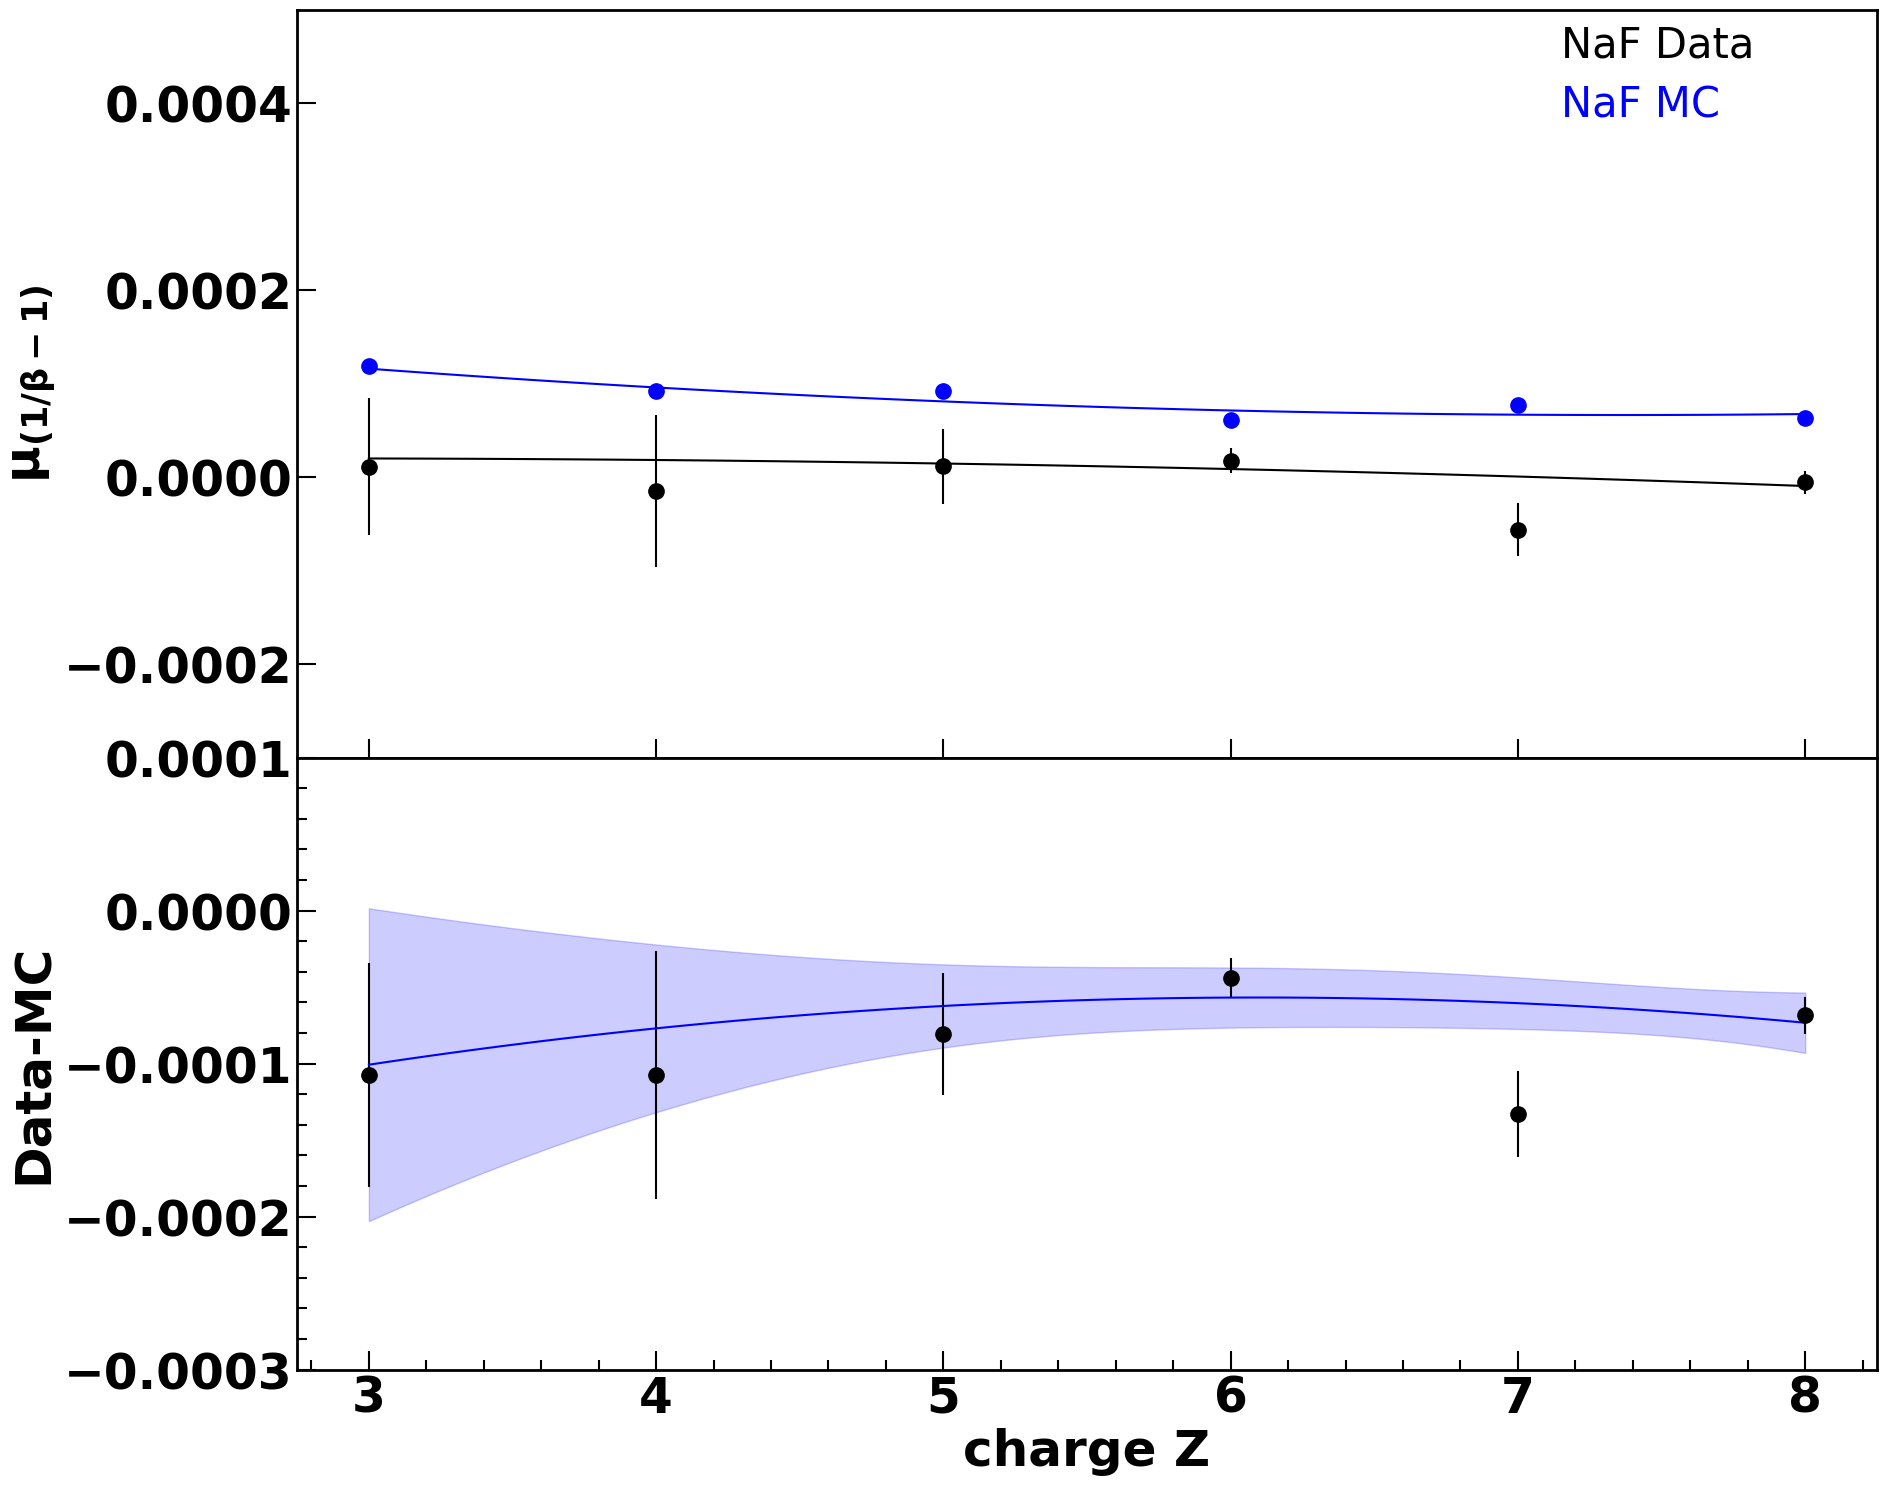

In [48]:
dec= 'NaF'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
fig.subplots_adjust(left= 0.16, right=0.95, bottom=0.1, top=0.95) 
plot_graph(fig, ax1, graph_meanvsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'') 
plot_graph(fig, ax1, graph_meanvsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'')  
ax2.set_xlabel('charge Z')
ax1.set_ylabel(r'$\mathrm{\mu_{(1/\beta -1)}}$')

ax1.text(0.8, 0.98, f'{dec} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
ax1.text(0.8, 0.9, f'{dec} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')

ax1.set_ylim([-0.0003, 0.0005])
ax1.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
p0 = [0.0001, 0.01, 0.01]
graphfit_meanvsz_iss[dec], meaniss_parpolyfit[dec] = getpolyfit(graph_meanvsz_iss[dec], p0)
graphfit_meanvsz_mc[dec], meanmc_parpolyfit[dec] = getpolyfit(graph_meanvsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), meaniss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), meanmc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
ydeltamean = graph_iss.yvalues - graph_mc.yvalues
#ax2.plot(np.linspace(3, 8, 100), ydeltamean, '-', color='black')

graph_diff_mean[dec].yvalues = graph_meanvsz_iss[dec].yvalues - graph_meanvsz_mc[dec].yvalues
graph_diff_mean[dec].yerrs = np.sqrt(graph_meanvsz_iss[dec].yerrs**2 + graph_meanvsz_mc[dec].yerrs**2 - 2*graph_meanvsz_iss[dec].yerrs*graph_meanvsz_mc[dec].yerrs*0.1)

plot_graph(fig, ax2, graph_diff_mean[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
ax2.set_ylim([-0.0003, 0.0001])
ax2.set_xticks([3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
ax2.set_ylabel('Data-MC')

p0 = [0.00001, 0.01, 0.01]
graphfit_mean_ratio[dec], meanratio_parpolyfit[dec] = getpolyfit(graph_diff_mean[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), meanratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio-yfiterr_ratio, yfit_ratio+ yfiterr_ratio, color=mccolor, alpha=0.2) 

print(plotfile)
savefig_tofile(fig, plotfile, f"graph_mean_{dec}_{figsuffix}", show=True) 



In [ ]:
dec= 'NaF'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(20, 16)) 
set_plotstyle(ax1, ax2)
plot_graph(fig, ax1, graph_sigmavsz_iss[dec], color=isscolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data') 
plot_graph(fig, ax1, graph_sigmavsz_mc[dec], color=mccolor,  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'MC')  
#plot_graph(fig, ax1, graph_sigmavsz_mctuned[dec], color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'MC tuned')  
graph_ratio_sigma[dec] = graph_sigmavsz_iss[dec]/graph_sigmavsz_mc[dec]
plot_graph(fig, ax2, graph_ratio_sigma[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
#graph_ratio_sigma[dec].yerrs = graph_ratio_sigma[dec].yerrs*0.6

p0 = [0.0005, 0.01, 0.01]
graphfit_sigmaratio[dec], sigmaratio_parpolyfit[dec] = getpolyfit(graph_ratio_sigma[dec], p0)
yfit_ratio, yfiterr_ratio = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaratio_parpolyfit[dec], upoly)
ax2.plot(np.linspace(3, 8, 100), yfit_ratio, '-', color=mccolor)
ax2.fill_between(np.linspace(3, 8, 100), yfit_ratio-yfiterr_ratio, yfit_ratio+yfiterr_ratio, color=mccolor, alpha=0.2) 
#plot_graph(fig, ax2, graphfit_sigmaratio[dec], color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  

graphfit_sigmavsz_iss[dec], sigmaiss_parpolyfit[dec] = getpolyfit(graph_sigmavsz_iss[dec], p0)
graphfit_sigmavsz_mc[dec], sigmamc_parpolyfit[dec] = getpolyfit(graph_sigmavsz_mc[dec], p0)
yfit_iss, yfiterr_iss = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmaiss_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_iss, '-', color=isscolor)
yfit_mc, yfiterr_mc = get_fitpdf_witherr(np.linspace(3, 8, 100), sigmamc_parpolyfit[dec], upoly)
ax1.plot(np.linspace(3, 8, 100), yfit_mc, '-', color=mccolor)

graph_iss = MGraph(np.linspace(3, 8, 100), yfit_iss, yfiterr_iss)
graph_mc = MGraph(np.linspace(3, 8, 100), yfit_mc, yfiterr_mc)
graph_ratio = graph_iss/graph_mc
#plot_graph(fig, ax2, graph_ratio, color='black',  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data/MC')  
 
ax1.legend()
set_plot_style(ax1)
set_plot_style(ax2)
SetAx1Axis(ax1, '',r'$\mathrm{\sigma_{(1/\beta -1)}}$' , TEXTSIZE, xlimrange=None, ylimrange=[0.0006, 0.0022],custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
SetAx1Axis(ax2, 'charge Z', 'Data/MC' , TEXTSIZE, ylimrange=[1.02, 1.3], custom_ticks=[3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
print(plotfile)
savefig_tofile(fig, plotfile, f"graph_sigma_{dec}_{figsuffix}_Apr", show=True)


/home/manbing/Documents/lithiumanalysis/slides/plots/BetaResolutionAtHighR


KeyError: 'Tof'

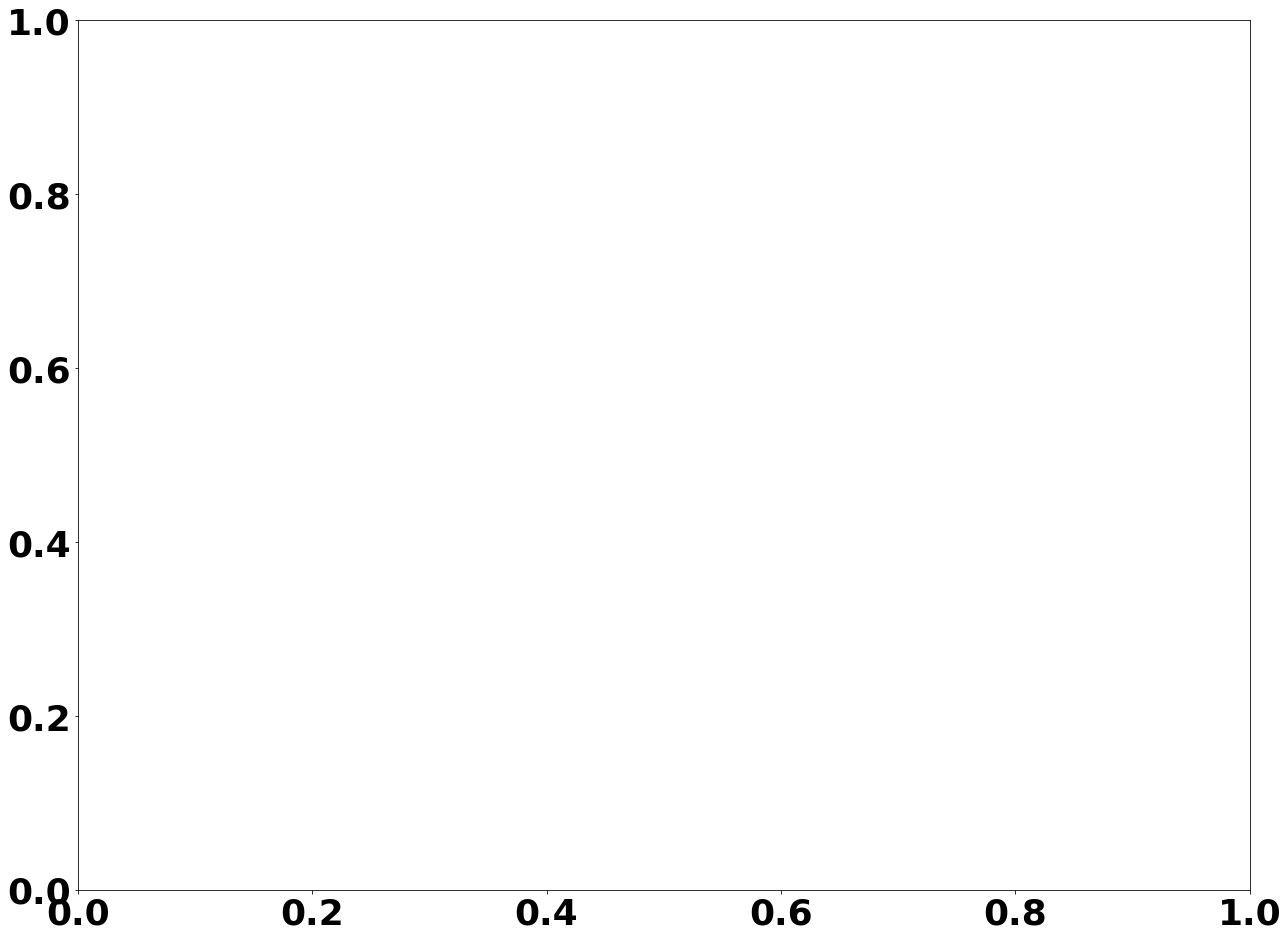

In [76]:
from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'Tof'

fig1, ax1 = plt.subplots(1, 1, figsize=(21, 16))
plot_histogram_1d(ax1, hist_mcTrueR[dec][isotopes[0]], style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
beta_min = calc_beta(100, ISOTOPES_MASS[isotopes[0]], ISOTOPES_CHARGE[isotopes[0]])
ax1.set_xlim([10, 400])
print(beta_min)


print(hist_issbeta_sv)
xrange = {'mc': {"Tof": [-0.02, 0.02], "NaF": [-0.0023, 0.0028], 'Agl':[-0.00065, 0.00095]},
          'iss': {"Tof": [-0.02, 0.02], "NaF": [-0.0025, 0.0028], 'Agl':[-0.0008, 0.0008]}}
xbinrange = {'iss': hist_issbeta_sv[dec].binnings[0].get_indices(xrange['iss'][dec]),
             'mc': hist_issbeta_sv[dec].binnings[0].get_indices(xrange['mc'][dec])}


xedges_iss = hist_issbeta_sv[dec].binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
xvalue_iss = hist_issbeta_sv[dec].binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
yvalue_iss = hist_issbeta_sv[dec].values[xbinrange['iss'][0]:xbinrange['iss'][1]]
yvalueserr_iss = np.sqrt(hist_issbeta_sv[dec].squared_values[xbinrange['iss'][0]:xbinrange['iss'][1]])
#yvalueserr_iss = np.sqrt(yvalue_iss)

xedges_mc = hist_mcbeta[dec].binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
xvalue_mc = hist_mcbeta[dec].binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
yvalue_mc = hist_mcbeta[dec].values[xbinrange['mc'][0]:xbinrange['mc'][1]]

yvalueserr_mc = np.sqrt(hist_mcbeta[dec].squared_values[xbinrange['mc'][0]:xbinrange['mc'][1]])


guess_iss = dict(counts=100, mu=0.0001, sigma=0.001, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.0005, sigma_ratio=2.0, fraction_sec=0.1)

guess_gaus_iss = dict(norm=0.001, mu=-0.001, sigma=0.01)
guess_gaus_mc = dict(norm=0.001, mu=0.0002, sigma=0.009)
#par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
#par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                  
par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)                                                                                                                                                                                    

for key in guess_gaus_iss.keys():
    guess_gaus_iss[key] = par_iss[key]
    guess_gaus_mc[key] = par_mc[key]
    
xrange_iter2 = [guess_gaus_iss['mu'] - 1.6 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 1.6 * guess_gaus_iss['sigma']]
xrange_iter2_mc = [guess_gaus_mc['mu'] - 1.6 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 1.6 * guess_gaus_mc['sigma']]
xbinrange2 = hist_issbeta_sv[dec].binnings[0].get_indices(xrange_iter2)
xbinrange2mc = hist_issbeta_sv[dec].binnings[0].get_indices(xrange_iter2_mc)
    
xedges_iss = hist_issbeta_sv[dec].binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
xvalue_iss = hist_issbeta_sv[dec].binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
yvalue_iss = hist_issbeta_sv[dec].values[xbinrange2[0]:xbinrange2[1]]
yvalueserr_iss = np.sqrt(hist_issbeta_sv[dec].squared_values[xbinrange2[0]:xbinrange2[1]])
#yvalueserr_iss = np.sqrt(yvalue_iss)  
yvalueserr_iss[yvalueserr_iss==0.0] = 0.0001

xedges_mc = hist_mcbeta[dec].binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
xvalue_mc = hist_mcbeta[dec].binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
yvalue_mc = hist_mcbeta[dec].values[xbinrange2mc[0]:xbinrange2mc[1]]
yvalueserr_mc = np.sqrt(hist_mcbeta[dec].squared_values[xbinrange2mc[0]:xbinrange2mc[1]])
yvalueserr_mc[yvalueserr_mc==0.0] = 0.0001

par_iss, parerr_iss = minuitfit_Chi(xvalue_iss, yvalue_iss, yvalueserr_iss, normalized_gaussian , guess_gaus_iss)
par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)

fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                


from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, plot1d_step, FONTSIZE, set_plot_defaultstyle 
fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
plot_histogram_1d(ax3, hist_issbeta_sv[dec], style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
plot_histogram_1d(ax3, hist_mcbeta[dec], style="iss", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax3.text(0.5, 0.98, f"{dec} Before tuning (R >200GV)", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
ax3.text(0.01, 0.98, f"No Edge Paddles", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold") 
fit_info = [f"$\\mu$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}"]

ax3.text(0.63, 0.9, f'{nucleiname[nuclei]} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.85, f"$\\mu:$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.8, f"$\\sigma:$ {par_iss['sigma']:.5f}$\\pm$ {parerr_iss['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
#ax3.set_ylim([0.00001, 0.07])
ax3.set_ylim([0.00005, 0.1])


ax3.text(0.63, 0.72, f'{MCName} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.67, f"$\\mu:$ {par_mc['mu']:.5f}$\\pm$ {parerr_mc['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.62, f"$\\sigma:$ {par_mc['sigma']:.5f}$\\pm$ {parerr_mc['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.set_ylabel('Normalized events')
ax3.set_xlim([-0.07, 0.1])
ax3.set_xlabel(r'$\mathrm{1/\beta - 1}$')
#ax3.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 
savefig_tofile(fig3, plotfile, f"Tofbeta1_highR_beforetune_{nucleiname[nuclei]}_NoEdgePaddle_Fit2Sig", show=True) 


In [50]:
from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'Tof'
xrange = {'mc': {"Tof": [-0.01, 0.01], "NaF": [-0.0023, 0.0028], 'Agl':[-0.00065, 0.00095]},
          'iss': {"Tof": [-0.01, 0.01], "NaF": [-0.0025, 0.0028], 'Agl':[-0.0008, 0.0008]}}
xbinrange = {'iss': hist_issbeta_sv[dec].binnings[0].get_indices(xrange['iss'][dec]),
             'mc': hist_issbeta_sv[dec].binnings[0].get_indices(xrange['mc'][dec])}


xedges_iss1 = hist_issbeta_sv[dec].binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
xvalue_iss1 = hist_issbeta_sv[dec].binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
yvalue_iss1 = hist_issbeta_sv[dec].values[xbinrange['iss'][0]:xbinrange['iss'][1]]

print(yvalue_iss1)

xedges_mc1 = hist_mcbeta[dec].binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
xvalue_mc1 = hist_mcbeta[dec].binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
yvalue_mc1 = hist_mcbeta[dec].values[xbinrange['mc'][0]:xbinrange['mc'][1]]

guess_iss = dict(counts=0.1, mu=0.0001, sigma=0.005, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.005, sigma_ratio=2.0, fraction_sec=0.1)

guess_gaus_iss = dict(norm=0.001, mu=-0.001, sigma=0.01)
guess_gaus_mc = dict(norm=0.001, mu=0.0002, sigma=0.01)
par_iss, parerr_iss = minuitfit_LL(yvalue_iss1, xedges_iss1 , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc1, xedges_mc1, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                                                                                                                                                                                                
for key in guess_gaus_iss.keys():
    guess_gaus_iss[key] = par_iss[key]
    guess_gaus_mc[key] = par_mc[key]

xrange_iter2 = [guess_gaus_iss['mu'] - 2.3 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 2.3 * guess_gaus_iss['sigma']]
xrange_iter2_mc = [guess_gaus_mc['mu'] - 3.0 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 3.0 * guess_gaus_mc['sigma']]
xbinrange2 = hist_issbeta_sv[dec].binnings[0].get_indices(xrange_iter2)
xbinrange2mc = hist_issbeta_sv[dec].binnings[0].get_indices(xrange_iter2_mc)
    
xedges_iss = hist_issbeta_sv[dec].binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
xvalue_iss = hist_issbeta_sv[dec].binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
yvalue_iss = hist_issbeta_sv[dec].values[xbinrange2[0]:xbinrange2[1]]

xedges_mc = hist_mcbeta[dec].binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
xvalue_mc = hist_mcbeta[dec].binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
yvalue_mc = hist_mcbeta[dec].values[xbinrange2mc[0]:xbinrange2mc[1]]
    
par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc , cumulative_norm_gaus, guess_gaus_mc)  
print("iss iter2:", par_iss) 
print("mc iter2:", par_mc) 

fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                
print(fit_y_iss)
fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
ax1.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
#ax1.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
plot_histogram_1d(ax1, hist_issbeta_sv[dec], style="iss", color=isscolor, label='Data', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
#plot_histogram_1d(ax1, hist_mcbeta[dec], style="iss", color=mccolor, label='MC', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax1.text(0.05, 0.98, f"{dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
ax1.legend()
#ax1.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 

fig2, ax2 = plt.subplots(1, 1, figsize=(21, 16))
#ax1.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
ax2.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
#plot_histogram_1d(ax1, hist_issbeta_sv, style="iss", color=isscolor, label='Data', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
plot_histogram_1d(ax2, hist_mcbeta[dec], style="iss", color=mccolor, label='Be MC', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax2.text(0.05, 0.98, f"{dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", fontweight="bold") 
#ax2.set_ylim([0.0001, 0.2])
#ax2.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 
ax2.legend()


fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
plot_histogram_1d(ax3, hist_issbeta_sv[dec], style="iss", color=isscolor, label='Data', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
plot_histogram_1d(ax3, hist_mcbeta[dec], style="iss", color=mccolor, label='Be MC', scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax3.text(0.05, 0.98, f"{dec} Before tuning", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
#ax3.set_ylim([0.0001, 0.1])
#ax3.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 
ax3.legend()


KeyError: 'Tof'

[0.0190366  0.01991459 0.02089902 0.02116508 0.02249538 0.02233574
 0.02351971 0.02445092 0.02519589 0.02567479 0.02562158 0.02498304
 0.02488992 0.02378577 0.02425137 0.02411834 0.02262841 0.02222932
 0.02173711 0.02032699 0.01978156 0.0199545  0.01753336 0.01785263
 0.01680169 0.01464661 0.01442045 0.01309015]
iss iter2: <ValueView norm=0.0006993449433596097 mu=-0.002363612550073447 sigma=0.011536105452331727>
mc iter2: <ValueView norm=0.0007328254005573827 mu=0.0005894314266699819 sigma=0.011613473096764736>


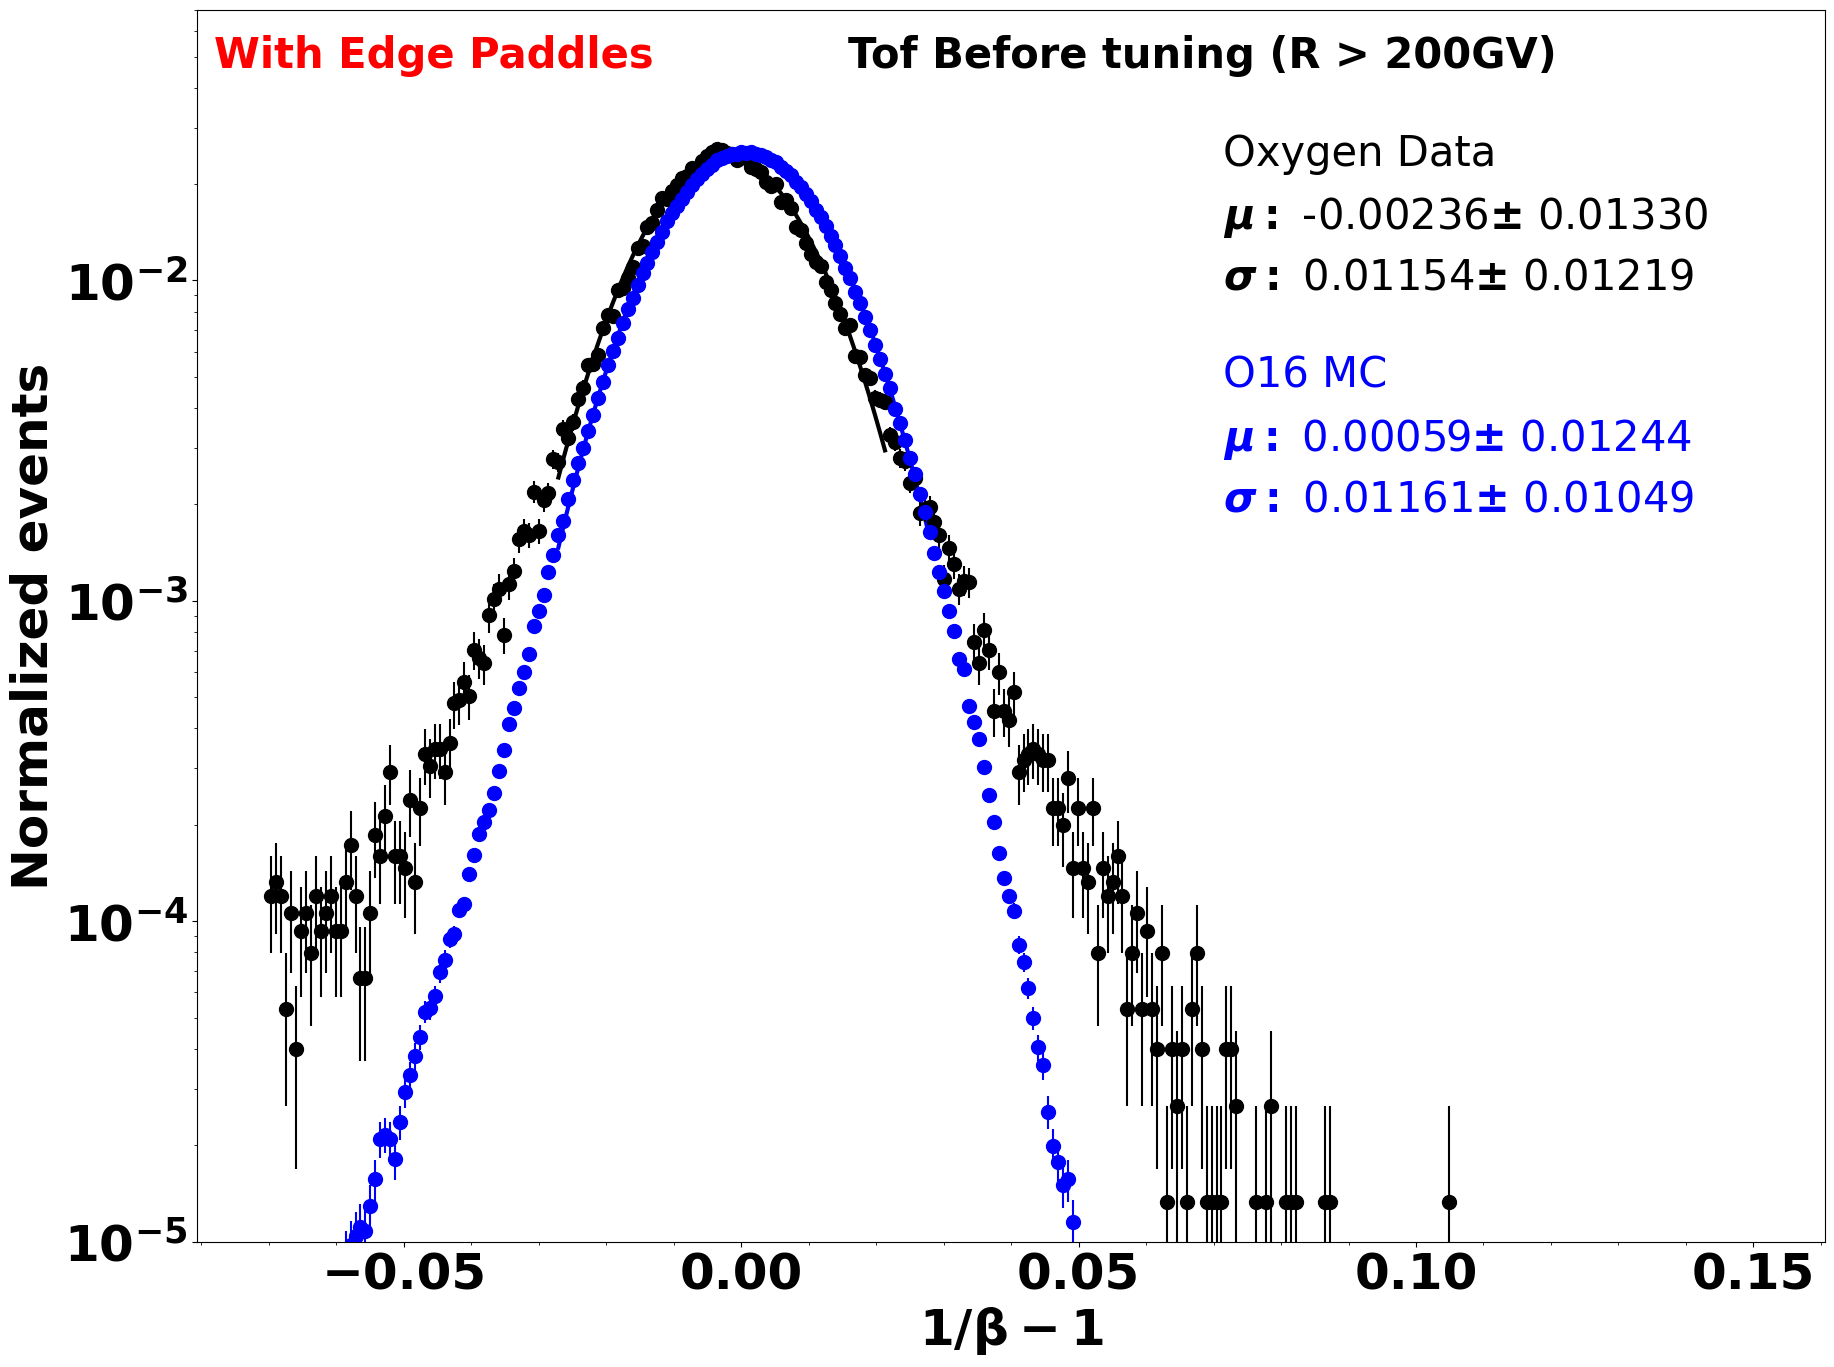

In [51]:
###################################
#read file newtof mc and compare
filename_hist_newtof = '/home/manbing/Documents/Data/data_BeP8/O_betaHighR_B1236P8_TofWithPetalSide_beta1.npz'
df_newtof = np.load(f'{filename_hist_newtof}')
hist_iss_newTof =  WeightedHistogram.from_file(df_newtof, f'hist_issbetareso_Tof')
hist_mc_newTof =  WeightedHistogram.from_file(df_newtof, f'hist_mcbetareso_mix_Tof')
hist_iss_newTof = hist_iss_newTof * (1/np.sum(hist_iss_newTof.values))
hist_mc_newTof = hist_mc_newTof * (1/np.sum(hist_mc_newTof.values))
####################################

from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'Tof'
xrange = {'mc': {"Tof": [-0.01, 0.01], "NaF": [-0.0023, 0.0028], 'Agl':[-0.00065, 0.00095]},
          'iss': {"Tof": [-0.01, 0.01], "NaF": [-0.0025, 0.0028], 'Agl':[-0.0008, 0.0008]}}
xbinrange = {'iss': hist_iss_newTof.binnings[0].get_indices(xrange['iss'][dec]),
             'mc': hist_iss_newTof.binnings[0].get_indices(xrange['mc'][dec])}


xedges_iss1 = hist_iss_newTof.binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
xvalue_iss1 = hist_iss_newTof.binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
yvalue_iss1 = hist_iss_newTof.values[xbinrange['iss'][0]:xbinrange['iss'][1]]

print(yvalue_iss1)

xedges_mc1 = hist_mc_newTof.binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
xvalue_mc1 = hist_mc_newTof.binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
yvalue_mc1 = hist_mc_newTof.values[xbinrange['mc'][0]:xbinrange['mc'][1]]

guess_iss = dict(counts=0.1, mu=0.0001, sigma=0.005, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.005, sigma_ratio=2.0, fraction_sec=0.1)

guess_gaus_iss = dict(norm=0.001, mu=-0.001, sigma=0.01)
guess_gaus_mc = dict(norm=0.001, mu=0.0002, sigma=0.01)
par_iss, parerr_iss = minuitfit_LL(yvalue_iss1, xedges_iss1 , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc1, xedges_mc1, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                                                                                                                                                                                                
for key in guess_gaus_iss.keys():
    guess_gaus_iss[key] = par_iss[key]
    guess_gaus_mc[key] = par_mc[key]

xrange_iter2 = [guess_gaus_iss['mu'] - 2.3 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 2.3 * guess_gaus_iss['sigma']]
xrange_iter2_mc = [guess_gaus_mc['mu'] - 2.3 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.3 * guess_gaus_mc['sigma']]
xbinrange2 = hist_iss_newTof.binnings[0].get_indices(xrange_iter2)
xbinrange2mc = hist_iss_newTof.binnings[0].get_indices(xrange_iter2_mc)
    
xedges_iss = hist_iss_newTof.binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
xvalue_iss = hist_iss_newTof.binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
yvalue_iss = hist_iss_newTof.values[xbinrange2[0]:xbinrange2[1]]

xedges_mc = hist_mc_newTof.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
xvalue_mc = hist_mc_newTof.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
yvalue_mc = hist_mc_newTof.values[xbinrange2mc[0]:xbinrange2mc[1]]
    
par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc , cumulative_norm_gaus, guess_gaus_mc)  
print("iss iter2:", par_iss) 
print("mc iter2:", par_mc) 

fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                

fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
plot_histogram_1d(ax3, hist_iss_newTof, style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
plot_histogram_1d(ax3, hist_mc_newTof, style="iss", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax3.text(0.4, 0.98, f"{dec} Before tuning (R > 200GV)", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
ax3.text(0.01, 0.98, f"With Edge Paddles", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold") 
fit_info = [f"$\\mu$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}"]

ax3.text(0.63, 0.9, 'Oxygen Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.85, f"$\\mu:$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.8, f"$\\sigma:$ {par_iss['sigma']:.5f}$\\pm$ {parerr_iss['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.set_ylim([0.00001, 0.07])

ax3.text(0.63, 0.72, 'O16 MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.67, f"$\\mu:$ {par_mc['mu']:.5f}$\\pm$ {parerr_mc['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.62, f"$\\sigma:$ {par_mc['sigma']:.5f}$\\pm$ {parerr_mc['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.set_ylabel('Normalized events')
ax3.set_xlabel(r'$\mathrm{1/\beta - 1}$')
#ax3.set_xlim([-0.0, 0.05])
#ax3.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 
savefig_tofile(fig3, plotfile, f"Tof_beta1_highR_beforetune_{nuclei}_WithEdgePaddle", show=True) 


[0.01649085 0.01843094 0.01891597 0.01861283 0.02137141 0.02143204
 0.02419061 0.02452407 0.0258882  0.02816176 0.02694919 0.02861647
 0.02910149 0.02813144 0.02852552 0.02867709 0.0280405  0.02679762
 0.02594883 0.0245847  0.02455438 0.0247969  0.02121984 0.02261428
 0.01964351 0.0181278  0.01715775 0.01573299]
iss iter2: <ValueView norm=0.0006890914203684088 mu=-0.00037271884605865013 sigma=0.010023570576920354>
mc iter2: <ValueView norm=0.0007290689595261207 mu=0.0004858455501608128 sigma=0.007684140061622298>


Text(0, 0.5, 'Normalized events')

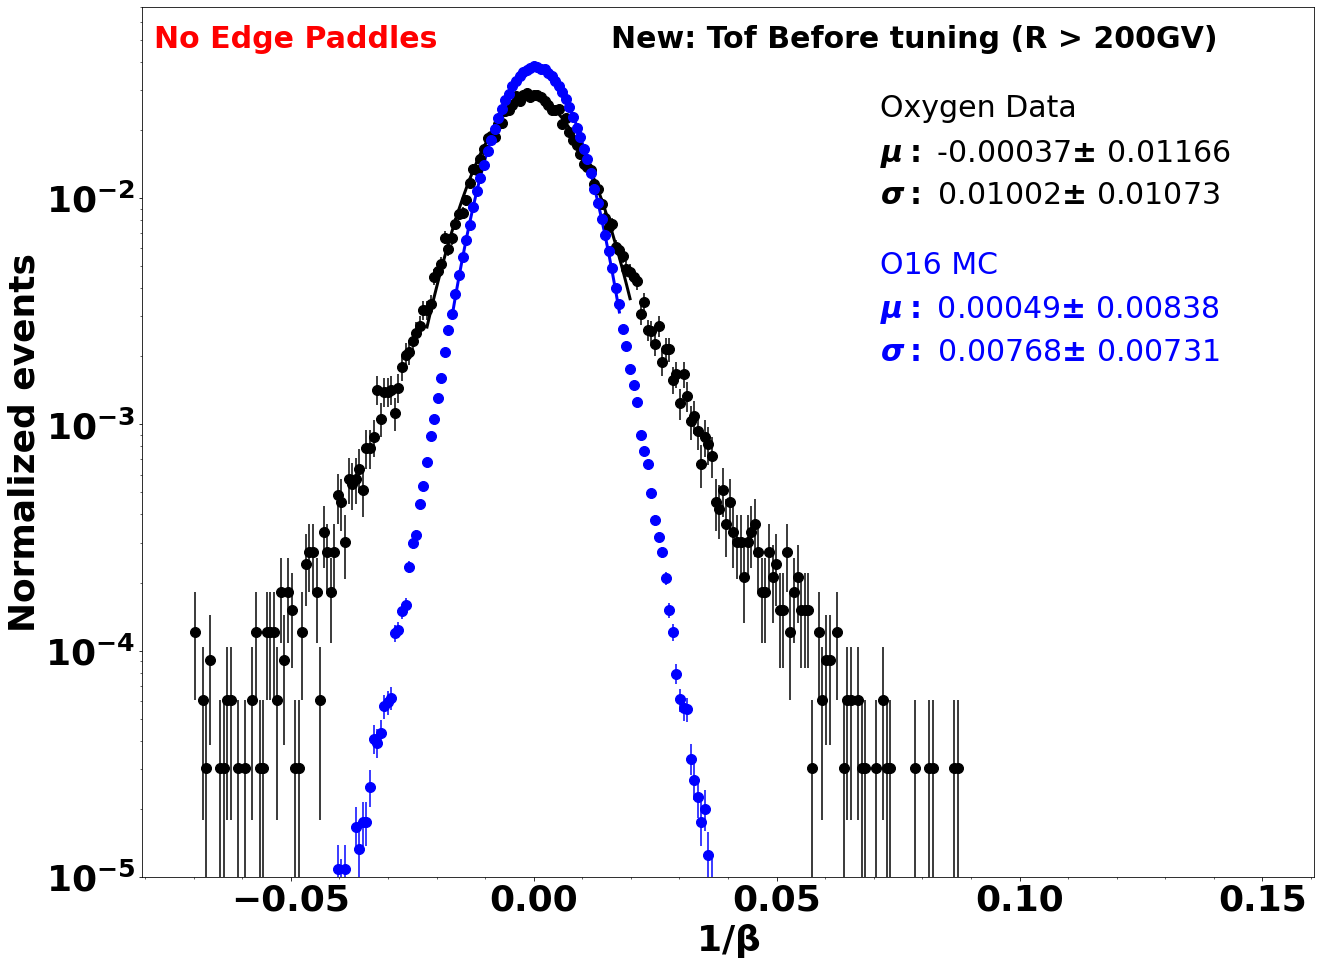

In [43]:
###################################
#read file newtof mc and compare
filename_hist_newtof = '/home/manbing/Documents/Data/data_BeP8/O_betaHighR_B1236P8_tofBetaMC2.npz'
df_newtof = np.load(f'{filename_hist_newtof}')
hist_iss_newTof =  WeightedHistogram.from_file(df_newtof, f'hist_issbetareso_Tof')
hist_mc_newTof =  WeightedHistogram.from_file(df_newtof, f'hist_mcbetareso_mix_Tof')
hist_iss_newTof = hist_iss_newTof * (1/np.sum(hist_iss_newTof.values))
hist_mc_newTof = hist_mc_newTof * (1/np.sum(hist_mc_newTof.values))
####################################


from tools.functions import cumulative_norm_gaus, normalized_gaussian
dec = 'Tof'
xrange = {'mc': {"Tof": [-0.01, 0.01], "NaF": [-0.0023, 0.0028], 'Agl':[-0.00065, 0.00095]},
          'iss': {"Tof": [-0.01, 0.01], "NaF": [-0.0025, 0.0028], 'Agl':[-0.0008, 0.0008]}}
xbinrange = {'iss': hist_iss_newTof.binnings[0].get_indices(xrange['iss'][dec]),
             'mc': hist_iss_newTof.binnings[0].get_indices(xrange['mc'][dec])}


xedges_iss1 = hist_iss_newTof.binnings[0].edges[xbinrange['iss'][0]:xbinrange['iss'][1]+1]
xvalue_iss1 = hist_iss_newTof.binnings[0].bin_centers[xbinrange['iss'][0]:xbinrange['iss'][1]]
yvalue_iss1 = hist_iss_newTof.values[xbinrange['iss'][0]:xbinrange['iss'][1]]

print(yvalue_iss1)

xedges_mc1 = hist_mc_newTof.binnings[0].edges[xbinrange['mc'][0]:xbinrange['mc'][1]+1]
xvalue_mc1 = hist_mc_newTof.binnings[0].bin_centers[xbinrange['mc'][0]:xbinrange['mc'][1]]
yvalue_mc1 = hist_mc_newTof.values[xbinrange['mc'][0]:xbinrange['mc'][1]]

guess_iss = dict(counts=0.1, mu=0.0001, sigma=0.005, sigma_ratio=1.3, fraction_sec=0.1)                                                                                                                          
guess_mc = dict(counts=0.01, mu=0.00001, sigma=0.005, sigma_ratio=2.0, fraction_sec=0.1)

guess_gaus_iss = dict(norm=0.001, mu=-0.001, sigma=0.01)
guess_gaus_mc = dict(norm=0.001, mu=0.0002, sigma=0.01)
par_iss, parerr_iss = minuitfit_LL(yvalue_iss1, xedges_iss1 , cumulative_norm_gaus, guess_gaus_iss)                                                                                                                  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc1, xedges_mc1, cumulative_norm_gaus, guess_gaus_mc)                                                                                                                                                                                                                                                                                                
for key in guess_gaus_iss.keys():
    guess_gaus_iss[key] = par_iss[key]
    guess_gaus_mc[key] = par_mc[key]

xrange_iter2 = [guess_gaus_iss['mu'] - 2.3 * guess_gaus_iss['sigma'], guess_gaus_iss['mu'] + 2.3 * guess_gaus_iss['sigma']]
xrange_iter2_mc = [guess_gaus_mc['mu'] - 2.3 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.3 * guess_gaus_mc['sigma']]
xbinrange2 = hist_iss_newTof.binnings[0].get_indices(xrange_iter2)
xbinrange2mc = hist_iss_newTof.binnings[0].get_indices(xrange_iter2_mc)
    
xedges_iss = hist_iss_newTof.binnings[0].edges[xbinrange2[0]:xbinrange2[1]+1]
xvalue_iss = hist_iss_newTof.binnings[0].bin_centers[xbinrange2[0]:xbinrange2[1]]
yvalue_iss = hist_iss_newTof.values[xbinrange2[0]:xbinrange2[1]]

xedges_mc = hist_mc_newTof.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
xvalue_mc = hist_mc_newTof.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
yvalue_mc = hist_mc_newTof.values[xbinrange2mc[0]:xbinrange2mc[1]]
    
par_iss, parerr_iss = minuitfit_LL(yvalue_iss, xedges_iss , cumulative_norm_gaus, guess_gaus_iss)  
par_mc, parerr_mc = minuitfit_LL(yvalue_mc, xedges_mc , cumulative_norm_gaus, guess_gaus_mc)  
print("iss iter2:", par_iss) 
print("mc iter2:", par_mc) 

fit_y_iss = normalized_gaussian(xvalue_iss, *par_iss)                                                                                                                                                              
fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc)                                                                                                                                                                

fig3, ax3 = plt.subplots(1, 1, figsize=(21, 16))
ax3.plot(xvalue_iss, fit_y_iss, '-', linewidth=3, color='black')
ax3.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
plot_histogram_1d(ax3, hist_iss_newTof, style="iss", color=isscolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
plot_histogram_1d(ax3, hist_mc_newTof, style="iss", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
ax3.text(0.4, 0.98, f"New: {dec} Before tuning (R > 200GV)", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="black", fontweight="bold") 
ax3.text(0.01, 0.98, f"No Edge Paddles", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color="red", fontweight="bold") 
fit_info = [f"$\\mu$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}"]

ax3.text(0.63, 0.9, 'Oxygen Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.85, f"$\\mu:$ {par_iss['mu']:.5f}$\\pm$ {parerr_iss['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.text(0.63, 0.8, f"$\\sigma:$ {par_iss['sigma']:.5f}$\\pm$ {parerr_iss['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
ax3.set_ylim([0.00001, 0.07])

ax3.text(0.63, 0.72, 'O16 MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.67, f"$\\mu:$ {par_mc['mu']:.5f}$\\pm$ {parerr_mc['mu']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.text(0.63, 0.62, f"$\\sigma:$ {par_mc['sigma']:.5f}$\\pm$ {parerr_mc['sigma']:.5f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=mccolor, weight='normal')  
ax3.set_ylabel('Normalized events')

#ax3.set_xlim([-0.0, 0.05])
#ax3.set_xticks([-0.01, -0.005, 0.0,  0.005, 0.01]) 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'hist_beta_Agl_Be7_dimensions is not a file in the archive'

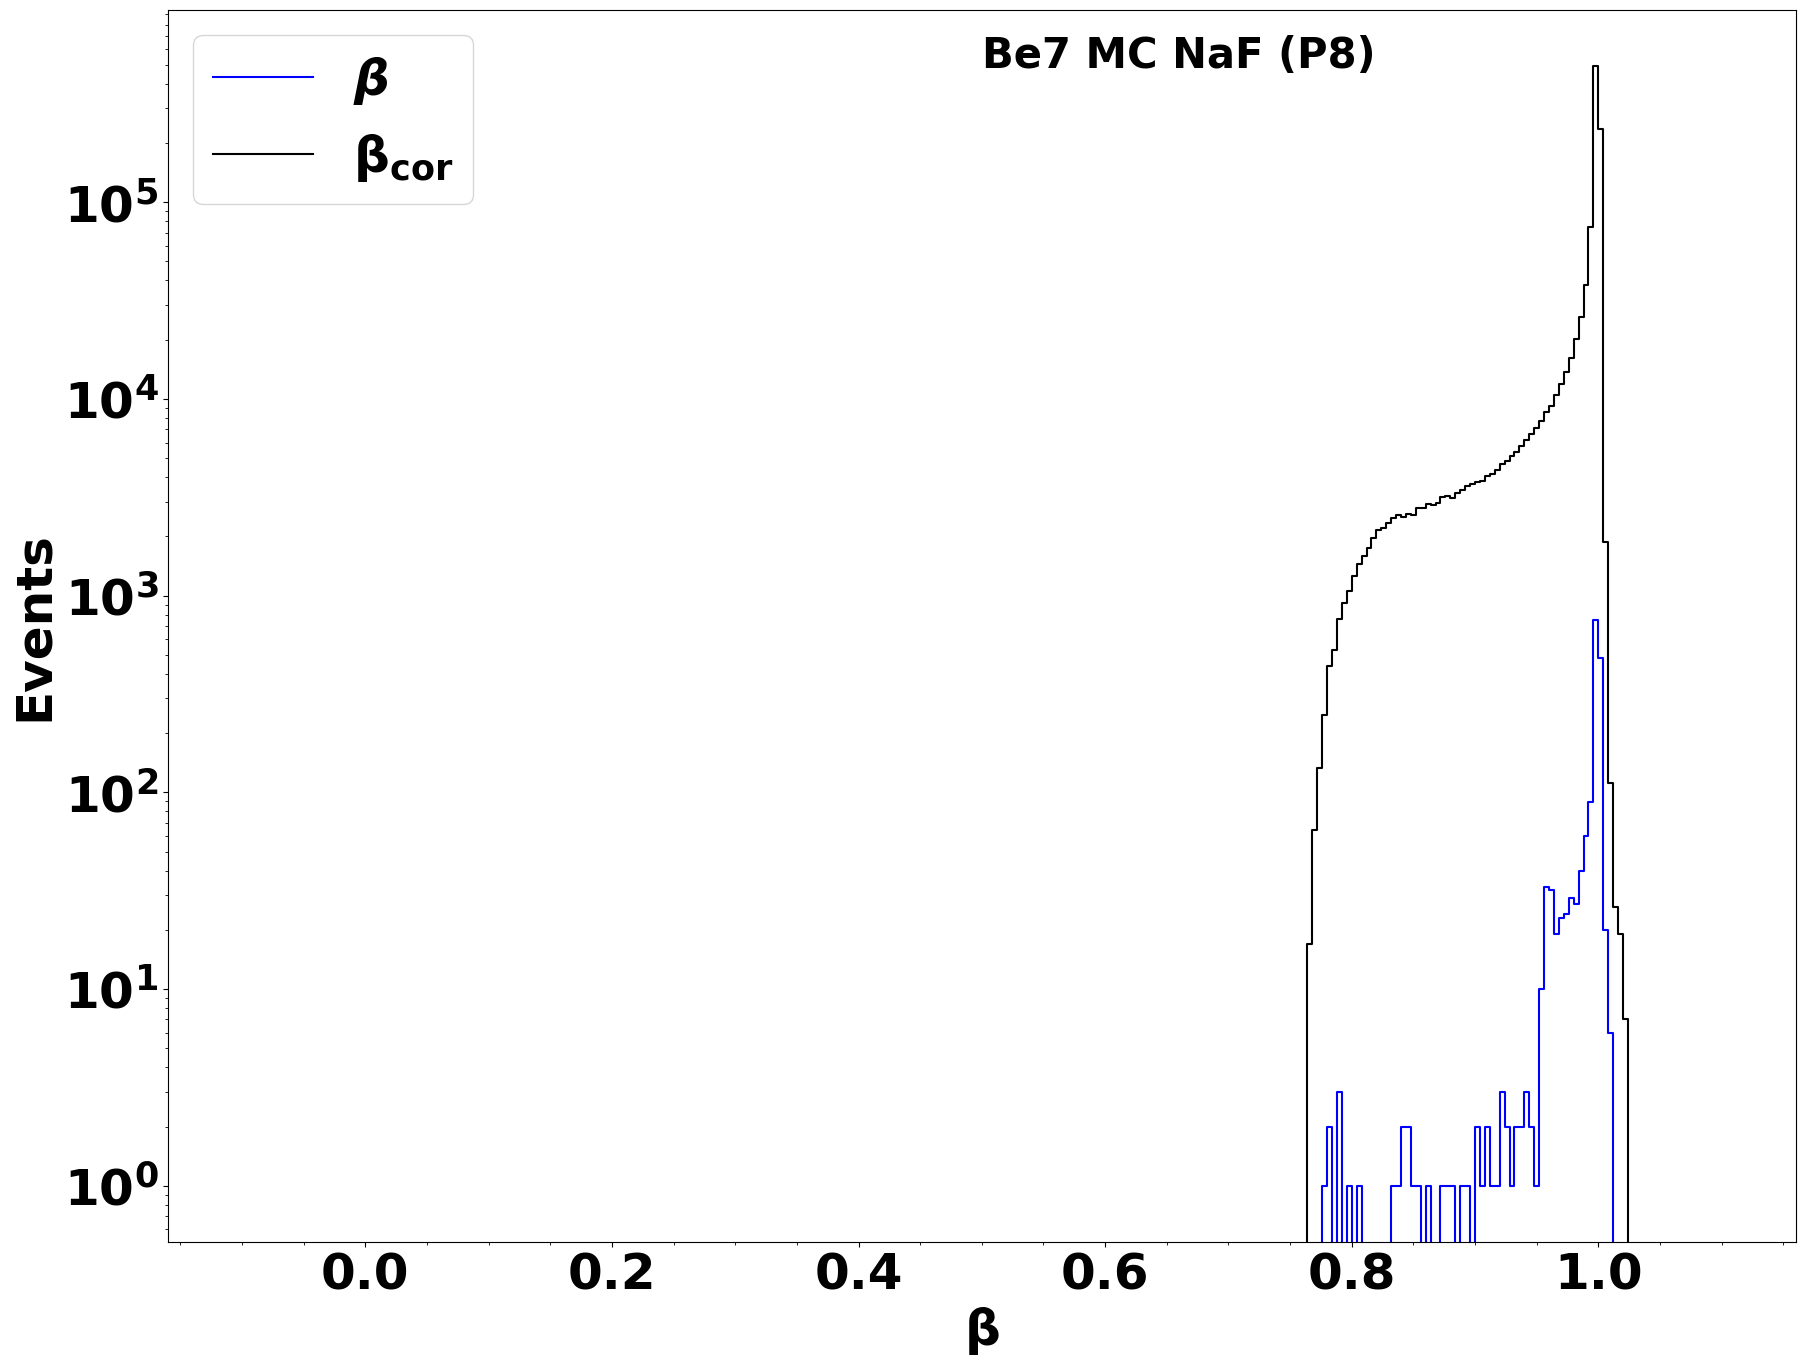

In [52]:
decs = ['NaF', 'Agl']
df_beta1 = np.load('/home/manbing/Documents/Data/data_BeP8/Be7MC_beta.npz')
df_beta2 = np.load('/home/manbing/Documents/Data/data_BeP8/Be7MC_betacor.npz')

hist_beta1 = {}
hist_beta2 = {}
for dec in decs:
    hist_beta1[dec] =  WeightedHistogram.from_file(df_beta1, f'hist_beta_{dec}_Be7')
    hist_beta2[dec] =  WeightedHistogram.from_file(df_beta2, f'hist_beta_{dec}_Be7')
    
    fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
    plot_histogram_1d(ax1, hist_beta1[dec], style='mc', label=r"$\beta$", color=mccolor,  scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    plot_histogram_1d(ax1, hist_beta2[dec], style='mc', label=r"$\mathrm{\beta_{cor}}$", color=isscolor,scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False, show_overflow=False, adjust_limits=None, adjust_limits_x=None, adjust_limits_y=None, flip_axes=False, override_limits=False, use_approximate_poisson_errors=False, draw_zeros=True, adjust_figure=True, markersize=20)
    ax1.text(0.5, 0.98, f"Be7 MC {dec} (P8)", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
    #ax1.set_ylim([0.01, 100000]) 
    ax1.legend()
    ####normalize it to 1
    savefig_tofile(fig, plotfile, f"{dec}_beta", show=True) 